# Dependencies

In [1]:
pacman::p_load( ggpubr,lsmeans,
    igraph, graphlayouts, 
    dplyr, ggplot2, 
    GUniFrac, ggsignif,
    iNEXT, ggrepel, tidyr
)

# Functions

In [2]:
colpal <- c("Vincristine" = "#E41A1C", 
           "Methotrexate" = "#377EB8",
           "Cyclophosphamide" = "#4DAF4A",
           "Vincristine/Methotrexate" = "#984EA3",
           "Vincristine/Cyclophosphamide" = "#fa9734",
           "Vincristine/Methotrexate/Cyclophosphamide" = "#f781bf",
           "No therapy" = "grey",
           "Others" = "#6c6c6c")


In [3]:
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/Misc_functions.R")

In [4]:
baseraincloud_plot.fx <- function(mydf, yvar, xvar, fillvar, colpal, binw, pointsize) {
    p0 <- ggplot(data = mydf, aes(x = eval(parse(text = xvar)), y = eval(parse(text = yvar)), fill = eval(parse(text = fillvar)))) +
        ggdist::stat_dist_halfeye(adjust = 0.5, .width = 0, justification = -0.1, point_color = NA, width = 0.7) +
        geom_boxplot(width = 0.1, outlier.shape = NA, alpha = 0.5) +
        ggdist::stat_dots(side = "left", justification = 1.1) +
        scale_fill_manual(values = colpal) +
        myaxis +
        myplot +
        theme(legend.position = "none") +
        #scale_y_continuous(limits = c(0, 110), breaks = c(0, 25, 50, 75, 100)) +
        labs(x = "", y = gsub("`", "", yvar))
    return(p0)
}


In [5]:
set.seed(111)
baseplot.fx <- function(mydf, x, y, fill, clr, colpal) {
    p1 <- ggplot(mydf, aes(x = factor(eval(parse(text = x))), y = eval(parse(text = y)), color = eval(parse(text = clr)), fill = eval(parse(text = fill)))) +
        geom_jitter(width = 0.1, height = 0.1, alpha = 0.2) +
        geom_boxplot(outlier.shape = NA, alpha = 0.1) +
        # geom_smooth(method = "loess", se = TRUE, aes(group = 1), color = "black", fill = "grey") +
        myplot +
        myaxis +
        scale_color_manual(values = colpal) +
        scale_fill_manual(values = colpal) +
        theme(legend.position = "none") +
        labs(x = x, y = gsub("`", "", y))
    return(p1)
}


# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [7]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/run_gliph/"

# Main

In [8]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [9]:
soc_good <- readr::read_rds(paste0(datapath,"soc_good_with_baseregimen.rds"))
soc_good_long <- soc_good %>%
  pivot_longer(
    cols = starts_with("base_regimen_"),
    names_to = "cycle",
    values_to = "regimen",
    names_prefix = "base_regimen_"
  ) %>%
  select(Patient, cycle, regimen)

head(soc_good_long)
# Join soc_good_long to meta_div
# First, create a mapping between cycle formats (X05 -> cycle5)
meta_div$cycle_mapped <- paste0("cycle", gsub("X0?", "", meta_div$cycle))

# Join the datasets
meta_div <- meta_div %>%
  left_join(soc_good_long, by = c("Patient" = "Patient", "cycle_mapped" = "cycle"))

# Clean up the temporary column
 meta_div$cycle_mapped <- NULL

# (meta_div[ meta_div$Patient == "CHP_407",])

Patient,cycle,regimen
<chr>,<chr>,<fct>
CHP_319,cycle1,Vincristine
CHP_319,cycle2,Vincristine/Cyclophosphamide
CHP_319,cycle3,Vincristine/Methotrexate
CHP_319,cycle4,Vincristine/Cyclophosphamide
CHP_319,cycle5,Vincristine/Methotrexate
CHP_323,cycle1,Vincristine


In [10]:
# Create exposed_regimen column, for each patient, if cycle is X01, then it is baseline, otherwise it is the previous cycle's regimen
## Use the soc_good dataframe to get the regimen for the previous cycle
## First, create a mapping between cycle formats (X05 -> cycle5)
## be explicit, eg get regimen of X04 for exponsed_regimen of X05
# Create exposed_regimen column
meta_div$exposed_regimen <- NA

# For each sample, determine the exposed regimen
for (i in 1:nrow(meta_div)) {
  current_patient <- meta_div$Patient[i]
  current_cycle <- meta_div$cycle[i]
  
  # If it's X01 (first cycle), exposed_regimen is NA (baseline)
  if (current_cycle == "X01") {
    meta_div$exposed_regimen[i] <- "baseline"
  } else {
    # Extract cycle number and get previous cycle
    cycle_num <- as.numeric(gsub("X0?", "", current_cycle))
    prev_cycle_num <- cycle_num - 1
    
    # Format previous cycle (e.g., 4 -> "cycle4")
    prev_cycle_col <- paste0("cycle", prev_cycle_num)
    
    # Get the base regimen for the previous cycle from soc_good
    prev_regimen <- as.character(soc_good[soc_good$Patient == current_patient, paste0("base_regimen_", prev_cycle_col), drop = T])
    
    if (length(prev_regimen) > 0 && !is.na(prev_regimen)) {
      meta_div$exposed_regimen[i] <- prev_regimen
    }
  }
}



In [11]:
#remove those samples that we did not have the TCRseq data for
meta_div <- meta_div[!is.na(meta_div$TRB),]

In [15]:
meta_div[ grepl("336", meta_div$file),]

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,exposed_regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>
215,CHP_336_03,CHP_336,X03,0,0,11,ALL,0,NA,NA,...,0.04845674,CHP_336-03_cfDNA,batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_336-03_cfDNA.txt,cfDNA,CHP,0.6656184,CHP_336_03_cfDNA,capTCR-seq,Vincristine/Methotrexate,Vincristine/Cyclophosphamide
216,CHP_336_04,CHP_336,X04,0,0,11,ALL,0,NA,NA,...,0.03890623,CHP_336-04_cfDNA,batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_336-04_cfDNA.txt,cfDNA,CHP,0.6986264,CHP_336_04_cfDNA,capTCR-seq,Vincristine/Cyclophosphamide,Vincristine/Methotrexate
217,CHP_336_05,CHP_336,X05,0,0,11,ALL,0,NA,NA,...,0.05794069,CHP_336-05_cfDNA,batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_336-05_cfDNA.txt,cfDNA,CHP,0.7945001,CHP_336_05_cfDNA,capTCR-seq,Vincristine/Methotrexate,Vincristine/Cyclophosphamide


In [12]:
# gliph_out <- readr::read_csv(paste0(datapath, "GLIPH/TIGERdb_ddb9f842-a6e1-4b02-8b6b-43ea4409c746_cluster.csv"), col_names = T) #  gliph reference dataset  is MItechel

In [13]:
# gliph_out <- readr::read_csv(paste0(datapath, "GLIPH/int_vdj_v5_cluster.csv"), col_names = T) #  gliph reference dataset  is MItechel

# 1- GLIPH groups diversity

to account for cloneCounts and number of groups

In [16]:
samples_tcr <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
gliphdf <- readr::read_rds(file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

In [17]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


In [18]:
dim(gliphdf)

[1] 8231   15

In [19]:
sum(colSums(gliphdf[,2:13] > 0)[c("CMV", "EBV", "HCV", "Influenza", "HPV", "MCPyV")] )
sum(colSums(gliphdf[,2:13] > 0)[c("SP", "TB")] )

[1] 467

[1] 35

In [20]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [21]:
samples_tcr$gliph_div <- NA
# add diversity of gliph groups
for (i in 1:nrow(samples_tcr)) {
  message(i)
  mypt <- gliph_out[gliph_out$Sample == rownames(samples_tcr)[i], ]

  # If there is more than one cdr3 in a pattern, sum the frequencies
  mypt_SumFreq <- mypt %>%
    group_by(pattern) %>%
    summarise(SumFreq = sum(Freq), .groups = "drop")
#message(rownames(samples_tcr)[i])
#print(mypt_SumFreq$SumFreq[order(mypt_SumFreq$SumFreq, decreasing = T)])
  out <- iNEXT::iNEXT(mypt_SumFreq$SumFreq[order(mypt_SumFreq$SumFreq, decreasing = T)], 0, 
  datatype = "abundance", knots = 10, se = F) # no need for se, as we report the AsymEst
  samples_tcr$gliph_div[i] <- out$AsyEst[3, 1] # Simpson
}


1

2

3

4

5

6

7

8

9

10

11

12

13

14

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
15

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
16

17

18

19

20

21

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
22

23

24

25

26

27

28

29

30

31

32

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

Warning message in EstiBootComm.Ind(x[[i]]):
"This site has only one species. Estimation is not robust."
89

90

91

92

93

94

95


In [22]:
head(samples_tcr)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,cdr3_reads,n_gliph,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age,gliph_div
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
CHP-328-04-PBMC-DNA,12,8,0,1,0,73,11,0,0,5,...,228171,243,125,98929,CHP_328,X04,PBMC,Leukemia,7.0,91.22875
CHP-328-05-PBMC-DNA,12,7,2,1,0,51,12,0,0,6,...,18751,117,34,15470,CHP_328,X05,PBMC,Leukemia,7.0,82.72436
CHP-351-03-PBMC-DNA,14,12,6,1,5,113,21,1,0,8,...,149387,390,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0,214.56354
CHP-369-01-PBMC-DNA,12,9,8,1,1,84,11,1,0,9,...,349868,340,183,160268,CHP_369,X01,PBMC,Leukemia,0.1,122.40195
CHP-377-02-PBMC-DNA,11,9,0,1,0,62,11,0,0,7,...,48793,182,96,15269,CHP_377,X02,PBMC,Leukemia,18.0,76.24481
CHP-411-02-PBMC-DNA,26,10,7,1,0,122,13,1,0,14,...,128114,472,294,55414,CHP_411,X02,PBMC,Leukemia,16.0,247.14003


In [23]:
sampletype <- samples_tcr[samples_tcr$sampletype == "PBMC" & samples_tcr$n_gliph > 2, ] # to avoid error in diversity calculation

In [24]:
sampletype$gliph_div_log <- log10(sampletype$gliph_div)

In [25]:
table(sampletype$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                 95                  27                  56                   9 

at baseline

In [26]:
X01 <- sampletype[ sampletype$cycle == "X01",]

In [27]:
tapply(X01$gliph_div_log, X01$cancergroup, summary)

$Leukemia
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3253  0.9093  1.8612  1.5896  2.0822  2.2725 

$Lymphoma
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.165   1.608   1.905   1.727   1.945   2.011 

$`Solid tumors`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7083  1.4814  1.7988  1.6507  1.9666  2.1146 

$`T-cell malignancies`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.634   1.006   1.377   1.377   1.748   2.120 


In [28]:
p1 <- baseraincloud_plot.fx(X01, "gliph_div_log", "cancergroup", "cancergroup", group_col, 0.5,0.4)

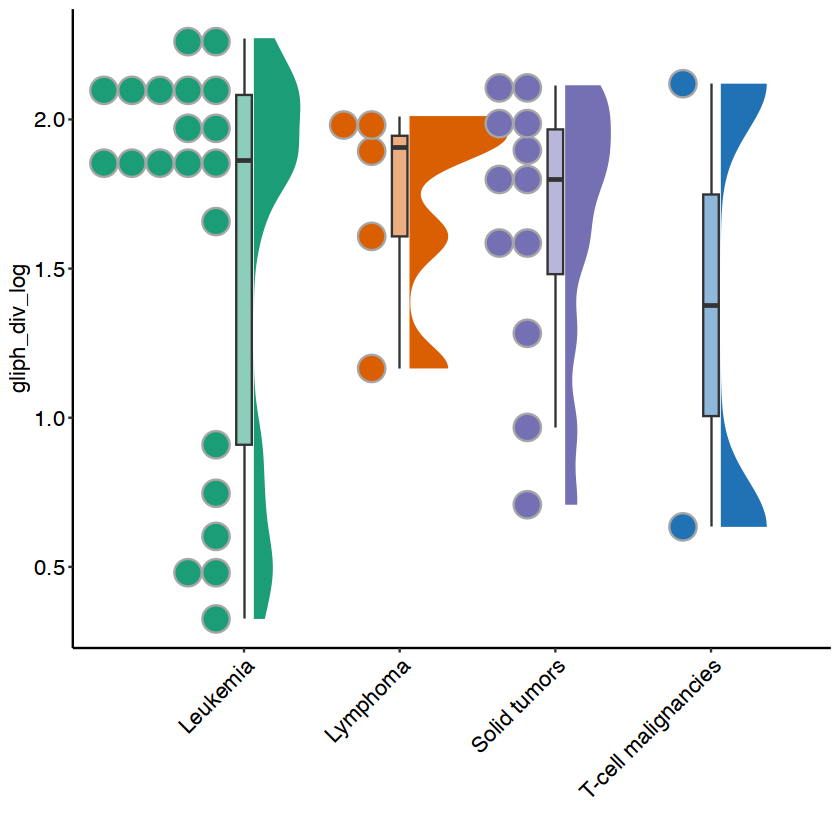

In [29]:
p1

In [30]:
mytest <- "gliph_div_log"
ks.test(X01[[mytest]][ which(X01$cancergroup == "Solid tumors")], X01[[mytest]][ which(X01$cancergroup == "Leukemia")])$p.value
ks.test(X01[[mytest]][ which(X01$cancergroup == "Solid tumors")], X01[[mytest]][ which(X01$cancergroup == "Lymphoma")])$p.value
ks.test(X01[[mytest]][ which(X01$cancergroup == "Lymphoma")], X01[[mytest]][ which(X01$cancergroup == "Leukemia")])$p.value

[1] 0.6423546

[1] 0.8909179

[1] 0.6442688

In [27]:
pdf(paste0(plotpath, "p_gliphdiv_pbmc_X01.pdf"), width = 6, height = 6)
p1
dev.off()

pdf 
  2

Spiderplot

In [28]:
# head(sampletype)

In [32]:
sampletype$Sample <- rownames(sampletype)

In [33]:
sampletype$gliph_div_log_scaled <- scale(sampletype$gliph_div_log)

In [34]:
diff_log10div <- calculate_delta.fx(sampletype, "cycle", "gliph_div_log_scaled")

In [ ]:
# marker <- "gliph_div_log"
# cancergrp <- "Leukemia"

# grp_df <- diff_log10div[diff_log10div$cancergroup == cancergrp, ]
# myformula <- as.formula(paste0("Difference", " ~ cycle + Age + (1 | Patient)"))
# myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
# lsm <- lsmeans(myfit, "cycle")
# mylsm_grp <- summary(lsm)
# mylsm_grp$cancergroup <- cancergrp # has to be same as original df
# mylsm_grp$marker <- marker

# myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
# myctrt_grp$cancergroup <- cancergrp
# myctrt_grp$marker <- marker

# leu_div <- list(mylsm_grp, myctrt_grp)

In [216]:
# leu_div[[2]]

Plots

In [ ]:
# diff_log10div$sample_id <- paste0(diff_log10div$Patient, "_", diff_log10div$cycle)
# diff_log10div$sample_id <- gsub("X", "", diff_log10div$sample_id) 

In [35]:
diff_log10div$Relapse <- meta_div$Relapse[ match(diff_log10div$Sample, meta_div$basename) ]
diff_log10div$Disease_type <- meta_div$Disease_type[ match(diff_log10div$Sample, meta_div$basename) ]
diff_log10div$Regimen <- meta_div$regimen[ match(diff_log10div$Sample, meta_div$basename) ]

In [37]:
table(diff_log10div$Regimen)


                              Vincristine 
                                       17 
                             Methotrexate 
                                       11 
                         Cyclophosphamide 
                                        2 
                 Vincristine/Methotrexate 
                                        8 
             Vincristine/Cyclophosphamide 
                                       23 
Vincristine/Methotrexate/Cyclophosphamide 
                                        2 
                                   Others 
                                       22 
                               No therapy 
                                       11 

In [38]:
tmppp <- diff_log10div[ which(diff_log10div$Patient == "CHP_373"),]

tmppp[ , c("Patient", "Difference", "Disease_type")]

Patient,Difference,Disease_type
<chr>,"<dbl[,1]>",<chr>
CHP_373,0.000000,ALL
CHP_373,-1.496894,ALL


In [139]:
# leupt <- unique(diff_log10div$Patient[diff_log10div$cancergroup == "Solid tumors"])
# mylst <- list()
# for( ii in leupt){
#   tmppp <- diff_log10div[ which(diff_log10div$Patient == ii),]
#   tmppp <- ungroup(tmppp)
#   mylst <- c(mylst, list(tmppp[ tmppp$cyclenum == max(tmppp$cyclenum), c("Patient", "Difference", "cyclenum", "Disease_type")]))
  
# }

In [140]:
# mylst

In [39]:
delta_basespiderplot.fx <- function(df_diff, var1, clrby, colpal) {
    # Create segments data for coloring lines by regimen
    segments_data <- df_diff %>%
        arrange(Patient, eval(parse(text = var1))) %>%
        group_by(Patient) %>%
        mutate(
            x_start = eval(parse(text = var1)),
            y_start = Difference,
            x_end = lead(eval(parse(text = var1))),
            y_end = lead(Difference),
            segment_regimen = Regimen
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p0 <- ggplot(df_diff, aes(x = eval(parse(text = var1)), y = Difference)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm"))
    return(p0)
}

In [40]:
p_simp <- delta_basespiderplot.fx(
    diff_log10div,  "cycle", "Regimen", colpal
)

In [41]:
table(diff_log10div$Disease_type )


  ALCL    ALL    AML   ARMS    BLL    CML   ERMS    EWS     HB     HD HR ALL 
     4     19     12      2      3      7      3      7      8     10      8 
    NB     OS  T-ALL 
     2      9      2 

In [42]:
diff_log10div$Disease_type <- factor(diff_log10div$Disease_type , levels = c("ALL", "AML", "CML", "HR ALL", # Leukemia
                                       "BLL", "HD",   # Lymphoma  
                                        "ARMS", "ERMS", "EWS", "HB", "NB", "OS",  # Solid tumors
                                        "ALCL", "T-ALL"))

In [43]:
design <- "
 ABCDEF
 GHIJKL
 MN####
"

In [44]:
p_simp <- p_simp + theme(legend.position = "none") +
  # facet_wrap(~cancergroup, nrow = 1, scales = "free_x", strip.position = "top") +
  ggh4x::facet_manual(~ Disease_type, design, scales = "free") +
  theme(
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.background.x = element_blank(),
    strip.placement = "outside",
    strip.text = element_text(size = 13)
  ) +
  ylab("Change in abundant TCR specificities") 
  # scale_x_discrete(get_breaks("cycle"),
  #   labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  # )


In [45]:
p_simp <- p_simp + geom_hline(yintercept = 0, linetype = "dashed", color = "red")

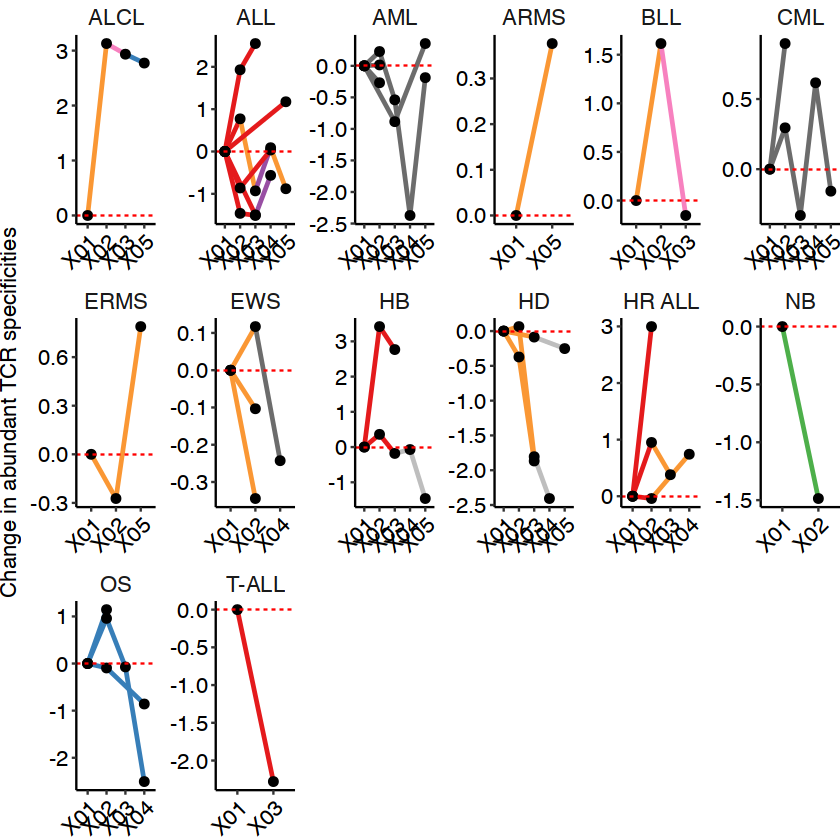

In [46]:
p_simp

In [47]:
pdf(paste0(plotpath, "p_spider_gliphdiv_pbmc_regimen_disease_type.pdf"), width = 10, height = 10)
cowplot::plot_grid(p_simp, labels = "A")
dev.off()

pdf 
  2

# 2 - Fisher scores vs difference

In [12]:
samples_tcr <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
gliphdf <- readr::read_rds( file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

In [13]:
dim(gliphdf)

[1] 8231   15

In [14]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [15]:
chp_gliph <- gliph_out[ grepl("CHP", gliph_out$Sample), ]
# chp_gliph <- chp_gliph[!grepl("Normal", chp_gliph$subject),]

In [16]:
length(unique(gliph_out$Sample))

[1] 666

In [17]:
meta_div[ meta_div$Patient == "CHP_422",]

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,exposed_regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>
451,CHP_422_01,CHP_422,X01,0.6,2136.39,12,ALL,0.6,NA,NA,...,0.04693025,CHP_422-01_cfDNA,priority_pool2/mixcr/clones/CLONES_TRBCHP_422-01_cfDNA.txt,cfDNA,CHP,0.7669209,CHP_422_01_cfDNA,capTCR-seq,Vincristine,baseline


In [18]:
length(unique(meta_div$Patient))

[1] 99

In [19]:
chp_gliph_pbmc <- chp_gliph[grepl("PBMC", chp_gliph$Sample),]

In [20]:
chp_gliph_pbmc$Patient <- meta_div$Patient[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cycle <- meta_div$cycle[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$sampletype <- meta_div$sampletype[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cancergroup <- meta_div$cancergroup[match(chp_gliph_pbmc$Sample, meta_div$basename)]

In [21]:
# get patients with more than one timepoiint and a baseline
mytab <- table(chp_gliph_pbmc$Patient, chp_gliph_pbmc$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]

In [22]:
head(mytab)

         
          X01 X02 X03 X04 X05
  CHP_323   0   0  82   0  65
  CHP_328   0   0   0 336 189
  CHP_331   0   0   0  15 128
  CHP_338   0   0 667  57 201
  CHP_339   0   0  13   0 294
  CHP_340   0   0 237 131 396

In [23]:
length(baseline_patients)

[1] 33

In [24]:
df1 <- chp_gliph_pbmc[chp_gliph_pbmc$Patient %in% baseline_patients, ]

In [25]:
head(df1)

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,...,V,J,TcRa,Sample,Freq,subject,Patient,cycle,sampletype,cancergroup
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV27,TRBJ2-2P,NA,CHP_405-04-PBMC-DNA,9,CHP_405-04-PBMC-DNA,CHP_405,X04,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV4-1,TRBJ2-2P,NA,CHP_396-02-PBMC-DNA,1,CHP_396-02-PBMC-DNA,CHP_396,X02,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV4-1,TRBJ2-2P,NA,CHP_381-02-PBMC-DNA,1,CHP_381-02-PBMC-DNA,CHP_381,X02,PBMC,Solid tumors
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV13,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,2,CHP_405-01_PBMC_DNA,CHP_405,X01,PBMC,Leukemia
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV6-4,TRBJ2-2P,NA,CHP_361-02-PBMC-DNA,28,CHP_361-02-PBMC-DNA,CHP_361,X02,PBMC,Lymphoma
1,SCP,0,197,657,1e-05,1,1,1,1,...,TRBV6-5,TRBJ2-2P,NA,CHP_414-02-PBMC-DNA,11,CHP_414-02-PBMC-DNA,CHP_414,X02,PBMC,Solid tumors


In [26]:
# separate pre and post
df1_pre <- df1[ df1$cycle == "X01",]
df1_post <- df1[ df1$cycle != "X01",]

In [27]:
dim(df1_pre)

[1] 7067   23

In [28]:
# group by patient and pattern, average frequencyes across samples postchemo
df1_post_mean <- df1_post %>%
  group_by(Patient, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()

In [29]:
# group by samples and patterns, avergae the frequencies, if there is > 1 CDR3s in a pattern
df1_pre_mean <- df1_pre %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()

In [30]:
head(df1_post_mean)

Patient,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP_347,%AGTGGQET,26
CHP_347,%ATGNTGE,7
CHP_347,%FFSGNT,6
CHP_347,%FGAYNE,34
CHP_347,%GGYE,8
CHP_347,%GQGNTE,8


In [31]:
head(df1_pre_mean)

Sample,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP-369-01-PBMC-DNA,%AGTENTE,130
CHP-369-01-PBMC-DNA,%AGTGGYE,482
CHP-369-01-PBMC-DNA,%ESKGNQP,201
CHP-369-01-PBMC-DNA,%ETGENTE,23
CHP-369-01-PBMC-DNA,%FRDRGVRE,1212
CHP-369-01-PBMC-DNA,%FVTGE,584


In [32]:
df1_pre_mean$Patient <- meta_div$Patient[match(df1_pre_mean$Sample, meta_div$basename)]
df1_pre_mean$cycle <- meta_div$cycle[match(df1_pre_mean$Sample, meta_div$basename)]
df1_pre_mean$sampletype <- meta_div$sampletype[match(df1_pre_mean$Sample, meta_div$basename)]
df1_pre_mean$cancergroup <- meta_div$cancergroup[match(df1_pre_mean$Sample, meta_div$basename)]
head(df1_pre_mean)

Sample,pattern,MeanFreq,Patient,cycle,sampletype,cancergroup
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
CHP-369-01-PBMC-DNA,%AGTENTE,130,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%AGTGGYE,482,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%ESKGNQP,201,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%ETGENTE,23,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%FRDRGVRE,1212,CHP_369,X01,PBMC,Leukemia
CHP-369-01-PBMC-DNA,%FVTGE,584,CHP_369,X01,PBMC,Leukemia


In [33]:
# matrix gliph x patient
gliph_pat_mat <- matrix(NA,
    nrow = length(unique(df1$pattern)), ncol = length(unique(df1$Patient)),
    dimnames = list(unique(df1$pattern), unique(df1$Patient))
)

In [34]:
head(gliph_pat_mat)

,CHP_405,CHP_396,CHP_381,CHP_361,CHP_414,CHP_365,CHP_378,CHP_347,CHP_364,CHP_408,...,CHP_418,CHP_357,CHP_362,CHP_366,CHP_368,CHP_387,CHP_367,CHP_412,CHP_409,CHP_349
SCP,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SERA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TVL,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
LFF,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SSER,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
KEAV,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [35]:
dim(gliph_pat_mat)

[1] 5569   33

In [ ]:
for (i in 1:nrow(gliph_pat_mat)) { # pattern loop
    for (j in 1:ncol(gliph_pat_mat)) { # patient loop
        mypattern <- rownames(gliph_pat_mat)[i]
        mypt <- colnames(gliph_pat_mat)[j]
        pt_pre <- df1_pre_mean[df1_pre_mean$Patient == mypt, ]
        pt_post <- df1_post_mean[df1_post_mean$Patient == mypt, ]
        if (length(pt_pre$MeanFreq[pt_pre$pattern == mypattern]) != 0 && length(pt_post$MeanFreq[pt_post$pattern == mypattern]) != 0) { # if pattern is present in both pre and post
            gliph_pat_mat[i, j] <- pt_post$MeanFreq[pt_post$pattern == mypattern] - pt_pre$MeanFreq[pt_pre$pattern == mypattern] # post - pre
        } # end of if
    } # end of patient loop
} # end of pattern loop

In [ ]:
gliph_pat_mat <- as.data.frame(gliph_pat_mat)

In [ ]:
# Add Fisher score to gliph_pat_mat
gliph_pat_mat$fisher <- df1$Fisher_score[match(rownames(gliph_pat_mat), df1$pattern)]

In [ ]:
gliph_pat_mat$gliph <- rownames(gliph_pat_mat)

In [ ]:
head(gliph_pat_mat)

,CHP_405,CHP_396,CHP_381,CHP_361,CHP_414,CHP_365,CHP_378,CHP_347,CHP_364,CHP_408,...,CHP_362,CHP_366,CHP_368,CHP_387,CHP_367,CHP_412,CHP_409,CHP_349,fisher,gliph
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SCP,10.500000,6.90000,NA,-2.666667,NA,-29.500000,-18.35714,1.000000,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,SCP
SERA,10.500000,3.95000,NA,-2.666667,NA,-29.500000,-18.35714,1.666667,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,SERA
TVL,10.500000,12.15000,-281.7778,-2.666667,NA,5.166667,-16.75000,1.000000,-19.5,NA,...,4.1,209.5,-3.25,NA,NA,NA,NA,NA,0,TVL
LFF,10.500000,6.90000,NA,-2.666667,NA,-29.500000,-18.35714,1.000000,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,LFF
SSER,9.782051,11.65476,NA,-2.666667,NA,-29.500000,-18.35714,1.000000,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,SSER
KEAV,10.500000,6.90000,NA,-2.666667,NA,-29.500000,-18.35714,1.000000,-19.5,NA,...,NA,209.5,-3.25,NA,NA,NA,NA,NA,0,KEAV


In [ ]:
# check one sample
df1_pre_mean[df1_pre_mean$Patient == "CHP_381" & df1_pre_mean$pattern == "S%GGNTE",]
df1_post_mean[df1_post_mean$Patient == "CHP_381" & df1_post_mean$pattern == "S%GGNTE",]

temp <- gliph_out[ grepl("CHP_381", gliph_out$Sample), ]
temp[ temp$pattern == "S%GGNTE",]

Sample,pattern,MeanFreq,Patient,cycle,sampletype,cancergroup
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
CHP_381-01_PBMC-DNA,S%GGNTE,114,CHP_381,X01,PBMC,Solid tumors


Patient,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP_381,S%GGNTE,5


index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
9458,S%GGNTE,0.73,4,3,6.5e-07,1,0.48,0.22,0.001,0.0062,global-S%GGNTE,CASSQGGNTEAFF,TRBV14,TRBJ1-1,NA,CHP_381-01_PBMC-DNA,134,CHP_381-01_PBMC-DNA
9458,S%GGNTE,0.73,4,3,6.5e-07,1,0.48,0.22,0.001,0.0062,global-S%GGNTE,CASSQGGNTEAFF,TRBV3-1,TRBJ1-1,NA,CHP_381-02-PBMC-DNA,5,CHP_381-02-PBMC-DNA
9458,S%GGNTE,0.73,4,3,6.5e-07,1,0.48,0.22,0.001,0.0062,global-S%GGNTE,CASSRGGNTEAFF,TRBV28,TRBJ1-1,NA,CHP_381-01_PBMC-DNA,94,CHP_381-01_PBMC-DNA


In [ ]:
# long format keep fisher and gliph as columns
gliph_pat_mat_long <- tidyr::pivot_longer(gliph_pat_mat, -c("fisher", "gliph"), names_to = "Patient", values_to = "Delta")

In [ ]:
# remove rows with NA
gliph_pat_mat_long <- gliph_pat_mat_long[ !is.na(gliph_pat_mat_long$Delta), ]

In [ ]:
head(gliph_pat_mat_long)

fisher,gliph,Patient,Delta
<dbl>,<chr>,<chr>,<dbl>
0,SCP,CHP_405,10.500000
0,SCP,CHP_396,6.900000
0,SCP,CHP_361,-2.666667
0,SCP,CHP_365,-29.500000
0,SCP,CHP_378,-18.357143
0,SCP,CHP_347,1.000000


In [ ]:
gliphdf_original <- gliphdf # save original gliphdf

In [82]:
# gliphdf[, 2:12][gliphdf[, 2:12] > 0] <- 1 # count each group only once

In [ ]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


In [ ]:
# Add annotations to gliph_pat_mat_long
gliph_pat_mat_long$CMV <- gliphdf$CMV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$Flu <- gliphdf$Influenza[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$HCV <- gliphdf$HCV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$EBV <- gliphdf$EBV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$HPV <- gliphdf$HPV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$HS <- gliphdf$Human[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$CEF <- gliphdf$CEF[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$HSV <- gliphdf$HSV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$TB <- gliphdf$TB[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$SP <- gliphdf$SP[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$MCPyV <- gliphdf$MCPyV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]
gliph_pat_mat_long$YFV <- gliphdf$YFV[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]

In [ ]:
gliph_pat_mat_long$n_unique_cdr3 <- gliphdf$n_unique_cdr3[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]

In [ ]:
gliph_pat_mat_long$cancergroup <- meta_div$cancergroup[match(gliph_pat_mat_long$Patient, meta_div$Patient)]
gliph_pat_mat_long$Disease <- meta_div$Disease_type[match(gliph_pat_mat_long$Patient, meta_div$Patient)]
gliph_pat_mat_long$Relapse <- meta_div$Relapse[match(gliph_pat_mat_long$Patient, meta_div$Patient)]

In [87]:
head(gliph_pat_mat_long)

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
0,SCP,CHP_405,10.500000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,CML,0
0,SCP,CHP_396,6.900000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,HR ALL,0
0,SCP,CHP_361,-2.666667,0,0,0,0,0,0,0,0,0,0,0,0,657,Lymphoma,HD,0
0,SCP,CHP_365,-29.500000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0
0,SCP,CHP_378,-18.357143,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0
0,SCP,CHP_347,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0


In [ ]:
temp <- gliph_out[ gliph_out$pattern == "S%GGNTE", ]
table(temp$subject)


CHP_345-02-PBMC-DNA CHP_347-02-PBMC-DNA CHP_357-05_PBMC-DNA CHP_370-02-PBMC-DNA 
                  1                   1                   1                   1 
CHP_381-01_PBMC-DNA CHP_381-02-PBMC-DNA CHP_382-05-PBMC-DNA CHP_391-02_PBMC_DNA 
                  2                   1                   1                   1 
CHP_391-03_PBMC_DNA CHP_393-05-PBMC-DNA CHP_403-03_PBMC-DNA               Human 
                  1                   1                   1                   1 

In [ ]:
length(unique(gliph_pat_mat_long$Patient))

[1] 27

In [ ]:
length(unique(gliph_pat_mat_long$gliph))

[1] 147

In [ ]:
summary(gliph_pat_mat_long$Delta)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-465.000  -19.500    0.250    9.039    7.598  741.000 

In [ ]:
quantile(gliph_pat_mat_long$Delta, c(0.1, 0.9))

10%       90% 
-29.50000  20.01111

In [ ]:
head(gliph_pat_mat_long)

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
0,SCP,CHP_405,10.500000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,CML,0
0,SCP,CHP_396,6.900000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,HR ALL,0
0,SCP,CHP_361,-2.666667,0,0,0,0,0,0,0,0,0,0,0,0,657,Lymphoma,HD,0
0,SCP,CHP_365,-29.500000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0
0,SCP,CHP_378,-18.357143,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0
0,SCP,CHP_347,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,657,Leukemia,ALL,0


In [ ]:
dim(gliph_pat_mat_long[ gliph_pat_mat_long$Delta < 20 & gliph_pat_mat_long$Delta > -29.5 & gliph_pat_mat_long$fisher < 0.0001,])

[1] 951  20

In [ ]:
# 3 groups common among more than 1 patient
gliph_pat_mat_long[ gliph_pat_mat_long$gliph %in% c("SLG%NTE", "SL%GE", "S%"),]

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1.7e-07,SL%GE,CHP_381,-1,0,0,1,0,0,1,0,0,0,0,0,0,21,Solid tumors,EWS,0
2.2e-05,SLG%NTE,CHP_381,-44,0,0,0,0,0,0,0,0,0,0,0,0,14,Solid tumors,EWS,0


In [ ]:
gliph_pat_mat_long[ gliph_pat_mat_long$SP != 0,]

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,CEF,HSV,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
0.0e+00,AVGA,CHP_405,10.893939,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,CML,0
0.0e+00,AVGA,CHP_396,6.900000,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,HR ALL,0
0.0e+00,AVGA,CHP_361,-2.666667,0,0,0,1,0,0,0,0,0,1,0,0,630,Lymphoma,HD,0
0.0e+00,AVGA,CHP_365,-22.500000,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,ALL,0
0.0e+00,AVGA,CHP_378,-18.357143,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,ALL,0
0.0e+00,AVGA,CHP_347,1.000000,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,ALL,0
0.0e+00,AVGA,CHP_364,-19.500000,0,0,0,1,0,0,0,0,0,1,0,0,630,Solid tumors,OS,1
0.0e+00,AVGA,CHP_399,-45.375000,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,HR ALL,0
0.0e+00,AVGA,CHP_410,6.166667,0,0,0,1,0,0,0,0,0,1,0,0,630,Leukemia,ALL,0


In [97]:
# Group antigens into categories
gliph_pat_mat_long$antigen <- NA
for (i in 1:nrow(gliph_pat_mat_long)) {

    if (rowSums(gliph_pat_mat_long[i, c("CMV", "Flu", "HCV", "EBV", "HPV", "MCPyV", "HSV", "YFV")]) > 0) {
        gliph_pat_mat_long$antigen[i] <- "Viral"
    }
    if (rowSums(gliph_pat_mat_long[i, "HS"]) > 0) {
        gliph_pat_mat_long$antigen[i] <- "HomoSapiens"
    }
    if (rowSums(gliph_pat_mat_long[i, c("TB", "SP")]) > 0) {
        gliph_pat_mat_long$antigen[i] <- "Bacterial"
    }    
    if (rowSums(gliph_pat_mat_long[i, "HS"]) > 0 && rowSums(gliph_pat_mat_long[i, c("TB", "SP", "CMV", "Flu", "HCV", "HSV", "YFV", "EBV", "HPV", "MCPyV")]) > 0) {
        gliph_pat_mat_long$antigen[i] <- "Cross-reactive"
    }
}

In [98]:
gliph_pat_mat_long$antigen[ is.na(gliph_pat_mat_long$antigen)] <- "Unknown"

In [99]:
table(gliph_pat_mat_long$antigen)


     Bacterial Cross-reactive    HomoSapiens        Unknown          Viral 
            18            144            252            725            171 

In [100]:
summary(gliph_pat_mat_long$fisher)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.00685 0.00000 0.58000 

In [101]:
min(gliph_pat_mat_long$fisher[ gliph_pat_mat_long$fisher > 0])

[1] 5.8e-24

In [102]:
gliph_pat_mat_long$log10fisher <- -log10(gliph_pat_mat_long$fisher + 1e-25)

In [103]:
gliph_pat_mat_long[ gliph_pat_mat_long$Delta > 430 & gliph_pat_mat_long$fisher < 0.0001,]

fisher,gliph,Patient,Delta,CMV,Flu,HCV,EBV,HPV,HS,...,TB,SP,MCPyV,YFV,n_unique_cdr3,cancergroup,Disease,Relapse,antigen,log10fisher
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>
0,AGW,CHP_413,741,0,0,0,0,0,3,...,0,0,0,0,656,Leukemia,AML,1,HomoSapiens,25


In [104]:
# gliph_pat_mat_long[ gliph_pat_mat_long$cancergroup == "Lymphoma",]

In [105]:
# gliph_pat_mat_long$label <- NA
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Delta > 367.6 & gliph_pat_mat_long$fisher < 0.0001] <- "X"
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Delta < -280.8 & gliph_pat_mat_long$fisher < 0.0001] <- "X"
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Patient == "CHP_413"] <- NA
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Patient == "CHP_362"] <- NA
# gliph_pat_mat_long$label[ gliph_pat_mat_long$Patient == "CHP_404"] <- NA

In [106]:
# tbl <- data.frame( pt = gliph_pat_mat_long$Patient[ which(gliph_pat_mat_long$label == "X") ],
# xend = gliph_pat_mat_long$Delta[ which(gliph_pat_mat_long$label == "X") ] - 20, 
# yend = gliph_pat_mat_long$log10fisher[ which(gliph_pat_mat_long$label == "X") ] )

In [107]:
# tbl$x <- NA
# tbl$y <- NA

In [108]:
# tbl$x[ tbl$pt == "CHP_369"] <- -1000
# tbl$y[ tbl$pt == "CHP_369"] <- 25
# tbl$x[ tbl$pt == "CHP_365"] <- -1000
# tbl$y[ tbl$pt == "CHP_365"] <- 20
# tbl$x[ tbl$pt == "CHP_381"] <- -900
# tbl$y[ tbl$pt == "CHP_381"] <- 10
# tbl$x[ tbl$pt == "CHP_396"] <- 1200
# tbl$y[ tbl$pt == "CHP_396"] <- 10
# tbl$x[ tbl$pt == "CHP_366"] <- 500
# tbl$y[ tbl$pt == "CHP_366"] <- 12

In [109]:
# tbl

In [110]:
p4 <- ggplot() +
    geom_point(data = gliph_pat_mat_long, aes(x = Delta, y = -log10(fisher + 1e-25), color = cancergroup, shape = antigen), alpha = 0.6, size = 5) +
    myplot +
    myaxis +
    geom_hline(yintercept = -log10(0.0001), linetype = 5) +
    geom_vline(xintercept = c(20, -29.5), linetype = 3) +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5), legend.title = element_text(size = 10)) +
    labs(y = "-log10(Fisher score)", x = "TCR specificity group clonal change \n[post-therapy - pre-therapy]") +
    guides(color = guide_legend(title = "Cancer groups"), shape = guide_legend(title = "Antigen"), size = guide_legend(title = "Unique CDR3s (count)")) +
    scale_color_manual(values = group_col)

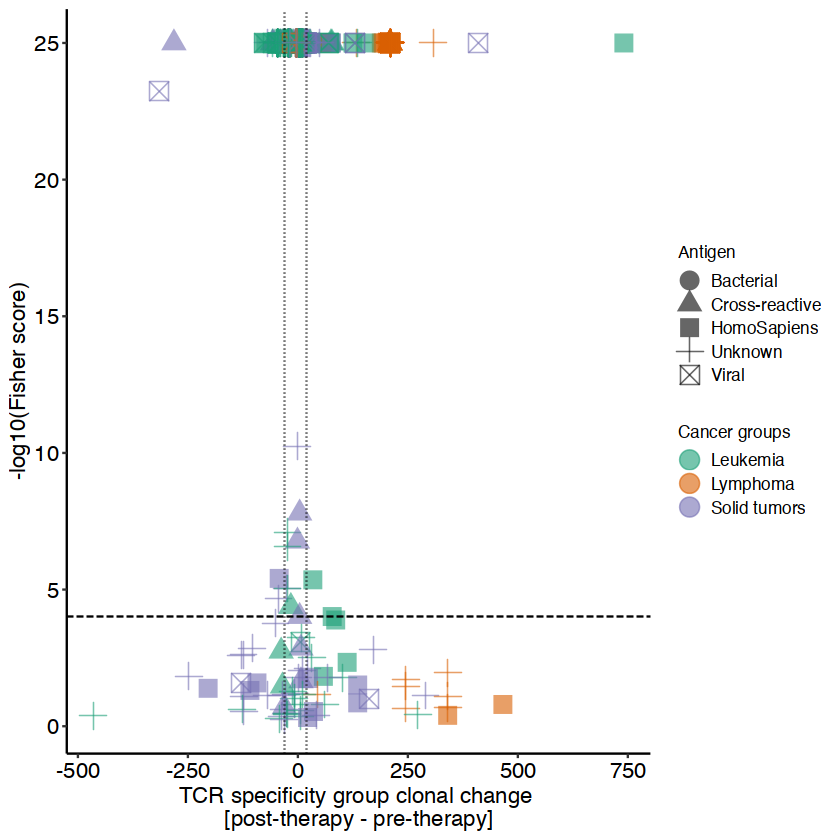

In [111]:
p4

In [ ]:
# p4 <- ggplot() +
#     geom_point(data = gliph_pat_mat_long, aes(size = n_unique_cdr3, x = Delta, y = -log10(fisher), color = cancergroup, shape = antigen), alpha = 0.6) +
#     myplot +
#     myaxis +
#     geom_hline(yintercept = c(-log10(0.0001), 42), linetype = c(5, 1)) +
#     geom_vline(xintercept = c(367.6, -280.9), linetype = 3) +
#     theme(axis.text.x = element_text(angle = 0, hjust = 0.5), legend.title = element_text(size = 10)) +
#     labs(y = "-log10(Fisher score)", x = "TCR specificity group clonal change \n[post-therapy - pre-therapy]") +
#     guides(color = guide_legend(title = "Cancer groups"), shape = guide_legend(title = "Antigen"), size = guide_legend(title = "Unique CDR3s (count)")) +
#     scale_color_manual(values = group_col)

In [ ]:
# p4_1 <- p4 + geom_segment( data = tbl, mapping = aes(x = x, y = y, xend = xend, yend = yend), linewidth = 0.5,
#          arrow = arrow(length = unit(0.02, "npc"))) + 
#          geom_text( data = tbl, mapping = aes(label = pt, x = x, y = y + 1))

In [112]:
pdf(paste0(plotpath, "p_tigerdb_gliph_fisher_delta_bycancer.pdf"), width = 7, height = 6)
cowplot::plot_grid(p4, labels = "C")
dev.off()

pdf 
  2

# 2.1 Fisher score vs delta per regimen

In [31]:
samples_tcr <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
gliphdf <- readr::read_rds( file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

In [32]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [33]:
chp_gliph <- gliph_out[ grepl("CHP", gliph_out$Sample), ]
# chp_gliph <- chp_gliph[!grepl("Normal", chp_gliph$subject),]

In [34]:
chp_gliph_pbmc <- chp_gliph[grepl("PBMC", chp_gliph$Sample),]

In [35]:
chp_gliph_pbmc$Patient <- meta_div$Patient[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cycle <- meta_div$cycle[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$sampletype <- meta_div$sampletype[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cancergroup <- meta_div$cancergroup[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$regimen <- meta_div$regimen[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$exposed_regimen <- meta_div$exposed_regimen[match(chp_gliph_pbmc$Sample, meta_div$basename)]

In [36]:
# get patients with more than one pair of consecutive timepoiints
mytab <- table(chp_gliph_pbmc$Patient, chp_gliph_pbmc$cycle)
# Find patients with at least one pair of consecutive timepoints (e.g., X01-X02, X02-X03, etc)
consecutive_matrix <- mytab > 0
# Only keep rows with at least one pair of adjacent TRUE values
consecutive_matrix <- consecutive_matrix[apply(consecutive_matrix, 1, function(x) any(x[-length(x)] & x[-1])), , drop = FALSE]

baseline_patients <- rownames(consecutive_matrix)

In [37]:
length(baseline_patients)

[1] 48

In [38]:
df1 <- chp_gliph_pbmc[chp_gliph_pbmc$Patient %in% baseline_patients, ]

In [39]:
table(df1$cycle)


  X01   X02   X03   X04   X05 
 6072 11932  9264  4794  5061 

In [40]:
# separate pre and post
df1_pre <- df1[ df1$cycle == "X01",]
df1_x02 <- df1[ df1$cycle == "X02",]
df1_x03 <- df1[ df1$cycle == "X03",]
df1_x04 <- df1[ df1$cycle == "X04",]
df1_x05 <- df1[ df1$cycle == "X05",]

In [41]:
dim(df1_pre)

[1] 6072   25

In [42]:
# group by samples and patterns, avergae the frequencies, if there is > 1 CDR3s in a pattern. do it for all cycles
df1_pre <- df1_pre %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x02 <- df1_x02 %>%  
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x03 <- df1_x03 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x04 <- df1_x04 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x05 <- df1_x05 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%  
  ungroup()

In [43]:
head(df1_pre)

Sample,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP-369-01-PBMC-DNA,%AGTENTE,130
CHP-369-01-PBMC-DNA,%AGTGGYE,482
CHP-369-01-PBMC-DNA,%ESKGNQP,201
CHP-369-01-PBMC-DNA,%ETGENTE,23
CHP-369-01-PBMC-DNA,%FRDRGVRE,1212
CHP-369-01-PBMC-DNA,%FVTGE,584


In [44]:
# df1_pre$Regimen <- meta_div$regimen[match(df1_pre$Sample, meta_div$basename)]
# df1_x02$Regimen <- meta_div$regimen[match(df1_x02$Sample, meta_div$basename)]
# df1_x03$Regimen <- meta_div$regimen[match(df1_x03$Sample, meta_div$basename)]
# df1_x04$Regimen <- meta_div$regimen[match(df1_x04$Sample, meta_div$basename)]
# df1_x05$Regimen <- meta_div$regimen[match(df1_x05$Sample, meta_div$basename)]

df1_pre$exposed_regimen <- meta_div$exposed_regimen[match(df1_pre$Sample, meta_div$basename)]
df1_x02$exposed_regimen <- meta_div$exposed_regimen[match(df1_x02$Sample, meta_div$basename)]
df1_x03$exposed_regimen <- meta_div$exposed_regimen[match(df1_x03$Sample, meta_div$basename)]
df1_x04$exposed_regimen <- meta_div$exposed_regimen[match(df1_x04$Sample, meta_div$basename)]
df1_x05$exposed_regimen <- meta_div$exposed_regimen[match(df1_x05$Sample, meta_div$basename)]

df1_pre$cancergroup <- meta_div$cancergroup[match(df1_pre$Sample, meta_div$basename)]
df1_x02$cancergroup <- meta_div$cancergroup[match(df1_x02$Sample, meta_div$basename)]
df1_x03$cancergroup <- meta_div$cancergroup[match(df1_x03$Sample, meta_div$basename)]
df1_x04$cancergroup <- meta_div$cancergroup[match(df1_x04$Sample, meta_div$basename)]
df1_x05$cancergroup <- meta_div$cancergroup[match(df1_x05$Sample, meta_div$basename)]


In [45]:
df1_pre$Disease_type <- meta_div$Disease_type[match(df1_pre$Sample, meta_div$basename)]
df1_x02$Disease_type <- meta_div$Disease_type[match(df1_x02$Sample, meta_div$basename)]
df1_x03$Disease_type <- meta_div$Disease_type[match(df1_x03$Sample, meta_div$basename)]
df1_x04$Disease_type <- meta_div$Disease_type[match(df1_x04$Sample, meta_div$basename)]
df1_x05$Disease_type <- meta_div$Disease_type[match(df1_x05$Sample, meta_div$basename)]

df1_pre$Patient <- meta_div$Patient[match(df1_pre$Sample, meta_div$basename)]
df1_x02$Patient <- meta_div$Patient[match(df1_x02$Sample, meta_div$basename)]
df1_x03$Patient <- meta_div$Patient[match(df1_x03$Sample, meta_div$basename)]
df1_x04$Patient <- meta_div$Patient[match(df1_x04$Sample, meta_div$basename)]
df1_x05$Patient <- meta_div$Patient[match(df1_x05$Sample, meta_div$basename)]


In [46]:
# Requirements
library(dplyr)
library(tidyr)
library(tibble)

# 1) Standardize the five dfs (accept either Freq or MeanFreq) and bind with explicit cycle labels
standardize_cycle_df <- function(df, cycle_label) {
  has_meanfreq <- "MeanFreq" %in% colnames(df)
  out <-  df %>% select(Sample, pattern, Patient,MeanFreq, exposed_regimen)
  out$cycle <- cycle_label
  out
}

df_list <- list(
  X01 = df1_pre,
  X02 = df1_x02,
  X03 = df1_x03,
  X04 = df1_x04,
  X05 = df1_x05
)

df_all <- do.call(rbind, lapply(names(df_list), function(nm) standardize_cycle_df(df_list[[nm]], nm)))



Attaching package: 'tibble'


The following object is masked from 'package:igraph':

    as_data_frame




In [47]:
head(df_all)

Sample,pattern,Patient,MeanFreq,exposed_regimen,cycle
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
CHP-369-01-PBMC-DNA,%AGTENTE,CHP_369,130,baseline,X01
CHP-369-01-PBMC-DNA,%AGTGGYE,CHP_369,482,baseline,X01
CHP-369-01-PBMC-DNA,%ESKGNQP,CHP_369,201,baseline,X01
CHP-369-01-PBMC-DNA,%ETGENTE,CHP_369,23,baseline,X01
CHP-369-01-PBMC-DNA,%FRDRGVRE,CHP_369,1212,baseline,X01
CHP-369-01-PBMC-DNA,%FVTGE,CHP_369,584,baseline,X01


In [48]:
sample_pat_map <- df_all[, c("Sample", "Patient","cycle", "exposed_regimen")]
sample_pat_map <- unique(sample_pat_map)

In [49]:
# # 2) Add Patient and Regimen for each Sample

# spm <- sample_pat_map[, c("Sample", "Patient", "regimen")]
# df_all <- df_all %>% left_join(spm, by = "Sample")

In [50]:
to_num <- function(x) as.integer(gsub("\\D", "", x))
df_pc2 <- df_all %>% mutate(cycle_num = to_num(cycle))

In [51]:
head(df_pc2)

Sample,pattern,Patient,MeanFreq,exposed_regimen,cycle,cycle_num
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>
CHP-369-01-PBMC-DNA,%AGTENTE,CHP_369,130,baseline,X01,1
CHP-369-01-PBMC-DNA,%AGTGGYE,CHP_369,482,baseline,X01,1
CHP-369-01-PBMC-DNA,%ESKGNQP,CHP_369,201,baseline,X01,1
CHP-369-01-PBMC-DNA,%ETGENTE,CHP_369,23,baseline,X01,1
CHP-369-01-PBMC-DNA,%FRDRGVRE,CHP_369,1212,baseline,X01,1
CHP-369-01-PBMC-DNA,%FVTGE,CHP_369,584,baseline,X01,1


In [52]:
from <- df_pc2 %>%
  transmute(
    Patient, pattern,
    cycle_from = cycle,
    cycle_num_from = cycle_num,
    MeanFreq_from = MeanFreq,
    next_cycle_num = cycle_num + 1L
  )

to <- df_pc2 %>%
  transmute(
    Patient, pattern,
    cycle_to = cycle,
    cycle_num_to = cycle_num,
    MeanFreq_to = MeanFreq
  )

# Safe inner join: (Patient, pattern, next_cycle_num) -> (Patient, pattern, cycle_num_to)
delta_long <- from %>%
  inner_join(to, by = c("Patient", "pattern", "next_cycle_num" = "cycle_num_to")) %>%
  transmute(
    Patient, pattern,
    cycle_from, cycle_to, next_cycle_num,
    MeanFreq_from, MeanFreq_to,
    Delta = MeanFreq_to - MeanFreq_from
  )

In [53]:
delta_long[ delta_long$Patient == "CHP_405" & delta_long$pattern == "VLR",]

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
CHP_405,VLR,X01,X02,2,2.833333,9.0,6.166667
CHP_405,VLR,X02,X03,3,9.000000,10.0,1.000000
CHP_405,VLR,X03,X04,4,10.000000,9.2,-0.800000
CHP_405,VLR,X04,X05,5,9.200000,59.0,49.800000


In [54]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


In [55]:
library(dplyr)

# fisher per pattern (choose best/lowest fisher if duplicated)
pattern_fisher <- df1 %>%
    distinct(pattern, Fisher_score) %>%
    group_by(pattern) %>%
    summarise(fisher = suppressWarnings(min(Fisher_score, na.rm = TRUE)), .groups = "drop") %>%
    mutate(fisher = ifelse(is.infinite(fisher), NA_real_, fisher))

# regimen per Patient x cycle (for the "to" cycle)
regimen_pc <- sample_pat_map %>%
    select(Patient, cycle, exposed_regimen) %>%
    group_by(Patient, cycle) %>%
    summarise(exposed_regimen = dplyr::first(na.omit(exposed_regimen)), .groups = "drop")

# antigen flags by pattern (gliphdf keyed by `gliph`)
ant_lookup <- gliphdf %>%
    select(gliph, CMV, Influenza, HCV, EBV, HPV, Human, CEF, HSV, TB, SP, MCPyV, YFV) %>%
    rename(Flu = Influenza, HS = Human)

# attach directly to delta_long
delta_long <- delta_long %>%
    left_join(pattern_fisher, by = "pattern") %>%
    left_join(regimen_pc, by = c("Patient", "cycle_to" = "cycle")) %>%
    left_join(ant_lookup, by = c("pattern" = "gliph"))

# (Optional) derive categorical antigen label for plotting shape
viral_cols     <- c("CMV", "Flu", "HCV", "EBV", "HPV", "MCPyV", "HSV", "YFV")
bacterial_cols <- c("TB", "SP")

delta_long$antigen <- "Unknown"
delta_long$antigen[rowSums(delta_long[, viral_cols],     na.rm = TRUE) > 0] <- "Viral"
delta_long$antigen[rowSums(delta_long[, bacterial_cols], na.rm = TRUE) > 0] <- "Bacterial"
delta_long$antigen[delta_long$HS > 0] <- "HomoSapiens"
delta_long$antigen[
    (delta_long$HS > 0) &
    (rowSums(delta_long[, c(viral_cols, bacterial_cols)], na.rm = TRUE) > 0)
] <- "Cross-reactive"

In [56]:
# gliph_pat_mat_long$n_unique_cdr3 <- gliphdf$n_unique_cdr3[match(gliph_pat_mat_long$gliph, gliphdf$gliph)]

In [57]:
# gliph_pat_mat_long$cancergroup <- meta_div$cancergroup[match(gliph_pat_mat_long$Patient, meta_div$Patient)]
# gliph_pat_mat_long$Disease <- meta_div$Disease_type[match(gliph_pat_mat_long$Patient, meta_div$Patient)]
# gliph_pat_mat_long$Relapse <- meta_div$Relapse[match(gliph_pat_mat_long$Patient, meta_div$Patient)]

In [58]:
summary(delta_long$Delta)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-465.000  -12.633    0.750    7.237   10.000  772.300 

In [479]:
quantiles <- quantile(delta_long$Delta, c(0.1, 0.9))

In [480]:
min(delta_long$fisher[ delta_long$fisher > 0])

[1] 5.4e-29

In [481]:
delta_long$log10fisher <- -log10(delta_long$fisher + 1e-30)

In [482]:
head(meta_div[ meta_div$Patient == "CHP_369",])

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,exposed_regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>
94,CHP_369_01,CHP_369,X01,5.1,544.44,0.1,AML,5.1,1591,4,...,0.6934305,CHP-369-01-PBMC-DNA,remaining_batch_4_28June2021/mixcr/clones/CLONES_TRBCHP-369-01-PBMC-DNA.txt,PBMC,CHP,2.588846,CHP_369_01_PBMC,Flow cytometry & capTCR-seq,Others,baseline
95,CHP_369_02,CHP_369,X02,0.0,0.00,0.1,AML,0.0,NA,NA,...,3.6862007,CHP_369-02-PBMC-DNA,batch8_14Jan2020/mixcr/clones/CLONES_TRBCHP_369-02-PBMC-DNA.txt,PBMC,CHP,2.210669,CHP_369_02_PBMC,capTCR-seq,Others,Others
308,CHP_369_02,CHP_369,X02,0.0,0.00,0.1,AML,0.0,NA,NA,...,0.1092570,CHP_369-02_cfDNA,batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_369-02_cfDNA.txt,cfDNA,CHP,1.353341,CHP_369_02_cfDNA,capTCR-seq,Others,Others


In [483]:
pattern_patient_count <- delta_long %>%
  dplyr::distinct(Patient, pattern) %>%
  dplyr::count(pattern, name = "n_patients_with_pattern")

# Attach to delta_long
delta_long <- delta_long %>%
  dplyr::left_join(pattern_patient_count, by = "pattern")


In [484]:
head(pattern_patient_count)

pattern,n_patients_with_pattern
<chr>,<int>
%DSNQP,1
%GGSSYE,1
%LDRNTE,1
%LGQNTE,1
%RGGSYE,1
%RLNTE,1


In [485]:
# length(unique(delta_long[ delta_long$pattern == "AEVS",]$Patient))

In [486]:
head(delta_long)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,HS,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CHP_369,AEV,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,1,0,Viral,30,29
CHP_369,AEVS,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,AGW,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,3,0,0,0,0,0,0,HomoSapiens,30,30
CHP_369,AGWA,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,APE,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Viral,30,30
CHP_369,APES,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29


In [487]:
delta_long$exposed_regimen <- factor(delta_long$exposed_regimen, levels = c("No therapy", setdiff(names(colpal), "No therapy")))

In [488]:
p4 <- ggplot() +
    geom_point(data = delta_long, aes(x = Delta, y = -log10(fisher + 1e-25), 
    color = exposed_regimen, shape = antigen, size = n_patients_with_pattern),
    alpha = 0.8) +
    myplot +
    myaxis +
    # geom_hline(yintercept = -log10(0.0001), linetype = 5) +
    geom_vline(xintercept = c(quantiles[1], quantiles[2]), linetype = 3) +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5), legend.title = element_text(size = 10)) +
    labs(y = "-log10(Fisher score)", x = "TCR specificity group clonal change \n[post-therapy - pre-therapy]") +
    guides(color = guide_legend(title = "exposed_regimen"), 
    shape = guide_legend(title = "Antigen"), 
    size = guide_legend(title = "Unique CDR3s (count)")) +
    scale_color_manual(values = colpal) + scale_size_continuous(range = c(3, 6))

In [489]:
pdf(paste0(plotpath, "p_tigerdb_gliph_fisher_delta_bytherapy.pdf"), width = 10, height = 7)
cowplot::plot_grid(p4, labels = "A")
dev.off()

pdf 
  2

In [490]:
# ggsave(paste0(plotpath, "delta_long_plot_regimen.pdf"), p4, width = 7, height = 7)
# ggsave(paste0(plotpath, "delta_long_plot_regimen.png"), p4, width = 7, height = 7, dpi = 600)

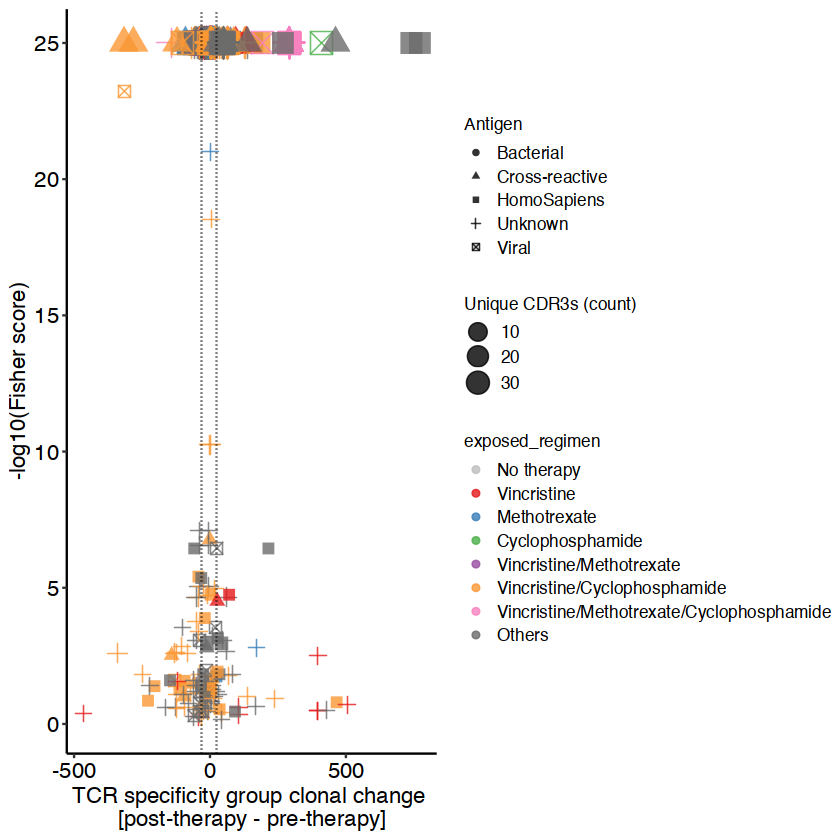

In [491]:
p4

In [492]:
summary(delta_long$fisher)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.00514 0.00000 0.70000 

In [493]:
head(delta_long)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,HS,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CHP_369,AEV,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,1,0,Viral,30,29
CHP_369,AEVS,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,AGW,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,3,0,0,0,0,0,0,HomoSapiens,30,30
CHP_369,AGWA,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,APE,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Viral,30,30
CHP_369,APES,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29


In [494]:
top_patterns <- delta_long$pattern[ delta_long$fisher < 0.0001 & delta_long$n_patients_with_pattern > 1]

In [495]:
# Build ordered rows from top_patterns and plot
top_df <- delta_long %>%
    dplyr::filter(pattern %in% top_patterns) %>%
    dplyr::arrange(dplyr::desc(Delta)) %>%
    dplyr::mutate(row = dplyr::row_number())

In [496]:
# Count number of unique antigens among unique patterns in top_df
top_unique_patterns <- top_df %>% dplyr::distinct(pattern, .keep_all = TRUE)
num_unique_antigens <- length(unique(top_unique_patterns$antigen))
print(num_unique_antigens)


[1] 5


In [497]:
length(unique(top_df$pattern))

[1] 71

In [498]:
length(unique(top_df$Patient))
# summary(top_df$n_patients_with_pattern)

[1] 39

In [499]:
summary(top_df$n_patients_with_pattern)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00   29.00   29.00   29.15   29.00   33.00 

In [500]:
summary(top_df$Delta)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-316.333  -12.333    0.750    8.015   10.000  772.300 

In [501]:
tab <- as.data.frame.matrix(table(top_df$antigen, top_df$pattern))
(rowSums(tab > 0))
tab

Bacterial Cross-reactive    HomoSapiens        Unknown          Viral 
             1              7             13             41              9

,AEV,AEVS,AGW,AGWA,APE,APES,AVGA,AVL,AVLR,CP,...,TLRG,TVL,TVLG,VGAP,VLGK,VLR,VLRG,VSSC,WAE,WAEV
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Bacterial,0,0,0,0,0,0,39,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cross-reactive,0,0,0,0,0,0,0,40,0,0,...,0,41,0,0,0,0,0,0,37,0
HomoSapiens,0,0,39,0,0,0,0,0,0,39,...,0,0,35,0,0,37,0,0,0,0
Unknown,0,37,0,37,0,37,0,0,37,0,...,0,0,0,37,36,0,37,37,0,37
Viral,37,0,0,0,40,0,0,0,0,0,...,38,0,0,0,0,0,0,0,0,0


In [507]:
head(top_df, 5)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern,row
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
CHP_405,EVS,X04,X05,5,9.20000,781.5,772.3000,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,1
CHP_413,AGW,X01,X02,2,18.00000,759.0,741.0000,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,30,2
CHP_405,PTL,X04,X05,5,9.20000,471.0,461.8000,0,Others,...,0,0,0,0,0,0,Cross-reactive,30,32,3
CHP_418,LRGA,X01,X02,2,13.66667,424.0,410.3333,0,Cyclophosphamide,...,0,0,0,0,1,0,Viral,30,31,4
CHP_403,EVS,X02,X03,3,3.80000,295.5,291.7000,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,HomoSapiens,30,29,5


In [502]:
head(top_df[ top_df$Patient == "CHP_405",], 5)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern,row
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
CHP_405,EVS,X04,X05,5,9.2,781.5,772.3,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,1
CHP_405,PTL,X04,X05,5,9.2,471.0,461.8,0,Others,...,0,0,0,0,0,0,Cross-reactive,30,32,3
CHP_405,GWA,X04,X05,5,9.2,277.5,268.3,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,71
CHP_405,WAE,X04,X05,5,9.2,146.5,137.3,0,Others,...,0,1,0,0,0,0,Cross-reactive,30,29,75
CHP_405,AEV,X04,X05,5,9.2,59.0,49.8,0,Others,...,0,0,0,0,1,0,Viral,30,29,160


In [168]:
p_top <- ggplot(top_df, aes(x = row, y = Delta)) +
    geom_point(size = 3, aes(color = exposed_regimen)) +
   # geom_text(aes(label = pattern), vjust = -0.6, size = 3) +
    scale_x_continuous(breaks = top_df$row) +
    theme_minimal() +
    myplot + myaxis + 
    theme(axis.text.x = element_blank(),
            axis.title.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    facet_wrap(~exposed_regimen) +
    scale_color_manual(values = colpal) +
    labs(x = "Row (ordered by Delta desc)", y = "Delta", color = "exposed_regimen")

In [169]:
p_top1 <- ggplot(top_df, aes(x = row, y = Delta)) +
    geom_point(size = 2,alpha = 0.8,shape = 16, aes(color = exposed_regimen)) +
   # geom_text(aes(label = pattern), vjust = -0.6, size = 3) +
    scale_x_continuous(breaks = top_df$row) +
    theme_minimal() +
    myplot + myaxis + 
    theme(axis.text.x = element_blank(),
            axis.title.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), "cm")) +
   # facet_wrap(~exposed_regimen) +
    scale_color_manual(values = colpal) +
    labs(x = "Row (ordered by Delta desc)", y = "Delta", color = "exposed_regimen")

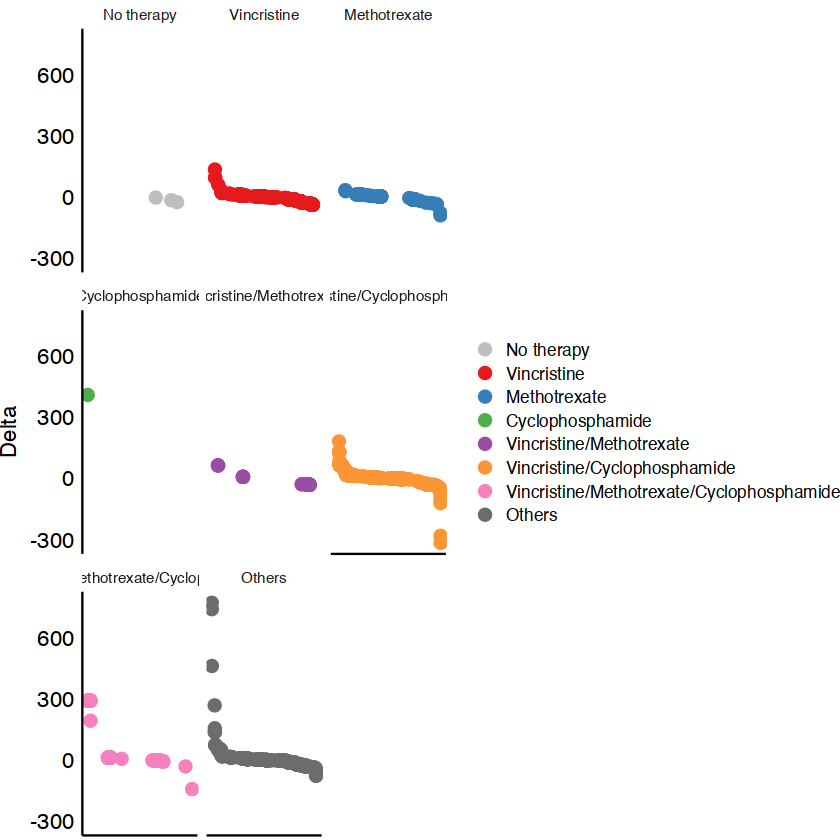

In [170]:
p_top

In [171]:
# Save the 'delta_long' dataframe as a PDF with a wide width
pdf(paste0(plotpath, "Splot_toppatterns.pdf"), width = 10, height = 5)
p_top1 + theme(legend.position = "right")
dev.off()

pdf 
  2

In [172]:
# Save the 'delta_long' dataframe as a PDF with a wide width
pdf(paste0(plotpath, "delta_long_wide1.pdf"), width = 10, height = 10)
p_top + theme(legend.position = "none")
dev.off()


pdf 
  2

In [201]:
# Pairwise test (Wilcoxon) and boxplot of Delta across Regimen per pattern in top_patterns

library(dplyr)
library(tidyr)
library(ggplot2)

df_sub <- delta_long %>%
  dplyr::filter(pattern %in% top_patterns, !is.na(Delta), !is.na(exposed_regimen))

# Order facets by descending median Delta
pattern_order <- df_sub %>%
  dplyr::group_by(pattern) %>%
  dplyr::summarise(median_Delta = median(Delta, na.rm = TRUE), .groups = "drop") %>%
  dplyr::arrange(dplyr::desc(median_Delta)) %>%
  dplyr::pull(pattern)

In [202]:
length(unique(df_sub$pattern))

[1] 71

In [203]:
head(df_sub)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,HS,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CHP_369,AEV,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,1,0,Viral,30,29
CHP_369,AEVS,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,AGW,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,3,0,0,0,0,0,0,HomoSapiens,30,30
CHP_369,AGWA,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,APE,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Viral,30,30
CHP_369,APES,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29


In [204]:
# df_sub$scaled_delta <- scale(df_sub$Delta)

In [79]:
# df_sub <- df_sub %>%
#   dplyr::mutate(pattern = factor(pattern, levels = pattern_order))

# # Safe per-antigen pairwise Wilcoxon tests (BH-adjusted), using only delta_long
# pairwise_results <- df_sub %>%
#   dplyr::group_by(antigen) %>%
#   dplyr::group_modify(~{
#     dat <- .x
#     if (dplyr::n_distinct(dat$exposed_regimen) <= 2L || nrow(dat) <= 3L) {
#       return(tibble(group1 = NA_character_, group2 = NA_character_, p.adj = NA_real_))
#     }
#     res <- try(stats::pairwise.t.test(dat$Delta, dat$exposed_regimen, p.adjust.method = "BH", exact = FALSE), silent = TRUE)
#     if (inherits(res, "try-error") || is.null(res$p.value)) {
#       return(tibble(group1 = NA_character_, group2 = NA_character_, p.adj = NA_real_))
#     }
#     as.data.frame(as.table(res$p.value), stringsAsFactors = FALSE) %>%
#       tidyr::drop_na(Freq) %>%
#       dplyr::rename(group1 = Var1, group2 = Var2, p.adj = Freq)
#   }) %>%
#   dplyr::ungroup()

# # Print (optional): head(pairwise_results)

# # Boxplot + jitter, faceted by pattern
# p_box <- ggplot(df_sub, aes(x = exposed_regimen, y = Delta, color = exposed_regimen)) +
#   geom_boxplot(outlier.shape = NA, alpha = 0.35) +
#   geom_jitter(width = 0.15, alpha = 0.6) +
#   facet_wrap(~ antigen, scales = "free_y") +
#   theme_minimal() +
#   scale_color_manual(values = colpal) +
#   theme(legend.position = "top") +
#   #myplot + myaxis +
#   labs(x = "exposed_regimen", y = "Delta", color = "exposed_regimen")

# # Print plot
# # p_box

In [76]:
# table(df_sub$Regimen[ df_sub$antigen == "HomoSapiens"])

In [80]:
# p_box

In [ ]:
# delta_long$Regimen <- factor(delta_long$Regimen, levels = c("No therapy", setdiff(names(colpal), "No therapy")))

In [ ]:
library(dplyr)
library(tidyr)
library(ggplot2)

df_sub <- delta_long %>%
  dplyr::filter(pattern %in% top_patterns, !is.na(Delta), !is.na(exposed_regimen))

# df_sub$scaled_delta <- scale(df_sub$Delta)
# Order facets by descending median Delta
pattern_order <- df_sub %>%
  dplyr::group_by(pattern) %>%
  dplyr::summarise(median_Delta = median(Delta, na.rm = TRUE), .groups = "drop") %>%
  dplyr::arrange(dplyr::desc(median_Delta)) %>%
  dplyr::pull(pattern)

df_sub <- df_sub %>%
  dplyr::mutate(pattern = factor(pattern, levels = pattern_order))

# Safe per-antigen pairwise Wilcoxon tests (BH-adjusted), using only delta_long
pairwise_results <- df_sub %>%
  dplyr::group_by(antigen) %>%
  dplyr::group_modify(~{
    dat <- .x
    reg_levels <- unique(as.character(dat$exposed_regimen))
    # Exclude cases without "No therapy" or where exactly one level or not enough samples
    if (!("No therapy" %in% reg_levels) || length(reg_levels) < 2L || nrow(dat) <= 3L) {
      return(tibble(group1 = NA_character_, group2 = NA_character_, 
                    p.adj = NA_real_, 
                    median_group1 = NA_real_, median_group2 = NA_real_))
    }
    other_groups <- setdiff(reg_levels, "No therapy")
    if (length(other_groups) == 0) {
      return(tibble(group1 = NA_character_, group2 = NA_character_, 
                    p.adj = NA_real_, 
                    median_group1 = NA_real_, median_group2 = NA_real_))
    }
    res_list <- lapply(other_groups, function(grp) {
      vals_no_therapy <- dat$Delta[dat$exposed_regimen == "No therapy"]
      vals_grp <- dat$Delta[dat$exposed_regimen == grp]
      p <- tryCatch(
        stats::wilcox.test(vals_grp, vals_no_therapy, exact = FALSE)$p.value,
        error = function(e) NA_real_
      )
      median1 <- if (length(vals_grp) > 0) median(vals_grp, na.rm = TRUE) else NA_real_
      median2 <- if (length(vals_no_therapy) > 0) median(vals_no_therapy, na.rm = TRUE) else NA_real_
      tibble(group1 = grp, group2 = "No therapy", p = p, 
             median_group1 = median1, median_group2 = median2)
    })
    res_table <- dplyr::bind_rows(res_list)
    # Adjust for multiple comparisons within antigen using BH
    res_table$p.adj <- p.adjust(res_table$p, method = "BH")
    res_table %>% dplyr::select(group1, group2, p.adj, median_group1, median_group2)
  }) %>%
  dplyr::ungroup()


In [82]:
pairwise_results

antigen,group1,group2,p.adj,median_group1,median_group2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Bacterial,Others,No therapy,0.4453120,-2.233333,-26
Bacterial,Vincristine,No therapy,0.4453120,0.750000,-26
Bacterial,Vincristine/Cyclophosphamide,No therapy,0.4453120,2.977273,-26
Bacterial,Methotrexate,No therapy,0.4453120,2.000000,-26
Bacterial,Vincristine/Methotrexate/Cyclophosphamide,No therapy,0.4453120,11.500000,-26
Bacterial,Vincristine/Methotrexate,No therapy,1.0000000,-30.666667,-26
Cross-reactive,Others,No therapy,0.5815839,-0.800000,-16
Cross-reactive,Vincristine,No therapy,0.4786033,0.500000,-16
Cross-reactive,Vincristine/Cyclophosphamide,No therapy,0.4786033,3.064394,-16


In [83]:
library(ggsignif)

plot_regimen_boxplot <- function(df_sub, antigen, pairwise_results, colpal, zoom = TRUE) {
  # Subset data for the specified antigen
  data_plot <- df_sub[df_sub$antigen == antigen, ]

  # --- Y-axis range handling ---
  y_vals <- data_plot$Delta
  if (zoom) {
    # Zoom-in range (central 98% with buffer)
    y_low <- quantile(y_vals, 0.01, na.rm = TRUE)
    y_high <- quantile(y_vals, 0.99, na.rm = TRUE)
    y_mid_spread <- y_high - y_low
    y_min <- y_low - 0.1 * y_mid_spread
    y_max <- y_high + 0.1 * y_mid_spread
    subtitle_text <- "(Zoomed to central 98% of values; outliers not shown)"
  } else {
    # Full range with buffer
    y_low <- min(y_vals, na.rm = TRUE)
    y_high <- max(y_vals, na.rm = TRUE)
    y_mid_spread <- y_high - y_low
    # If y_mid_spread is 0 (all points identical), fudge a little
    if (y_mid_spread == 0) y_mid_spread <- abs(y_low) + 1
    y_min <- y_low - 0.1 * y_mid_spread
    y_max <- y_high + 0.1 * y_mid_spread
    subtitle_text <- "(Full range; all values shown)"
  }

  # Prepare significance annotations
  sig_pairs <- pairwise_results %>%
    dplyr::filter(antigen == !!antigen, !is.na(p.adj) & p.adj < 0.05) %>%
    dplyr::mutate(label = paste0("p=", formatC(p.adj, format="e", digits=2)))

  # Prepare annotation df for ggsignif (if any significant pairs)
  if (nrow(sig_pairs) > 0) {
    # Compute reasonable y_position using the *zoomed/full* range (y_max/y_mid_spread)
    signif_df <- data.frame(
      group1 = sig_pairs$group1,
      group2 = sig_pairs$group2,
      annotation = sig_pairs$label,
      y_position = sapply(seq_along(sig_pairs$group1), function(i) {
        # try to avoid stacking bugs if same group appears multiple times, so move by i
        y_base <- y_max
        # Offset each annotation by an additional 7% of the range
        offset <- 0.1 * y_mid_spread
        y_base + (i - 1) * offset
      }),
      stringsAsFactors = FALSE
    )
  } else {
    signif_df <- NULL
  }

  # If no significance was detected, show a message in the plot subtitle
  if (is.null(signif_df) || nrow(signif_df) == 0) {
    # subtitle_text <- paste(subtitle_text, "\nNo significant differences (FDR<0.05)")
  } else {
    # If significant, show which comparisons are significant in subtitle as well
    # sig_descr <- paste0(sig_pairs$group1, " vs ", sig_pairs$group2, ": ", sig_pairs$label, collapse = "\n; ")
    # subtitle_text <- paste(subtitle_text, "\nSignificant: ", sig_descr)
  }

  p <- ggplot(data_plot, aes(x = exposed_regimen, y = Delta)) +
    geom_jitter(width = 0.2, alpha = 0.6, size = 1.6, shape = 16) +
    geom_boxplot(outlier.shape = NA, alpha = 0.6, aes(color = exposed_regimen), width = 0.5, fill = "white") +
    theme_minimal() +
    scale_color_manual(values = colpal) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "none") +
    labs(x = "", y = "Delta") +
    ggtitle(antigen)

  # Add significance annotations if any, and overlay on chosen y range
  if (!is.null(signif_df) && nrow(signif_df) > 0) {
    for (i in seq_len(nrow(signif_df))) {
      p <- p +
        geom_signif(
          comparisons = list(c(signif_df$group1[i], signif_df$group2[i])),
          annotations = signif_df$annotation[i],
          y_position = signif_df$y_position[i],
          tip_length = 0.01,
          textsize = 3
        )
    }
  }

  # Apply chosen y-limits (zoomed or all)
  p <- p + coord_cartesian(ylim = c(y_min, y_max + 0.5 * y_mid_spread)) +
    labs(subtitle = subtitle_text)

  return(p)
}

# Example usage:
# p_box <- plot_regimen_boxplot(df_sub, "HomoSapiens", pairwise_results, colpal)

In [88]:
p_box_hs <- plot_regimen_boxplot(df_sub, "HomoSapiens", pairwise_results, colpal, zoom = TRUE)

In [85]:
p_box_vir <- plot_regimen_boxplot(df_sub, "Viral", pairwise_results, colpal, zoom = FALSE)
p_box_bact <- plot_regimen_boxplot(df_sub, "Bacterial", pairwise_results, colpal, zoom = FALSE)
p_box_cr <- plot_regimen_boxplot(df_sub, "Cross-reactive", pairwise_results, colpal, zoom = FALSE)
p_box_unknown <- plot_regimen_boxplot(df_sub, "Unknown", pairwise_results, colpal, zoom = FALSE)


In [86]:
table(df_sub$antigen)


     Bacterial Cross-reactive    HomoSapiens        Unknown          Viral 
            39            278            491           1409            346 

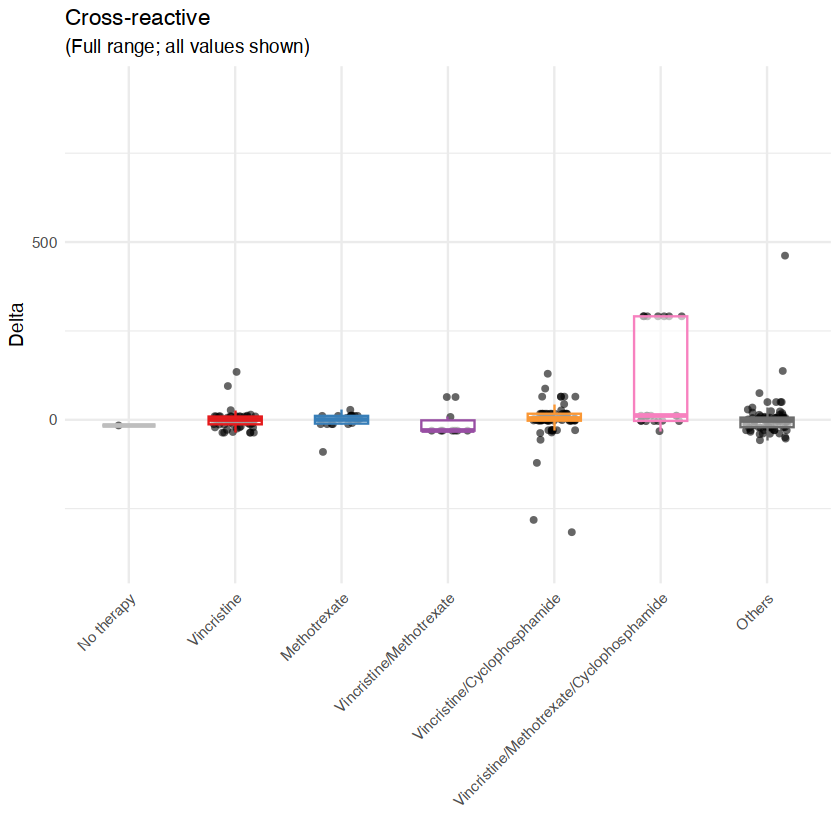

In [92]:
p_box_cr

In [93]:
# Save plots as pdf and arrange them using cowplot

# Compile all boxplots into a single arranged figure
library(cowplot)

# Arrange plots (one row, 5 plots)
combined_boxplots <- plot_grid(
  p_box_hs, p_box_vir, p_box_bact, p_box_cr, p_box_unknown,
  #labels = c("HomoSapiens", "Viral", "Bacterial", "Cross-reactive", "Unknown"),
  ncol = 3, align = "v", axis = "tblr"
) 

# Save to PDF
pdf(paste0(plotpath, "gliph_boxplot_exposed_regimen_all_antigen_classes.pdf"), width = 12, height = 12)
print(combined_boxplots)
dev.off()



Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




pdf 
  2

In [94]:

# # Arrange plots (one row, 5 plots)
# combined_boxplots <- plot_grid(
#   p_box_hs, p_box_vir, 
#   #labels = c("HomoSapiens", "Viral", "Bacterial", "Cross-reactive", "Unknown"),
#   ncol = 2, align = "v", axis = "tblr", labels = "B"
# ) 

# # Save to PDF
# pdf(paste0(plotpath, "gliph_boxplot_exposed_regimen_hs_vir.pdf"), width = 12, height = 6)
# print(combined_boxplots)
# dev.off()

In [636]:
soc_good[ soc_good$Patient == "CHP_381",1:15]

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Drugs,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Drugs,Cycle 2 Duration (days),Cycle 2 Steroids,Cycle 3 Type,Cycle 3 Drugs,Cycle 3 Duration (days),Cycle 3 Steroids,Cycle 4 Type
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
381,Ewings,Induction,"Vincristine, Doxorubicin, Cyclophosphamide",84,no,Consolidation,"Ifosphamide, Etoposide *Cycles alternate between these two regimens (cycle 1 and cycle 2)",154,no,NA,NA,NA,NA,NA


In [584]:
tmp <- gliph_out
tmp$type <- NULL

In [585]:
chp405patterns <- top_df$pattern[ top_df$Patient == "CHP_405"]

In [641]:
head(top_df,10)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern,row
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
CHP_405,EVS,X04,X05,5,9.200000,781.5,772.3000,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,1
CHP_413,AGW,X01,X02,2,18.000000,759.0,741.0000,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,30,2
CHP_405,PTL,X04,X05,5,9.200000,471.0,461.8000,0,Others,...,0,0,0,0,0,0,Cross-reactive,30,32,3
CHP_418,LRGA,X01,X02,2,13.666667,424.0,410.3333,0,Cyclophosphamide,...,0,0,0,0,1,0,Viral,30,31,4
CHP_403,EVS,X02,X03,3,3.800000,295.5,291.7000,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,HomoSapiens,30,29,5
CHP_403,PES,X02,X03,3,4.000000,295.5,291.5000,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,Unknown,30,29,6
CHP_403,GEGS,X02,X03,3,4.125000,295.5,291.3750,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,HomoSapiens,30,29,7
CHP_403,LGK,X02,X03,3,4.125000,295.5,291.3750,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,Cross-reactive,30,31,8
CHP_403,EVSS,X02,X03,3,4.375000,295.5,291.1250,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,Unknown,30,29,9


In [524]:
head(top_df[ top_df$Patient == "CHP_405",], 5)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern,row
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
CHP_405,EVS,X04,X05,5,9.2,781.5,772.3,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,1
CHP_405,PTL,X04,X05,5,9.2,471.0,461.8,0,Others,...,0,0,0,0,0,0,Cross-reactive,30,32,3
CHP_405,GWA,X04,X05,5,9.2,277.5,268.3,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,71
CHP_405,WAE,X04,X05,5,9.2,146.5,137.3,0,Others,...,0,1,0,0,0,0,Cross-reactive,30,29,75
CHP_405,AEV,X04,X05,5,9.2,59.0,49.8,0,Others,...,0,0,0,0,1,0,Viral,30,29,160


In [ ]:
# ptl <- tmp[tmp$pattern %in% chp405patterns,]
# ptl <- ptl[grepl("Human", ptl$subject),]

In [586]:
# ptl$Sample

In [587]:
# evs <- tmp[tmp$pattern == "EVS",]
# evs[grepl("Human", evs$Sample),]

In [588]:
# evs$Sample[grepl("Human", evs$Sample)]

In [209]:
# evs[grepl("CHP_405", evs$Sample),]

In [82]:
# pairwise_results %>% dplyr::mutate(p.adj = round(p.adj, 5)) %>% dplyr::arrange(p.adj)

In [ ]:
# tmp <- df_sub[ df_sub$antigen == "HomoSapiens",]

In [107]:
# table(df_sub$exposed_regimen)

In [108]:
# pairwise.wilcox.test(tmp$Delta, tmp$exposed_regimen, p.adjust.method = "BH", exact = FALSE)

# look up CML paper for sequences

In [642]:
temp <- gliph_out[ gliph_out$pattern %in% "PTL",]

In [589]:
gliph_405 <- gliph_out[ gliph_out$pattern %in% chp405patterns,]

In [591]:
humanpatternsfor405 <- gliph_405[grepl("Human", gliph_405$subject),]

In [656]:
humanpatternsfor405[ grepl("VVLSWAPPV", humanpatternsfor405$Sample),]

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
9585,EVS,0.98,39,49,2.1e-07,1,0.99,0.2,0.048,2.2e-05,motif-EVS,CASSEVSVLYEQYF,TRBV2,NA,NA,Human:A*02__FNDC3B__p.L3M__TRUE__VVLSWAPPV,1,Human


In [592]:
unique(humanpatternsfor405$Sample)

[1] "Human:A*02:01__ATP8B2__SF3B1-p.R625C-Induced-AltSplicing__NA__AALPILFQV"           
 [2] "Human:A*02:01__MAPK8IP2__SF3B1-p.R625S-Induced-AltSplicing__NA__RLPGVLPRA"         
 [3] "Human:A*02:01__PORCN__p.H346Y__FALSE__LLHGFSFYL"                                   
 [4] "Human:A*02:01__MAPK8IP2__SF3B1-p.R625C-Induced-AltSplicing__NA__RLPGVLPRA"         
 [5] "Human:NA__SNRPB__p.S56F__FALSE__CDCDEFRKIKPKNFKQAERE"                              
 [6] "Human:MR1__5-OP-RU__WT__TRUE__NonConventional"                                     
 [7] "Human:NA__MAA__NA__NA__NA"                                                         
 [8] "Human:B*15:01__TYR__WT__TRUE__RLPSSADVEF"                                          
 [9] "Human:DRB1__KIF4B__p.R744K__NA__GIAARVKNWL"                                        
[10] "Human:A*02:01__MLANA__WT__TRUE__AAGIGILTV"                                         
[11] "Human:A*02__PGM5__p.H469Y__FALSE__AVGSYVYSV"                                       
[12] "Human:A*02:01__MLANA-orBST2-orIMP2__WT__TRUE__EAAGIGILTV-orLLLGIGILVL-orNLSALGIFST"
[13] "Human:NA__H3F3B__p.A48T__NA__VKKPHRYRPGTVTLREIRRYQKSTE"                            
[14] "Human:DRB5*01:01__KRAS__p.G12V__NA__MTEYKLVVVGAVGVGKSALT"                          
[15] "Human:A*02__PIGN__p.P824H__FALSE__FLTVFSHFM"                                       
[16] "Human:A*24:02__PPM1F__p.C259Y__NA__VYALIAGATL"                                     
[17] "Human:A*02__GANAB__p.S5F__FALSE__ALYGFVPVL"                                        
[18] "Human:A*02:01__EXOC8__p.Q656P__NA__IILVAVPHV"                                      
[19] "Human:A*02__FNDC3B__p.L3M__TRUE__VVLSWAPPV"                                        
[20] "Human:A*02__HTR1F__WT__TRUE__VMPFSIVYIV"                                           
[21] "Human:NA__HHAT__p.R132P__FALSE__NA"

In [593]:
# Read in Supplementary Table 2 from blood866830-suppl2 (assumed to be in Excel format)
# You may need to change 'filename' to the path where you have saved the supplement file.
# Example filename: "blood866830-suppl002.xlsx"
library(readxl)
supp2_path <- "/Users/anabbi/Downloads/blood866830-suppl2.xlsx"
supp2 <- readxl::read_excel(path = supp2_path, sheet = 1)
supp2_sheet2 <- readxl::read_excel(path = supp2_path, sheet = 2)



In [594]:
# supps <- rbind(supp2, supp2_sheet2)

In [595]:
protein_names <- unique(sapply(strsplit(unique(humanpatternsfor405$Sample), "_"), function(x) x[3]))

In [644]:
protein_names

[1] "ATP8B2"              "MAPK8IP2"            "PORCN"              
 [4] "MAPK8IP2"            "SNRPB"               "5-OP-RU"            
 [7] "MAA"                 "TYR"                 "KIF4B"              
[10] "MLANA"               "PGM5"                "MLANA-orBST2-orIMP2"
[13] "H3F3B"               "KRAS"                "PIGN"               
[16] "PPM1F"               "GANAB"               "EXOC8"              
[19] "FNDC3B"              "HTR1F"               "HHAT"

In [597]:
# To get accession ids from Uniprot for a set of protein names, use the Uniprot.ws or rentrez or biomaRt package.
# Here's an example using Uniprot.ws:

# BiocManager::install("UniProt.ws") # Uncomment if not installed
library(UniProt.ws)

# Instantiate UniProt.ws object
up <- UniProt.ws(taxId=9606) # taxId=9606 for human


In [598]:
# You may need to customize the keys and columns according to your needs.
# Here, we use 'GENENAME' as keytype and get 'UNIPROTKB' accession(s)
res <- select(up, keys=protein_names, columns="accession", keytype="Gene_Name")

Warning message:
"IDs not mapped: MLANA-orBST2-orIMP2, 5-OP-RU"


In [602]:
peptides <- sapply(strsplit(unique(humanpatternsfor405$Sample), "_"), tail, 1)

In [604]:
# Create a dataframe mapping unique peptide sequences and protein names for patient 405
sample_strings <- unique(humanpatternsfor405$Sample)
peptides <- sapply(strsplit(sample_strings, "_"), tail, 1)
protein_names <- sapply(strsplit(sample_strings, "_"), function(x) x[3])
peptide_protein_df <- data.frame(
  peptide = peptides,
  protein = protein_names,
  stringsAsFactors = FALSE
)

In [612]:
peptide_protein_df_split <- peptide_protein_df |>
  tidyr::separate_rows(peptide, protein, sep = "-")
peptide_protein <-peptide_protein_df_split |>
  dplyr::filter(!peptide %in% c("NA", "NonConventional"))


In [615]:
# Remove % or - characters from either column in peptide_protein
peptide_protein$peptide <- gsub("or", "", peptide_protein$peptide)
peptide_protein$protein <- gsub("or", "", peptide_protein$protein)


In [616]:
peptide_protein

peptide,protein
<chr>,<chr>
AALPILFQV,ATP8B2
RLPGVLPRA,MAPK8IP2
LLHGFSFYL,PORCN
RLPGVLPRA,MAPK8IP2
CDCDEFRKIKPKNFKQAERE,SNRPB
RLPSSADVEF,TYR
GIAARVKNWL,KIF4B
AAGIGILTV,MLANA
AVGSYVYSV,PGM5


In [645]:
# # Find best matching peptide in supp2, allowing for (approximate) string matching using stringdist
# # We'll match peptide_protein$peptide against the peptide column in supp2 (e.g. "Sequence" or similar)
# library(stringdist)

# peptide_colname <- if ("Peptide" %in% colnames(supp2)) "Peptide" else if ("Sequence" %in% colnames(supp2)) "Sequence" else colnames(supp2)[1]
# supp2_seqs <- as.character(supp2[[peptide_colname]])

# # You can adjust 'method' below (e.g., "lv" for Levenshtein, "hamming", etc.)
# # and set a threshold for maximum allowed distance
# stringdist_method <- "lv"
# max_dist_threshold <- 2 # set as desired (e.g., max 2 substitutions/indels allowed)

# best_matches <- lapply(peptide_protein$peptide, function(p) {
#   dists <- stringdist::stringdist(p, supp2_seqs, method = stringdist_method)
#   if (any(dists <= max_dist_threshold)) {
#     match_idx <- which(dists == min(dists) & dists <= max_dist_threshold)
#     supp2[match_idx, , drop=FALSE]
#   } else {
#     data.frame()
#   }
# })

# names(best_matches) <- peptide_protein$peptide

# # Example: Show matches for each peptide (first match only for preview)
# lapply(best_matches, function(df) if (nrow(df) > 0) head(df, 1) else NULL)


In [646]:
# # Find best matching peptide in supp2, allowing for (approximate) string matching using stringdist
# # We'll match peptide_protein$peptide against the peptide column in supp2 (e.g. "Sequence" or similar)
# library(stringdist)

# peptide_colname <- if ("Peptide" %in% colnames(supp2)) "Peptide" else if ("Sequence" %in% colnames(supp2)) "Sequence" else colnames(supp2)[1]
# supp2_seqs <- as.character(supp2_sheet2[[peptide_colname]])

# # You can adjust 'method' below (e.g., "lv" for Levenshtein, "hamming", etc.)
# # and set a threshold for maximum allowed distance
# stringdist_method <- "lv"
# max_dist_threshold <- 2 # set as desired (e.g., max 2 substitutions/indels allowed)

# best_matches <- lapply(peptide_protein$peptide, function(p) {
#   dists <- stringdist::stringdist(p, supp2_seqs, method = stringdist_method)
#   if (any(dists <= max_dist_threshold)) {
#     match_idx <- which(dists == min(dists) & dists <= max_dist_threshold)
#     supp2[match_idx, , drop=FALSE]
#   } else {
#     data.frame()
#   }
# })

# names(best_matches) <- peptide_protein$peptide

# # Example: Show matches for each peptide (first match only for preview)
# lapply(best_matches, function(df) if (nrow(df) > 0) head(df, 1) else NULL)


In [647]:
# Match and add protein names from 'res' to the matching rows in supp2
matched_idx <- supp2$`Protein Accessions` %in% res$Entry
supp2_matched <- supp2[matched_idx, ]
# Add the Uniprot Gene_Name (protein symbol) corresponding to the Entry
# Match res$Entry to supp2$`Protein Accessions`
supp2_matched$Gene_Name <- res$From[match(supp2_matched$`Protein Accessions`, res$Entry)]

In [650]:
# Match and add protein names from 'res' to the matching rows in supp2_sheet2
matched_idx <- supp2_sheet2$`Protein Accessions` %in% res$Entry
supp2_sheet2_matched <- supp2_sheet2[matched_idx, ]
# Add the Uniprot Gene_Name (protein symbol) corresponding to the Entry
# Match res$Entry to supp2_sheet2$`Protein Accessions`
supp2_sheet2_matched$Gene_Name <- res$From[match(supp2_sheet2_matched$`Protein Accessions`, res$Entry)]

In [648]:
table(supp2_matched$Dignity)


            benign benign (CML MR4.0) benign (CML MR4.5) benign (CML MR5.0) 
               131                  3                  4                  4 
         malignant 
                19 

In [651]:
supp2_sheet2_matched[ supp2_sheet2_matched$Dignity == "malignant",]

Sequence,Number of Identified Peptide Spectrum Matches (PSMs),Protein Accessions,Modifications,Area,q-Value,Posterior Error Probability (PEP),IonScore - Mascot Score,Xcorr - Sequest Score,Charge,MH+ [Da],ΔM [ppm],Source,Cell Type,Dignity,Spectrometer,Gene_Name
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
SAPSTGGVKKPHRYRPGTV,9,P84243,NA,40610283,0.000,2.927e-03,19.41,NA,3,1995.089,0.2145115,UPN 05,CML,malignant,XL,H3F3B
SAPSTGGVKKPHRYRPGTVA,2,P84243,NA,15383101,0.002,2.315e-02,13.98,NA,3,2066.127,0.7928107,UPN 05,CML,malignant,XL,H3F3B
PSTGGVKKPHRYRPGTV,1,P84243,NA,2159899,0.000,2.834e-03,28.18,NA,3,1837.019,-0.2337236,UPN 10,CML,malignant,XL,H3F3B
VMTPQGRGTVAAAAAAAT,1,P14678,NA,4134525,0.005,2.984e-02,29.01,NA,2,1643.854,0.1301783,UPN 11,CML,malignant,XL,SNRPB
SAPSTGGVKKPHRYRPGTV,1,P84243,NA,9648101,0.008,9.718e-02,11.19,NA,3,1995.089,0.1227334,UPN 14,CML,malignant,XL,H3F3B
LGQRYSLLPFWYTLLYQAHREGIPV,1,Q14697,NA,24613263,0.000,1.275e-04,18.17,NA,4,3020.626,3.6514811,UPN 14,CML,malignant,XL,GANAB
SAPSTGGVKKPHRYRPGTV,3,P84243,NA,9808396,0.000,5.673e-03,21.55,NA,3,1995.088,-0.2443791,UPN 17,CML,malignant,XL,H3F3B
NLDVFQYELYNPMAL,9,Q14697,NA,21652158,0.000,1.710e-07,87.11,NA,2,1829.880,0.9032837,UPN 20,CML,malignant,XL,GANAB
NLDVFQYELYNPM,6,Q14697,NA,25593513,0.000,4.534e-07,71.22,NA,2,1645.758,0.8403054,UPN 20,CML,malignant,XL,GANAB


In [649]:
supp2_matched[ supp2_matched$Dignity == "malignant",]

Sequence,Number of Identified Peptide Spectrum Matches (PSMs),Protein Accessions,Modifications,Area,q-Value,Posterior Error Probability (PEP),IonScore - Mascot Score,Xcorr - Sequest Score,Charge,...,Source,Cell Type,HLA Type of Soure,Dignity,Spectrometer,Best scored HLA Allele by SYFPEITHI,SYFPEITHI Score (% of max. Score),Best scored HLA Allele by NetMHCpan 3.0,NetMHCpan 3.0 Score (% Rank),Gene_Name
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
AVAAVAARR,4,Q14697,NA,2924186.0,0.002,5.508e-03,38.70,NA,2,...,UPN 07,CML,"A*02, A*03, B*13, B*15, C*03, C*06",malignant,XL,NA,NA,A*03:01,1.40,GANAB
AVAAVAARR,4,Q14697,NA,2121488.5,0.003,4.402e-02,32.90,NA,2,...,UPN 09,CML,"A*03, B*07, B*35, C*04, C*07",malignant,XL,NA,NA,A*03:01,1.40,GANAB
AVAAVAARR,10,Q14697,NA,11748738.5,0.001,3.389e-03,39.81,NA,2,...,UPN 11,CML,"A*03, B*35, B*35, C*04",malignant,XL,NA,NA,A*03:01,1.40,GANAB
AVAAVAARR,1,Q14697,NA,786851.6,0.007,2.925e-02,29.64,NA,2,...,UPN 17,CML,"A*03:01, A*23:01, B*07:02, B*18:01, C*07:02, C*07:01",malignant,XL,NA,NA,A*03:01,1.40,GANAB
LEFEHQRAP,11,Q14697,NA,5180479.7,0.000,1.058e-03,43.06,NA,2,...,UPN 08,CML,"A*01, A*02, B*08, B*50, C*06, C*07",malignant,XL,NA,NA,B*50:01,0.70,GANAB
NAVQILEQF,4,O95427,NA,2142783.3,0.000,3.137e-03,33.88,NA,2,...,UPN 10,CML,"A*02, A*11, B*35, B*44, C*04",malignant,XL,NA,NA,B*35:01,0.60,PIGN
AVAAVAARR,2,Q14697,NA,4952937.3,0.010,6.356e-02,28.61,NA,2,...,UPN 14,CML,"A*02, A*11, B*35, B*44, C*04",malignant,XL,A*11:01,70.59,A*11:01,0.60,GANAB
AVAAVAARR,18,Q14697,NA,13335372.8,0.001,9.150e-04,48.36,NA,2,...,UPN 18,CML,"A*11:01, A*02:20, B*27:05, B*44:02, C*01:02, C*05:02",malignant,XL,A*11:01,70.59,A*11:01,0.60,GANAB
AVAAVAARR,17,Q14697,NA,10782475.8,0.000,5.012e-04,42.29,NA,2,...,UPN 19,CML,"A*02, A*11, B*07, B*51, C*07",malignant,XL,A*11:01,70.59,A*11:01,0.60,GANAB


In [ ]:
VVLSWAPPV

In [655]:
supp2_matched[ supp2_matched$Gene_Name == "FNDC3B",]

Sequence,Number of Identified Peptide Spectrum Matches (PSMs),Protein Accessions,Modifications,Area,q-Value,Posterior Error Probability (PEP),IonScore - Mascot Score,Xcorr - Sequest Score,Charge,...,Source,Cell Type,HLA Type of Soure,Dignity,Spectrometer,Best scored HLA Allele by SYFPEITHI,SYFPEITHI Score (% of max. Score),Best scored HLA Allele by NetMHCpan 3.0,NetMHCpan 3.0 Score (% Rank),Gene_Name
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
RQIDRQNRL,1,Q53EP0,NA,5469727.1,0.041,2.216e-01,NA,1.324460,3,...,Bone marrow 15,Bone morrow,"A*02:05, A*11:01, B*40:02, B*58:01, C*02:02, C*07:01",benign,Lumos,C*02:02,64.29,C*07:01,1.10,FNDC3B
TDYHVRVY,3,Q53EP0,NA,2620263.5,0.000,1.429e-02,NA,1.380377,2,...,Bone marrow 17,Bone morrow,"A*01:01, A*02:01, B*08:01, B*44:02, C*07:01, C*07:04",benign,Lumos,NA,NA,A*01:01,1.00,FNDC3B
FPYSYEVAL,5,Q53EP0,NA,25604463.4,0.009,5.009e-02,NA,1.228752,2,...,Bone marrow 18,Bone morrow,"A*03, A*24, C*04, C*16",benign,Lumos,NA,NA,C*16:01,0.40,FNDC3B
SESLPVRTL,6,Q53EP0,NA,34803167.6,0.002,8.899e-03,NA,2.624263,2,...,Bone marrow 15,Bone morrow,"A*02:05, A*11:01, B*40:02, B*58:01, C*02:02, C*07:01",benign,Lumos,B*40:02,75.76,B*40:02,0.30,FNDC3B
GPFSQFIKA,1,Q53EP0,NA,339702.1,0.031,1.415e-01,NA,1.729180,2,...,Granulocytes 02,Granulocytes,"A*02, A*24, B*35, B*55, C*03, C*04",benign,Lumos,NA,NA,B*55:01,0.20,FNDC3B
SESLPVRTL,1,Q53EP0,NA,11586324.2,0.002,2.633e-02,NA,1.674986,2,...,Granulocytes 05,Granulocytes,"A*01, A*23, B*44, C*04",benign,Lumos,B*44:02,70.27,B*44:02,0.20,FNDC3B
ILWETVPSM,25,Q53EP0,NA,18837700.1,0.002,1.257e-02,39.62,NA,2,...,UPN 10,CML,"A*02, A*11, B*35, B*44, C*04",malignant,XL,A*02:01,72.22,A*02:01,0.17,FNDC3B
ILWETVPSM,8,Q53EP0,M9(Oxidation),21346044.9,0.003,1.018e-02,NA,2.253525,2,...,Bone marrow 14,Bone morrow,"A*02:01, A*11:01, B*15:01, B*35:01, C*03:04, C*04:01",benign,Lumos,A*02:01,72.22,A*02:01,0.17,FNDC3B
ILWETVPSM,8,Q53EP0,M9(Oxidation),20479844.4,0.002,1.019e-02,NA,2.304026,2,...,Bone marrow 16,Bone morrow,"A*02:01, A*68:02, B*14:02, B*27:05, C*02:02, C*08:02",benign,Lumos,A*02:01,72.22,A*02:01,0.17,FNDC3B


In [570]:
dim(supp2_sheet2[ supp2_sheet2$`Protein Accessions` %in% res$Entry,])

[1] 103  16

[1] 161  21

# 3 - clone track gliph and network of the most sig groups

In [210]:
samples_tcr <- readr::read_rds(file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_stat.rds"))
gliphdf <- readr::read_rds( file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_stat.rds"))

In [348]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_tigerdb_cleaned.rds"))

In [212]:
chp_gliph <- gliph_out[ grepl("CHP", gliph_out$Sample), ]
# chp_gliph <- chp_gliph[!grepl("Normal", chp_gliph$subject),]

In [213]:
chp_gliph_pbmc <- chp_gliph[grepl("PBMC", chp_gliph$Sample),]

In [214]:
chp_gliph_pbmc$Patient <- meta_div$Patient[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cycle <- meta_div$cycle[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$sampletype <- meta_div$sampletype[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$cancergroup <- meta_div$cancergroup[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$regimen <- meta_div$regimen[match(chp_gliph_pbmc$Sample, meta_div$basename)]
chp_gliph_pbmc$exposed_regimen <- meta_div$exposed_regimen[match(chp_gliph_pbmc$Sample, meta_div$basename)]

In [215]:
# get patients with more than one pair of consecutive timepoiints
mytab <- table(chp_gliph_pbmc$Patient, chp_gliph_pbmc$cycle)
# Find patients with at least one pair of consecutive timepoints (e.g., X01-X02, X02-X03, etc)
consecutive_matrix <- mytab > 0
# Only keep rows with at least one pair of adjacent TRUE values
consecutive_matrix <- consecutive_matrix[apply(consecutive_matrix, 1, function(x) any(x[-length(x)] & x[-1])), , drop = FALSE]

baseline_patients <- rownames(consecutive_matrix)

In [216]:
length(baseline_patients)

[1] 48

In [217]:
df1 <- chp_gliph_pbmc[chp_gliph_pbmc$Patient %in% baseline_patients, ]

In [218]:
table(df1$cycle)


  X01   X02   X03   X04   X05 
 6072 11932  9264  4794  5061 

In [219]:
# separate pre and post
df1_pre <- df1[ df1$cycle == "X01",]
df1_x02 <- df1[ df1$cycle == "X02",]
df1_x03 <- df1[ df1$cycle == "X03",]
df1_x04 <- df1[ df1$cycle == "X04",]
df1_x05 <- df1[ df1$cycle == "X05",]

In [220]:
dim(df1_pre)

[1] 6072   25

In [221]:
# group by samples and patterns, avergae the frequencies, if there is > 1 CDR3s in a pattern. do it for all cycles
df1_pre <- df1_pre %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x02 <- df1_x02 %>%  
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x03 <- df1_x03 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x04 <- df1_x04 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%
  ungroup()
df1_x05 <- df1_x05 %>%
  group_by(Sample, pattern) %>%
  summarise(MeanFreq = mean(Freq), .groups = 'drop') %>%  
  ungroup()

In [222]:
head(df1_pre)

Sample,pattern,MeanFreq
<chr>,<chr>,<dbl>
CHP-369-01-PBMC-DNA,%AGTENTE,130
CHP-369-01-PBMC-DNA,%AGTGGYE,482
CHP-369-01-PBMC-DNA,%ESKGNQP,201
CHP-369-01-PBMC-DNA,%ETGENTE,23
CHP-369-01-PBMC-DNA,%FRDRGVRE,1212
CHP-369-01-PBMC-DNA,%FVTGE,584


In [223]:
# df1_pre$Regimen <- meta_div$regimen[match(df1_pre$Sample, meta_div$basename)]
# df1_x02$Regimen <- meta_div$regimen[match(df1_x02$Sample, meta_div$basename)]
# df1_x03$Regimen <- meta_div$regimen[match(df1_x03$Sample, meta_div$basename)]
# df1_x04$Regimen <- meta_div$regimen[match(df1_x04$Sample, meta_div$basename)]
# df1_x05$Regimen <- meta_div$regimen[match(df1_x05$Sample, meta_div$basename)]

df1_pre$exposed_regimen <- meta_div$exposed_regimen[match(df1_pre$Sample, meta_div$basename)]
df1_x02$exposed_regimen <- meta_div$exposed_regimen[match(df1_x02$Sample, meta_div$basename)]
df1_x03$exposed_regimen <- meta_div$exposed_regimen[match(df1_x03$Sample, meta_div$basename)]
df1_x04$exposed_regimen <- meta_div$exposed_regimen[match(df1_x04$Sample, meta_div$basename)]
df1_x05$exposed_regimen <- meta_div$exposed_regimen[match(df1_x05$Sample, meta_div$basename)]

df1_pre$cancergroup <- meta_div$cancergroup[match(df1_pre$Sample, meta_div$basename)]
df1_x02$cancergroup <- meta_div$cancergroup[match(df1_x02$Sample, meta_div$basename)]
df1_x03$cancergroup <- meta_div$cancergroup[match(df1_x03$Sample, meta_div$basename)]
df1_x04$cancergroup <- meta_div$cancergroup[match(df1_x04$Sample, meta_div$basename)]
df1_x05$cancergroup <- meta_div$cancergroup[match(df1_x05$Sample, meta_div$basename)]


In [224]:
df1_pre$Disease_type <- meta_div$Disease_type[match(df1_pre$Sample, meta_div$basename)]
df1_x02$Disease_type <- meta_div$Disease_type[match(df1_x02$Sample, meta_div$basename)]
df1_x03$Disease_type <- meta_div$Disease_type[match(df1_x03$Sample, meta_div$basename)]
df1_x04$Disease_type <- meta_div$Disease_type[match(df1_x04$Sample, meta_div$basename)]
df1_x05$Disease_type <- meta_div$Disease_type[match(df1_x05$Sample, meta_div$basename)]

df1_pre$Patient <- meta_div$Patient[match(df1_pre$Sample, meta_div$basename)]
df1_x02$Patient <- meta_div$Patient[match(df1_x02$Sample, meta_div$basename)]
df1_x03$Patient <- meta_div$Patient[match(df1_x03$Sample, meta_div$basename)]
df1_x04$Patient <- meta_div$Patient[match(df1_x04$Sample, meta_div$basename)]
df1_x05$Patient <- meta_div$Patient[match(df1_x05$Sample, meta_div$basename)]


In [225]:
# Requirements
library(dplyr)
library(tidyr)
library(tibble)

# 1) Standardize the five dfs (accept either Freq or MeanFreq) and bind with explicit cycle labels
standardize_cycle_df <- function(df, cycle_label) {
  has_meanfreq <- "MeanFreq" %in% colnames(df)
  out <-  df %>% select(Sample, pattern, Patient,MeanFreq, exposed_regimen)
  out$cycle <- cycle_label
  out
}

df_list <- list(
  X01 = df1_pre,
  X02 = df1_x02,
  X03 = df1_x03,
  X04 = df1_x04,
  X05 = df1_x05
)

df_all <- do.call(rbind, lapply(names(df_list), function(nm) standardize_cycle_df(df_list[[nm]], nm)))


In [226]:
head(df_all)

Sample,pattern,Patient,MeanFreq,exposed_regimen,cycle
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
CHP-369-01-PBMC-DNA,%AGTENTE,CHP_369,130,baseline,X01
CHP-369-01-PBMC-DNA,%AGTGGYE,CHP_369,482,baseline,X01
CHP-369-01-PBMC-DNA,%ESKGNQP,CHP_369,201,baseline,X01
CHP-369-01-PBMC-DNA,%ETGENTE,CHP_369,23,baseline,X01
CHP-369-01-PBMC-DNA,%FRDRGVRE,CHP_369,1212,baseline,X01
CHP-369-01-PBMC-DNA,%FVTGE,CHP_369,584,baseline,X01


In [227]:
sample_pat_map <- df_all[, c("Sample", "Patient","cycle", "exposed_regimen")]
sample_pat_map <- unique(sample_pat_map)

In [229]:
to_num <- function(x) as.integer(gsub("\\D", "", x))
df_pc2 <- df_all %>% mutate(cycle_num = to_num(cycle))

In [230]:
head(df_pc2)

Sample,pattern,Patient,MeanFreq,exposed_regimen,cycle,cycle_num
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>
CHP-369-01-PBMC-DNA,%AGTENTE,CHP_369,130,baseline,X01,1
CHP-369-01-PBMC-DNA,%AGTGGYE,CHP_369,482,baseline,X01,1
CHP-369-01-PBMC-DNA,%ESKGNQP,CHP_369,201,baseline,X01,1
CHP-369-01-PBMC-DNA,%ETGENTE,CHP_369,23,baseline,X01,1
CHP-369-01-PBMC-DNA,%FRDRGVRE,CHP_369,1212,baseline,X01,1
CHP-369-01-PBMC-DNA,%FVTGE,CHP_369,584,baseline,X01,1


In [241]:
from <- df_pc2 %>%
  transmute(
    Patient, pattern,
    cycle_from = cycle,
    cycle_num_from = cycle_num,
    MeanFreq_from = MeanFreq,
    next_cycle_num = cycle_num + 1L
  )

to <- df_pc2 %>%
  transmute(
    Patient, pattern,
    cycle_to = cycle,
    cycle_num_to = cycle_num,
    MeanFreq_to = MeanFreq
  )

# Safe inner join: (Patient, pattern, next_cycle_num) -> (Patient, pattern, cycle_num_to)
delta_long <- from %>%
  inner_join(to, by = c("Patient", "pattern", "next_cycle_num" = "cycle_num_to")) %>%
  transmute(
    Patient, pattern,
    cycle_from, cycle_to, next_cycle_num,
    MeanFreq_from, MeanFreq_to,
    Delta = MeanFreq_to - MeanFreq_from
  )

In [242]:
length(unique(delta_long$Patient))

[1] 40

In [243]:
length(unique(delta_long$pattern))

[1] 189

In [244]:
delta_long[ delta_long$Patient == "CHP_405" & delta_long$pattern == "VLR",]

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
CHP_405,VLR,X01,X02,2,2.833333,9.0,6.166667
CHP_405,VLR,X02,X03,3,9.000000,10.0,1.000000
CHP_405,VLR,X03,X04,4,10.000000,9.2,-0.800000
CHP_405,VLR,X04,X05,5,9.200000,59.0,49.800000


In [245]:
head(gliphdf)

,gliph,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,SP,HTLV1,YFV,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCP,SCP,0,0,0,0,0,0,0,0,0,0,0,0,0,657
SERA,SERA,0,0,0,0,0,0,0,0,0,0,0,0,0,656
TVL,TVL,0,0,0,0,0,3,1,0,0,0,0,0,0,646
LFF,LFF,0,0,0,0,0,1,0,0,0,0,0,0,0,660
SSER,SSER,0,0,0,0,0,0,0,0,0,0,0,0,0,657
KEAV,KEAV,0,0,0,0,0,0,0,0,0,0,0,0,0,630


In [246]:
library(dplyr)

# fisher per pattern (choose best/lowest fisher if duplicated)
pattern_fisher <- df1 %>%
    distinct(pattern, Fisher_score) %>%
    group_by(pattern) %>%
    summarise(fisher = suppressWarnings(min(Fisher_score, na.rm = TRUE)), .groups = "drop") %>%
    mutate(fisher = ifelse(is.infinite(fisher), NA_real_, fisher))

# regimen per Patient x cycle (for the "to" cycle)
regimen_pc <- sample_pat_map %>%
    select(Patient, cycle, exposed_regimen) %>%
    group_by(Patient, cycle) %>%
    summarise(exposed_regimen = dplyr::first(na.omit(exposed_regimen)), .groups = "drop")

# antigen flags by pattern (gliphdf keyed by `gliph`)
ant_lookup <- gliphdf %>%
    select(gliph, CMV, Influenza, HCV, EBV, HPV, Human, CEF, HSV, TB, SP, MCPyV, YFV) %>%
    rename(Flu = Influenza, HS = Human)

# attach directly to delta_long
delta_long <- delta_long %>%
    left_join(pattern_fisher, by = "pattern") %>%
    left_join(regimen_pc, by = c("Patient", "cycle_to" = "cycle")) %>%
    left_join(ant_lookup, by = c("pattern" = "gliph"))

# (Optional) derive categorical antigen label for plotting shape
viral_cols     <- c("CMV", "Flu", "HCV", "EBV", "HPV", "MCPyV", "HSV", "YFV")
bacterial_cols <- c("TB", "SP")

delta_long$antigen <- "Unknown"
delta_long$antigen[rowSums(delta_long[, viral_cols],     na.rm = TRUE) > 0] <- "Viral"
delta_long$antigen[rowSums(delta_long[, bacterial_cols], na.rm = TRUE) > 0] <- "Bacterial"
delta_long$antigen[delta_long$HS > 0] <- "HomoSapiens"
delta_long$antigen[
    (delta_long$HS > 0) &
    (rowSums(delta_long[, c(viral_cols, bacterial_cols)], na.rm = TRUE) > 0)
] <- "Cross-reactive"

In [247]:
summary(delta_long$Delta)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-465.000  -12.633    0.750    7.237   10.000  772.300 

In [248]:
quantiles <- quantile(delta_long$Delta, c(0.1, 0.9))

In [249]:
min(delta_long$fisher[ delta_long$fisher > 0])

[1] 5.4e-29

In [250]:
delta_long$log10fisher <- -log10(delta_long$fisher + 1e-30)

In [251]:
pattern_patient_count <- delta_long %>%
  dplyr::distinct(Patient, pattern) %>%
  dplyr::count(pattern, name = "n_patients_with_pattern")

# Attach to delta_long
delta_long <- delta_long %>%
  dplyr::left_join(pattern_patient_count, by = "pattern")


In [252]:
head(pattern_patient_count)

pattern,n_patients_with_pattern
<chr>,<int>
%DSNQP,1
%GGSSYE,1
%LDRNTE,1
%LGQNTE,1
%RGGSYE,1
%RLNTE,1


In [253]:
# length(unique(delta_long[ delta_long$pattern == "AEVS",]$Patient))

In [254]:
head(delta_long)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,HS,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CHP_369,AEV,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,1,0,Viral,30,29
CHP_369,AEVS,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,AGW,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,3,0,0,0,0,0,0,HomoSapiens,30,30
CHP_369,AGWA,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,APE,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Viral,30,30
CHP_369,APES,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29


In [255]:
delta_long$exposed_regimen <- factor(delta_long$exposed_regimen, levels = c("No therapy", setdiff(names(colpal), "No therapy")))

In [257]:
summary(delta_long$fisher)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.00514 0.00000 0.70000 

In [ ]:
head(delta_long)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,HS,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
CHP_369,AEV,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,1,0,Viral,30,29
CHP_369,AEVS,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,AGW,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,3,0,0,0,0,0,0,HomoSapiens,30,30
CHP_369,AGWA,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29
CHP_369,APE,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Viral,30,30
CHP_369,APES,X01,X02,2,30.44444,9.5,-20.94444,0,Others,...,0,0,0,0,0,0,0,Unknown,30,29


In [258]:
top_patterns <- delta_long$pattern[ delta_long$fisher < 0.0001 & delta_long$n_patients_with_pattern > 1]

In [291]:
length(unique(top_patterns))

[1] 71

In [261]:
# Build ordered rows from top_patterns and plot
top_df <- delta_long %>%
    dplyr::filter(pattern %in% top_patterns) %>%
    dplyr::arrange(dplyr::desc(Delta)) %>%
    dplyr::mutate(row = dplyr::row_number())

In [269]:
head(top_df[ top_df$Patient == "CHP_405",])

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern,row
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
CHP_405,EVS,X04,X05,5,9.2,781.5,772.3,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,1
CHP_405,PTL,X04,X05,5,9.2,471.0,461.8,0,Others,...,0,0,0,0,0,0,Cross-reactive,30,32,3
CHP_405,GWA,X04,X05,5,9.2,277.5,268.3,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,71
CHP_405,WAE,X04,X05,5,9.2,146.5,137.3,0,Others,...,0,1,0,0,0,0,Cross-reactive,30,29,75
CHP_405,AEV,X04,X05,5,9.2,59.0,49.8,0,Others,...,0,0,0,0,1,0,Viral,30,29,160
CHP_405,AEVS,X04,X05,5,9.2,59.0,49.8,0,Others,...,0,0,0,0,0,0,Unknown,30,29,161


In [275]:
head(top_df,10)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern,row
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
CHP_405,EVS,X04,X05,5,9.200000,781.5,772.3000,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,29,1
CHP_413,AGW,X01,X02,2,18.000000,759.0,741.0000,0,Others,...,0,0,0,0,0,0,HomoSapiens,30,30,2
CHP_405,PTL,X04,X05,5,9.200000,471.0,461.8000,0,Others,...,0,0,0,0,0,0,Cross-reactive,30,32,3
CHP_418,LRGA,X01,X02,2,13.666667,424.0,410.3333,0,Cyclophosphamide,...,0,0,0,0,1,0,Viral,30,31,4
CHP_403,EVS,X02,X03,3,3.800000,295.5,291.7000,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,HomoSapiens,30,29,5
CHP_403,PES,X02,X03,3,4.000000,295.5,291.5000,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,Unknown,30,29,6
CHP_403,GEGS,X02,X03,3,4.125000,295.5,291.3750,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,HomoSapiens,30,29,7
CHP_403,LGK,X02,X03,3,4.125000,295.5,291.3750,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,Cross-reactive,30,31,8
CHP_403,EVSS,X02,X03,3,4.375000,295.5,291.1250,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,Unknown,30,29,9


In [267]:
tail(top_df)

Patient,pattern,cycle_from,cycle_to,next_cycle_num,MeanFreq_from,MeanFreq_to,Delta,fisher,exposed_regimen,...,CEF,HSV,TB,SP,MCPyV,YFV,antigen,log10fisher,n_patients_with_pattern,row
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
CHP_362,PTL,X02,X03,3,93.45455,3.00000,-90.45455,0,Methotrexate,...,0,0,0,0,0,0,Cross-reactive,30,32,2539
CHP_328,LRGA,X04,X05,5,180.33333,79.00000,-101.33333,0,Vincristine/Cyclophosphamide,...,0,0,0,0,1,0,Viral,30,31,2540
CHP_328,AVL,X04,X05,5,200.33333,79.00000,-121.33333,0,Vincristine/Cyclophosphamide,...,0,0,0,0,1,0,Cross-reactive,30,30,2541
CHP_412,TGEL,X02,X03,3,165.00000,22.00000,-143.00000,0,Vincristine/Methotrexate/Cyclophosphamide,...,0,0,0,0,0,0,Unknown,30,20,2542
CHP_381,TVL,X01,X02,2,294.00000,12.22222,-281.77778,0,Vincristine/Cyclophosphamide,...,0,0,0,0,0,0,Cross-reactive,30,32,2543
CHP_328,TVL,X04,X05,5,403.66667,87.33333,-316.33333,0,Vincristine/Cyclophosphamide,...,0,0,0,0,0,0,Cross-reactive,30,32,2544


In [263]:
summary(top_df$n_patients_with_pattern)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00   29.00   29.00   29.15   29.00   33.00 

In [264]:
summary(top_df$Delta)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-316.333  -12.333    0.750    8.015   10.000  772.300 

In [ ]:
tab <- as.data.frame.matrix(table(top_df$antigen, top_df$pattern))
(rowSums(tab > 0))
tab

Bacterial Cross-reactive    HomoSapiens        Unknown          Viral 
             1              7             13             41              9

,AEV,AEVS,AGW,AGWA,APE,APES,AVGA,AVL,AVLR,CP,...,TLRG,TVL,TVLG,VGAP,VLGK,VLR,VLRG,VSSC,WAE,WAEV
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Bacterial,0,0,0,0,0,0,39,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cross-reactive,0,0,0,0,0,0,0,40,0,0,...,0,41,0,0,0,0,0,0,37,0
HomoSapiens,0,0,39,0,0,0,0,0,0,39,...,0,0,35,0,0,37,0,0,0,0
Unknown,0,37,0,37,0,37,0,0,37,0,...,0,0,0,37,36,0,37,37,0,37
Viral,37,0,0,0,40,0,0,0,0,0,...,38,0,0,0,0,0,0,0,0,0


In [276]:
soc_good[ soc_good$Patient == "CHP_418",1:20]

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Drugs,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Drugs,Cycle 2 Duration (days),Cycle 2 Steroids,Cycle 3 Type,Cycle 3 Drugs,Cycle 3 Duration (days),Cycle 3 Steroids,Cycle 4 Type,Cycle 4 Drugs,Cycle 4 Duration (days),Cycle 4 Steroids,Cycle 5 Type,Cycle 5 Drugs
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
418,NB,Induction,"Topotecan, Cyclophosphamide",21,no,Induction,"Topotecan, Cyclophosphamide",21,no,Induction,"Cisplatinum, Etoposide",21,no,Induction,"Vincristine, Cyclophosphamide, Doxorubicin",21,no,Induction,"Cisplatinum, Etoposide"


In [349]:
tmp <- gliph_out
tmp$type <- NULL

In [350]:
suppressPackageStartupMessages({
  library(data.table)
  library(igraph)
  library(Matrix)
})

In [351]:
gliph_df <- tmp
chp_gliph

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CEQSPTPRSNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV27,TRBJ2-2P,NA,CHP_398-05_PBMC-DNA,1,CHP_398-05_PBMC-DNA
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CASSLLWTGRNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV27,TRBJ2-2P,NA,CHP_405-04-PBMC-DNA,9,CHP_405-04-PBMC-DNA
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CASSDKTSGGGTGELFFGEGSRLTVLGKEAAGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV6-1,TRBJ2-2P,NA,CHP_382-05_cfDNA,14,CHP_382-05_cfDNA
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CASSPGPTSNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV27,TRBJ2-2P,NA,CHP_331-05-PBMC-DNA,3,CHP_331-05-PBMC-DNA
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CASSLLAGGPNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV9,TRBJ2-2P,NA,CHP_401-05-PBMC-DNA,29,CHP_401-05-PBMC-DNA
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CASSLGLGSGVNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV9,TRBJ2-2P,NA,CHP_338-03-PBMC-DNA,28,CHP_338-03-PBMC-DNA
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CASSQDGQAGDYGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV4-1,TRBJ2-2P,NA,CHP_396-02-PBMC-DNA,1,CHP_396-02-PBMC-DNA
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CASSPGALSNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV4-1,TRBJ2-2P,NA,CHP_381-02-PBMC-DNA,1,CHP_381-02-PBMC-DNA
1,SCP,0,197,657,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-LRGA,CASSPAAGQGLRTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV13,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,2,CHP_405-01_PBMC_DNA


In [352]:
  gliph_df$pattern <- as.character(gliph_df$pattern)
  gliph_df$TcRb    <- as.character(gliph_df$TcRb)
  gliph_df$Sample  <- as.character(gliph_df$Sample)
  gliph_df$Freq    <- suppressWarnings(as.numeric(gliph_df$Freq))
  gliph_df <- gliph_df[is.finite(gliph_df$Freq) & gliph_df$Freq > 0, , drop = FALSE]

In [356]:
external_gliph <- gliph_df[!grepl("CHP", gliph_df$Sample),]

chp_gliph <- gliph_out[ grepl("CHP", gliph_out$Sample), ]
chp_gliph_pbmc <- chp_gliph[grepl("PBMC", chp_gliph$Sample),]
mychp_gliph_pbmc <- chp_gliph_pbmc[grepl("CHP_405", chp_gliph_pbmc$Sample),]

In [357]:
unique(mychp_gliph_pbmc$Sample)

[1] "CHP_405-04-PBMC-DNA" "CHP_405-01_PBMC_DNA" "CHP_405-02_PBMC_DNA"
[4] "CHP_405-05_PBMC-DNA" "CHP_405-03_PBMC-DNA"

In [450]:
head(mychp_gliph_pbmc[ grepl("EVS", mychp_gliph_pbmc$pattern),])

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
57,EVS,0,197,654,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-EVS motif-SSCP motif-VSSC motif-EVSS motif-LRGA motif-SSC,CASSLLWTGRNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV27,TRBJ2-2P,NA,CHP_405-04-PBMC-DNA,9,CHP_405-04-PBMC-DNA
57,EVS,0,197,654,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-EVS motif-SSCP motif-VSSC motif-EVSS motif-LRGA motif-SSC,CASSPAAGQGLRTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV13,TRBJ2-2P,NA,CHP_405-01_PBMC_DNA,2,CHP_405-01_PBMC_DNA
57,EVS,0,197,654,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-EVS motif-SSCP motif-VSSC motif-EVSS motif-LRGA motif-SSC,CATSDLGDSYHTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV24-1,TRBJ2-2P,NA,CHP_405-04-PBMC-DNA,1,CHP_405-04-PBMC-DNA
57,EVS,0,197,654,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-EVS motif-SSCP motif-VSSC motif-EVSS motif-LRGA motif-SSC,CASSSQGYANTGELFFGEGSRLTVLGKEAVRAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV6-5,TRBJ2-2P,NA,CHP_405-02_PBMC_DNA,9,CHP_405-02_PBMC_DNA
57,EVS,0,197,654,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-EVS motif-SSCP motif-VSSC motif-EVSS motif-LRGA motif-SSC,CASSSPWGRGNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV13,TRBJ2-2P,NA,CHP_405-04-PBMC-DNA,31,CHP_405-04-PBMC-DNA
57,EVS,0,197,654,1e-05,1,1,1,1,1e-05,motif-SCP motif-SSER motif-GAVL motif-RGAV motif-VLR motif-CP motif-VLRG motif-AVLR motif-ESSE motif-AVL motif-EVS motif-SSCP motif-VSSC motif-EVSS motif-LRGA motif-SSC,CSARDRGGGRIGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV20-1,TRBJ2-2P,NA,CHP_405-02_PBMC_DNA,9,CHP_405-02_PBMC_DNA


In [402]:
  # Build antigen mapping directly from the single file
  dt <- as.data.table(unique(external_gliph))
  # tstrsplit can return more than 2 fields if there are extra ':' in Sample
  # Assign all fields, then keep the first as Species, the rest (optionally Epitope, etc.) as additional columns
  split_cols <- strsplit(dt$Sample, ":", fixed = TRUE)
  # Only split at the first occurrence of ':'
  split_cols <- lapply(dt$Sample, function(x) {
    parts <- sub(":", "\t", x, fixed = TRUE)
    strsplit(parts, "\t", fixed = TRUE)[[1]]
  })
  split_cols_first <- sapply(split_cols, `[`, 1)
  split_cols_second <- sapply(split_cols, function(x) if(length(x) > 1) x[2] else NA_character_)
  split_cols <- list(split_cols_first, split_cols_second)
  dt[, Species := split_cols[[1]] ]
  dt[, Epitope := if (length(split_cols) >= 2) split_cols[[2]] else NA_character_ ]
  # If you want to keep more columns (e.g. HLA, protein, etc.), can assign them similarly:
  summary_dt <- dt[, .(
    UniqueSpecies = paste(unique(na.omit(Species)), collapse = ",")
  ), by = .(pattern)]

    summary_dt_epitope <- dt[, .(
    UniqueEpitope = paste(unique(na.omit(Epitope)), collapse = ",")
  ), by = .(pattern)]

      summary_dt_external <- dt[, .(
    UniqueExternal = paste(unique(na.omit(Sample)), collapse = ",")
  ), by = .(pattern)]

In [403]:
head(summary_dt_epitope)

pattern,UniqueEpitope
<chr>,<chr>
LFF,A*02:01__ATP8B2__SF3B1-p.R625C-Induced-AltSplicing__NA__AALPILFQV
GEGS,"A*02:01__MAPK8IP2__SF3B1-p.R625S-Induced-AltSplicing__NA__RLPGVLPRA,A*02:01__PORCN__p.H346Y__FALSE__LLHGFSFYL,A*02:01__MAPK8IP2__SF3B1-p.R625C-Induced-AltSplicing__NA__RLPGVLPRA,NA__SNRPB__p.S56F__FALSE__CDCDEFRKIKPKNFKQAERE,MR1__5-OP-RU__WT__TRUE__NonConventional"
FFG,NA__MAA__NA__NA__NA
FFGE,NA__MAA__NA__NA__NA
IWV,NA__MAA__NA__NA__NA
S%SNQP,A*02:01__SEC24A__p.P469L__FALSE__FLYNLLTRV


In [404]:
head(summary_dt)

pattern,UniqueSpecies
<chr>,<chr>
LFF,Human
GEGS,Human
FFG,Human
FFGE,Human
IWV,Human
S%SNQP,Human


In [428]:

  # Build bipartite matrix (patterns x TcRb)
  pattern_levels <- unique(mychp_gliph_pbmc$pattern)
  tcrb_levels    <- unique(mychp_gliph_pbmc$TcRb)

  gliph_cdr3_mat <- Matrix::sparseMatrix(
    i = as.integer(factor(mychp_gliph_pbmc$pattern, levels = pattern_levels)),
    j = as.integer(factor(mychp_gliph_pbmc$TcRb,    levels = tcrb_levels)),
    x = mychp_gliph_pbmc$Freq,
    dims = c(length(pattern_levels), length(tcrb_levels)),
    dimnames = list(pattern_levels, tcrb_levels)
  )

In [429]:
  # Bipartite graph
  gliph_bipartite <- igraph::graph_from_incidence_matrix(as.matrix(gliph_cdr3_mat), weighted = TRUE)

In [440]:
head(as.matrix(gliph_cdr3_mat))

,CASSLLWTGRNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,CASSPAAGQGLRTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,CATSDLGDSYHTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,CASSSQGYANTGELFFGEGSRLTVLGKEAVRAPESSERAGWAEVSSCPTLRGAVLRGAAG,CASSSPWGRGNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,CSARDRGGGRIGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,CASSLKPQVSTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,CASSLTSGANTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,CASSIPGTGAGTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,CASSPPGQGSGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,...,CATSRGQGTYEQYF,CATSRDRPTLYSPGELFF,CASSRGSETQYF,CASSDGPYEQYF,CASSFDRWAEAFF,CATQGLAPELYNEQFF,CASSMERAKRRTRGNEQFF,CASSYSSERADTQYF,CSARDPVERERADTQYF,CASSLEVSGPTDTQYF
SCP,9,2,1,9,31,9,2,4,8,8,...,0,0,0,0,0,0,0,0,0,0
SERA,9,2,1,9,31,9,2,4,8,8,...,0,0,0,0,0,0,0,0,0,0
TVL,9,2,1,9,31,9,2,4,8,8,...,0,0,0,0,0,0,0,0,0,0
LFF,9,2,1,9,31,9,2,4,8,8,...,0,0,0,0,0,0,0,0,0,0
SSER,9,2,1,9,31,9,2,4,8,8,...,0,0,0,0,0,0,0,4,0,0
KEAV,9,2,1,9,31,9,2,4,8,8,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
  # Set vertex attributes (Sample, subjid, cycle, Antigen)
  vertex_names <- V(gliph_bipartite)$name
  is_pattern_vertex <- vertex_names %in% mychp_gliph_pbmc$pattern
  is_tcrb_vertex    <- vertex_names %in% mychp_gliph_pbmc$TcRb

  V(gliph_bipartite)$Sample <- NA_character_
  # Assign Sample to TcRb vertices via first match
  if (any(is_tcrb_vertex)) {
    V(gliph_bipartite)$Sample[is_tcrb_vertex] <-
      mychp_gliph_pbmc$Sample[match(vertex_names[is_tcrb_vertex], mychp_gliph_pbmc$TcRb)]
  }
  # Backfill Sample for pattern vertices via first match
  if (any(is_pattern_vertex)) {
    need_fill <- is.na(V(gliph_bipartite)$Sample) & is_pattern_vertex
    V(gliph_bipartite)$Sample[need_fill] <-
      mychp_gliph_pbmc$Sample[match(vertex_names[need_fill], mychp_gliph_pbmc$pattern)]
  }

In [441]:
  V(gliph_bipartite)$Freq <- NA_character_
  # Assign Sample to TcRb vertices via first match
  if (any(is_tcrb_vertex)) {
    V(gliph_bipartite)$Freq[is_tcrb_vertex] <-
      mychp_gliph_pbmc$Freq[match(vertex_names[is_tcrb_vertex], mychp_gliph_pbmc$TcRb)]
  }

In [442]:


  V(gliph_bipartite)$Antigen <- NA_character_
  if (any(is_pattern_vertex)) {
    V(gliph_bipartite)$Antigen[is_pattern_vertex] <-
      summary_dt$UniqueSpecies[match(vertex_names[is_pattern_vertex], summary_dt$pattern)]
  }

    V(gliph_bipartite)$Epitope <- NA_character_
  if (any(is_pattern_vertex)) {
    V(gliph_bipartite)$Epitope[is_pattern_vertex] <-
      summary_dt_epitope$UniqueEpitope[match(vertex_names[is_pattern_vertex], summary_dt_epitope$pattern)]
  }

    V(gliph_bipartite)$External <- NA_character_
  if (any(is_pattern_vertex)) {
    V(gliph_bipartite)$External[is_pattern_vertex] <-
      summary_dt_external$UniqueExternal[match(vertex_names[is_pattern_vertex], summary_dt_external$pattern)]
  }

In [443]:
is.bipartite(gliph_bipartite)

[1] TRUE

In [444]:
    proj <- bipartite_projection(gliph_bipartite)

In [445]:
proj$proj1

IGRAPH d9aa053 UNW- 464 2619 -- 
+ attr: name (v/c), Sample (v/c), Antigen (v/c), Epitope (v/c),
| External (v/c), Freq (v/c), weight (e/n)
+ edges from d9aa053 (vertex names):
 [1] SCP--SERA SCP--TVL  SCP--LFF  SCP--SSER SCP--KEAV SCP--GAVL SCP--LGKE
 [8] SCP--PESS SCP--GWAE SCP--VLGK SCP--APES SCP--FGEG SCP--GSRL SCP--KEA 
[15] SCP--RGAV SCP--SRLT SCP--LGK  SCP--ERA  SCP--EAV  SCP--RLTV SCP--LTVL
[22] SCP--GEGS SCP--EAVG SCP--GAPE SCP--GWA  SCP--SCPT SCP--TGEL SCP--VLR 
[29] SCP--RAGW SCP--CP   SCP--VLRG SCP--AGWA SCP--AVLR SCP--TVLG SCP--ELF 
[36] SCP--ESSE SCP--EGSR SCP--GKEA SCP--CPT  SCP--PTLR SCP--FFG  SCP--ERAG
[43] SCP--FFGE SCP--VGAP SCP--CPTL SCP--ELFF SCP--TLRG SCP--AEV  SCP--AVL 
+ ... omitted several edges

In [446]:
proj$proj2

IGRAPH 873e0b3 UNW- 301 452 -- 
+ attr: name (v/c), Sample (v/c), Antigen (v/c), Epitope (v/c),
| External (v/c), Freq (v/c), weight (e/n)
+ edges from 873e0b3 (vertex names):
[1] CASSLLWTGRNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG--CASSPAAGQGLRTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG
[2] CASSLLWTGRNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG--CATSDLGDSYHTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG 
[3] CASSLLWTGRNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG--CASSSQGYANTGELFFGEGSRLTVLGKEAVRAPESSERAGWAEVSSCPTLRGAVLRGAAG  
[4] CASSLLWTGRNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG--CASSSPWGRGNTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG 
+ ... omitted several edges

In [447]:
write_graph(proj$proj1, paste0(datapath, "chp_405_gliph_bipartite_proj1.graphml"), format = "graphml")
write_graph(proj$proj2, paste0(datapath, "chp_405_gliph_bipartite_proj2.graphml"), format = "graphml")

In [ ]:
# pairwise_results %>% dplyr::mutate(p.adj = round(p.adj, 5)) %>% dplyr::arrange(p.adj)

In [ ]:
tmp <- df_sub[ df_sub$antigen == "HomoSapiens",]

# 4- Fraction of cdr3s with antigen specificity in each sample per regimen

In [59]:
samples_tcr_freq <- readr::read_rds( file = paste0(datapath, "GLIPH/int_samples_gliph_tigerdb_annot_freq_stat.rds"))
gliphdf_freq <- readr::read_rds(file = paste0(datapath, "GLIPH/gliph_tigerdb_annot_freq_stat.rds"))

In [60]:
# # bucket all postchemo together
# samples_tcr_freq$group <-NA
# samples_tcr_freq$group[ samples_tcr_freq$cycle == "X01"] <- "pre"
# samples_tcr_freq$group[ samples_tcr_freq$cycle != "X01"] <- "post"
# samples_tcr_freq$group <- factor(samples_tcr_freq$group, levels = c("pre", "post"))

In [61]:
samples_tcr_freq$sample_id <- rownames(samples_tcr_freq)

In [62]:
samples_tcr_freq$Relapse <- meta_div$Relapse[ match(samples_tcr_freq$sample_id, meta_div$basename) ]
# samples_tcr_freq$Regimen <- meta_div$regimen[ match(samples_tcr_freq$sample_id, meta_div$basename) ]
samples_tcr_freq$exposed_regimen <- meta_div$exposed_regimen[ match(samples_tcr_freq$sample_id, meta_div$basename) ]
# samples_tcr_freq$Regimen <- meta_div[ match(samples_tcr_freq$sample_id, meta_div$basename) ]

In [63]:
sampletype <- "PBMC"
# cancergroup <- "Leukemia"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
# df1 <- df1[ df1$cancergroup == cancergroup,]

In [64]:
colnames(df1)

[1] "CMV"               "EBV"               "HCV"              
 [4] "HSV"               "Influenza"         "Human"            
 [7] "HPV"               "CEF"               "TB"               
[10] "MCPyV"             "SP"                "HTLV1"            
[13] "YFV"               "n_cdr3"            "cdr3_reads"       
[16] "n_gliph"           "n_cdr3ingliph"     "cdr3reads_ingliph"
[19] "Patient"           "cycle"             "sampletype"       
[22] "cancergroup"       "Age"               "sample_id"        
[25] "Relapse"           "exposed_regimen"

In [65]:
# Inputs
target_regimen <- "Vincristine"  # set your regimen of interest

In [66]:
head(df1)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age,sample_id,Relapse,exposed_regimen
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>
CHP-328-04-PBMC-DNA,1727,2684,0,28,0,13527,1211,0,0,1114,...,125,98929,CHP_328,X04,PBMC,Leukemia,7.0,CHP-328-04-PBMC-DNA,0,Vincristine/Methotrexate
CHP-328-05-PBMC-DNA,227,214,33,158,0,816,318,0,0,341,...,34,15470,CHP_328,X05,PBMC,Leukemia,7.0,CHP-328-05-PBMC-DNA,0,Vincristine/Cyclophosphamide
CHP-351-03-PBMC-DNA,895,722,1280,284,538,6260,993,207,0,648,...,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0,CHP-351-03-PBMC-DNA,0,Methotrexate
CHP-369-01-PBMC-DNA,1741,826,4563,274,15,19150,401,367,0,1075,...,183,160268,CHP_369,X01,PBMC,Leukemia,0.1,CHP-369-01-PBMC-DNA,0,baseline
CHP-377-02-PBMC-DNA,508,1040,0,10,0,2021,181,0,0,736,...,96,15269,CHP_377,X02,PBMC,Leukemia,18.0,CHP-377-02-PBMC-DNA,1,Vincristine
CHP-411-02-PBMC-DNA,1857,378,592,170,0,5598,87,94,0,458,...,294,55414,CHP_411,X02,PBMC,Leukemia,16.0,CHP-411-02-PBMC-DNA,1,Vincristine


In [67]:
antigens <- c("Human", 'CMV','EBV','HCV','HPV',"HSV",'MCPyV','Influenza', "YFV", "CEF")

library(dplyr)
library(tidyr)
library(ggplot2)
# Create _frac columns if missing (assumes base antigen counts + cdr3_reads)
frac_cols_exist <- all(paste0(antigens, "_frac") %in% names(df1))
if (!frac_cols_exist) {
  for (ag in antigens) {
    col_ag <- ag
    if (!col_ag %in% names(df1)) next
    df1[[paste0(ag, "_frac")]] <- df1[[col_ag]] / df1$cdr3_reads
  }
}


In [68]:
df_reg <- df1 %>%
  filter(exposed_regimen == target_regimen) %>%
  select(Sample = sample_id, Patient, cycle, exposed_regimen, all_of(paste0(antigens, "_frac"))) %>%
  mutate(cycle_num = to_num(cycle))

In [69]:
# Helper to extract numeric cycle index (X01 -> 1, etc.)
to_num <- function(x) as.integer(gsub("\\D", "", x))

# Keep only rows for the target regimen
df_reg <- df1 %>%
  filter(exposed_regimen == target_regimen) %>%
  select(Sample = sample_id, Patient, cycle, exposed_regimen, all_of(paste0(antigens, "_frac"))) %>%
  mutate(cycle_num = to_num(cycle))

# Build within-patient, within-regimen consecutive cycle pairs
from_tbl <- df_reg %>%
  transmute(Patient, exposed_regimen, cycle_from = cycle, cycle_num_from = cycle_num, across(ends_with("_frac"), identity, .names = "from.{.col}"))

to_tbl <- df_reg %>%
  transmute(Patient, exposed_regimen, cycle_to = cycle, cycle_num_to = cycle_num, across(ends_with("_frac"), identity, .names = "to.{.col}"))

pairs <- from_tbl %>%
  inner_join(to_tbl, by = c("Patient","exposed_regimen"), relationship = "many-to-many") %>%  # safe declaration
   filter(cycle_num_to == cycle_num_from + 1L)

In [70]:
head(pairs)

,Patient,exposed_regimen,cycle_from,cycle_num_from,from.Human_frac,from.CMV_frac,from.EBV_frac,from.HCV_frac,from.HPV_frac,from.HSV_frac,...,to.Human_frac,to.CMV_frac,to.EBV_frac,to.HCV_frac,to.HPV_frac,to.HSV_frac,to.MCPyV_frac,to.Influenza_frac,to.YFV_frac,to.CEF_frac
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CHP_350,Vincristine,X02,2,0.07987968,0.011029412,0.010360963,0.009358289,0.003676471,0.005013369,...,0.05248360,0.014526710,0.0299906279,0.002811621,0.009372071,0.0000000000,0.016401125,0.0000000000,0.000000000,0
2,CHP_358,Vincristine,X02,2,0.09509044,0.047028424,0.029457364,0.000000000,0.057881137,0.029457364,...,0.04967427,0.012418567,0.0105863192,0.002951954,0.007125407,0.0028501629,0.006209283,0.0029519544,0.000000000,0
3,CHP_360,Vincristine,X02,2,0.05757196,0.013141427,0.014080100,0.001877347,0.001877347,0.001877347,...,0.03643216,0.008165829,0.0062814070,0.003454774,0.004396985,0.0043969849,0.004396985,0.0009422111,0.002512563,0
4,CHP_365,Vincristine,X02,2,0.04894327,0.000000000,0.000000000,0.000000000,0.020022247,0.000000000,...,0.04010462,0.000000000,0.0008718396,0.001743679,0.011333915,0.0000000000,0.000000000,0.0000000000,0.000000000,0
5,CHP_410,Vincristine,X02,2,0.07121439,0.005997001,0.005997001,0.000000000,0.005997001,0.005997001,...,0.06319480,0.031073023,0.0262487640,0.001678003,0.003535792,0.0026068978,0.004944117,0.0000000000,0.005303689,0
6,CHP_414,Vincristine,X02,2,0.05171653,0.009037083,0.008076244,0.007440012,0.003168173,0.002557910,...,0.04108932,0.023051749,0.0062340678,0.002523914,0.003112827,0.0001682609,0.002826784,0.0007992395,0.001640544,0


In [71]:
# Long format: two timepoints (from/to) per pair, per antigen
pairs_long_from <- pairs %>%
  select(Patient, exposed_regimen, cycle_from, cycle_to, starts_with("from.")) %>%
  pivot_longer(starts_with("from."),
               names_to = "var", values_to = "fraction") %>%
  mutate(antigen = sub("^from\\.(.+)_frac$", "\\1", var),
         timepoint = "from",
         cycle = cycle_from) %>%
  select(Patient, exposed_regimen, interval = cycle_to, cycle, antigen, timepoint, fraction)

  pairs_long_to <- pairs %>%
  select(Patient, exposed_regimen, cycle_from, cycle_to, starts_with("to.")) %>%
  pivot_longer(starts_with("to."),
               names_to = "var", values_to = "fraction") %>%
  mutate(antigen = sub("^to\\.(.+)_frac$", "\\1", var),
         timepoint = "to",
         cycle = cycle_to) %>%
  select(Patient, exposed_regimen, interval = cycle_to, cycle, antigen, timepoint, fraction)

pairs_long <- bind_rows(pairs_long_from, pairs_long_to) %>%
  filter(antigen %in% antigens) %>%
  mutate(
    antigen = factor(antigen, levels = antigens),
    # Pair ID to connect lines: patient + interval (Xk->Xk+1)
    pair_id = paste(Patient, interval, sep = "_"),
    # Order x-axis within facet by actual cycle order
    cycle_order = to_num(cycle)
  )


In [72]:
head(pairs_long)

Patient,exposed_regimen,interval,cycle,antigen,timepoint,fraction,pair_id,cycle_order
<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>
CHP_350,Vincristine,X03,X02,Human,from,0.079879679,CHP_350_X03,2
CHP_350,Vincristine,X03,X02,CMV,from,0.011029412,CHP_350_X03,2
CHP_350,Vincristine,X03,X02,EBV,from,0.010360963,CHP_350_X03,2
CHP_350,Vincristine,X03,X02,HCV,from,0.009358289,CHP_350_X03,2
CHP_350,Vincristine,X03,X02,HPV,from,0.003676471,CHP_350_X03,2
CHP_350,Vincristine,X03,X02,HSV,from,0.005013369,CHP_350_X03,2


In [73]:
# head(pairs_long[ pairs_long$Patient == "CHP_369" & pairs_long$antigen == "CMV",])

In [74]:
# tmp <- pairs_long %>%
#   select(Patient, antigen, interval, timepoint, fraction) %>%
#   filter(!is.na(fraction)) %>%
#   pivot_wider(names_from = timepoint, values_from = fraction) 

In [75]:
# wilcox.test(tmp$to[tmp$antigen == "CMV"], tmp$from[tmp$antigen == "CMV"], paired = TRUE)$p.value

In [76]:
# Paired Wilcoxon tests per antigen and interval (to vs from), paired by Patient
wilcox_results <- pairs_long %>%
  select(Patient, antigen, interval, timepoint, fraction) %>%
  filter(!is.na(fraction)) %>%
  pivot_wider(names_from = timepoint, values_from = fraction) %>%
  group_by(antigen) %>%
  summarise(
    n_pairs = sum(!is.na(from) & !is.na(to)),
    p = if (n_pairs >= 2) tryCatch(wilcox.test(to, from, paired = TRUE)$p.value, error = function(e) NA_real_) else NA_real_,
    .groups = "drop"
  ) %>%
#   group_by(antigen) %>%
  mutate(p_adj = p.adjust(p, method = "BH")) %>%
  ungroup()

Warning message:
"There were 5 warnings in `summarise()`.
The first warning was:
i In argument: `p = if (...) NULL`.
i In group 2: `antigen = CMV`.
Caused by warning in `wilcox.test.default()`:
! cannot compute exact p-value with zeroes
i Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings."


In [77]:
wilcox_results

antigen,n_pairs,p,p_adj
<fct>,<int>,<dbl>,<dbl>
Human,6,0.0312500,0.2812500
CMV,6,1.0000000,1.0000000
EBV,6,0.8437500,1.0000000
HCV,6,1.0000000,1.0000000
HPV,6,0.5625000,0.8437500
HSV,6,0.1775299,0.5443476
MCPyV,6,0.3125000,0.7031250
Influenza,6,0.1814492,0.5443476
YFV,6,0.4226781,0.7608205


In [78]:
pairs_long$antigen <- factor(pairs_long$antigen, 
levels = c("Human", 'CMV','EBV','HCV','HPV',"HSV",'MCPyV','Influenza', "YFV", "CEF"))

In [79]:
# Plot: paired points + connecting lines and boxplot, x axis is "timepoint" (from/to), facet only by antigen
p_regimen <- ggplot(pairs_long, aes(x = factor(timepoint, levels = c("from", "to")),
                                    y = fraction)) +
  geom_line(aes(color = exposed_regimen, group = pair_id),alpha = 0.35) +
  geom_point(alpha = 0.7) +
  geom_boxplot(aes(group = timepoint), inherit.aes = TRUE,
               outlier.shape = NA, alpha = 0.25) +
  facet_grid(. ~ antigen, scales = "free_y") +
  theme_minimal() +
  theme(legend.position = "top",
        axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Timepoint", y = "Antigen fraction", color = "exposed_regimen")
# Add p-value annotation only for those < 0.15
library(ggsignif)

# Get antigens with adjusted p < 0.15
annot_sig <- wilcox_results %>% 
    filter(p_adj < 0.15 & !is.na(p_adj)) %>%
    mutate(label = ifelse(p_adj < 0.01, sprintf("p = %.2e", p_adj), sprintf("p = %.3f", p_adj)))

# Add annotation to plot: make a data frame for geom_signif
if (nrow(annot_sig) > 0) {
  signif_df <- data.frame(
    antigen = annot_sig$antigen,
    y_position = sapply(annot_sig$antigen, function(a) {
      max(pairs_long$fraction[pairs_long$antigen == a], na.rm = TRUE)
    }) * 1.08,
    label = annot_sig$label
  )

  p_regimen <- p_regimen +
    geom_signif(
      data = signif_df,
      aes(xmin = 1, xmax = 2, annotations = label, y_position = y_position),
      manual = TRUE,
      textsize = 3.2,
      tip_length = 0.015
    )
}

# Print results and plot
# wilcox_results
# p_regimen

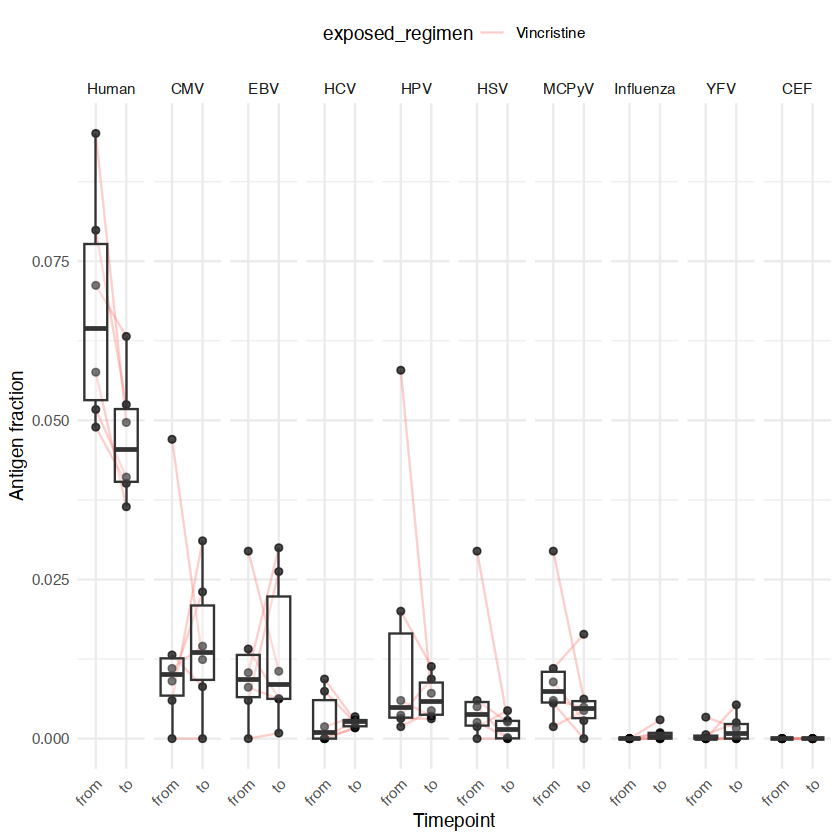

In [80]:
p_regimen

In [81]:
make_regimen_paired_antigen_plot <- function(data, target_regimen,
                                             antigens = c("Human","CMV","EBV","HCV","HPV","HSV","MCPyV","Influenza","YFV","CEF"),
                                             p_alpha = 0.15, adjust_method = "BH") {
  # Dependencies are used with namespace prefixes (no library() needed)

  # Ensure a Regimen column exists
  # if (!"exposed_regimen" %in% names(data) && "exposed_regimen" %in% names(data)) {
  #   data <- dplyr::rename(data, exposed_regimen = exposed_regimen)
  # }

  # Create _frac columns if missing (assumes base antigen counts + cdr3_reads)
  needed_frac <- paste0(antigens, "_frac")
  if (!all(needed_frac %in% names(data)) && "cdr3_reads" %in% names(data)) {
    for (ag in antigens) {
      if (ag %in% names(data) && !(paste0(ag, "_frac") %in% names(data))) {
        data[[paste0(ag, "_frac")]] <- data[[ag]] / data$cdr3_reads
      }
    }
  }

  # Helper: numeric cycle index (e.g., X01 -> 1)
  to_num <- function(x) as.integer(gsub("\\D", "", x))

  # Keep only rows for the target regimen
  df_reg <- data %>%
    dplyr::filter(.data$exposed_regimen == target_regimen) %>%
    dplyr::select(Sample = dplyr::all_of(if ("sample_id" %in% names(.)) "sample_id" else "Sample"),
                  Patient, cycle, exposed_regimen,
                  dplyr::all_of(paste0(antigens, "_frac"))) %>%
    dplyr::mutate(cycle_num = to_num(.data$cycle))
print(dim(df_reg))
  # If not enough data, return early
  if (nrow(df_reg) == 0) {
    return(list(pairs_long = tibble::tibble(), wilcox_results = tibble::tibble(), plot = ggplot2::ggplot()))
  }

  # Build within-patient, within-regimen consecutive cycle pairs
  from_tbl <- df_reg %>%
    dplyr::transmute(Patient, exposed_regimen,
                     cycle_from = .data$cycle, cycle_num_from = .data$cycle_num,
                     dplyr::across(tidyselect::ends_with("_frac"), identity, .names = "from.{.col}"))

  to_tbl <- df_reg %>%
    dplyr::transmute(Patient, exposed_regimen,
                     cycle_to = .data$cycle, cycle_num_to = .data$cycle_num,
                     dplyr::across(tidyselect::ends_with("_frac"), identity, .names = "to.{.col}"))

  # Join all pairs inside patient+regimen, then keep only consecutive (k -> k+1)
  # Declare relationship = "many-to-many" to silence warnings when multiple samples exist per cycle
  pairs <- try(
    from_tbl %>%
      dplyr::inner_join(to_tbl, by = c("Patient","exposed_regimen"), relationship = "many-to-many") %>%
      dplyr::filter(.data$cycle_num_to == .data$cycle_num_from + 1L),
    silent = TRUE
  )

  if (inherits(pairs, "try-error")) {
    # Fallback for older dplyr without `relationship` arg
    pairs <- from_tbl %>%
      dplyr::inner_join(to_tbl, by = c("Patient","exposed_regimen")) %>%
      dplyr::filter(.data$cycle_num_to == .data$cycle_num_from + 1L)
  }

  if (nrow(pairs) == 0) {
    return(list(pairs_long = tibble::tibble(), wilcox_results = tibble::tibble(), plot = ggplot2::ggplot()))
  }

  # Long format: two timepoints (from/to) per pair, per antigen
  pairs_long_from <- pairs %>%
    dplyr::select(Patient, exposed_regimen, cycle_from, cycle_to, tidyselect::starts_with("from.")) %>%
    tidyr::pivot_longer(tidyselect::starts_with("from."),
                        names_to = "var", values_to = "fraction") %>%
    dplyr::mutate(antigen = sub("^from\\.(.+)_frac$", "\\1", .data$var),
                  timepoint = "from",
                  cycle = .data$cycle_from) %>%
    dplyr::select(Patient, exposed_regimen, interval = .data$cycle_to, cycle, antigen, timepoint, fraction)

  pairs_long_to <- pairs %>%
    dplyr::select(Patient, exposed_regimen, cycle_from, cycle_to, tidyselect::starts_with("to.")) %>%
    tidyr::pivot_longer(tidyselect::starts_with("to."),
                        names_to = "var", values_to = "fraction") %>%
    dplyr::mutate(antigen = sub("^to\\.(.+)_frac$", "\\1", .data$var),
                  timepoint = "to",
                  cycle = .data$cycle_to) %>%
    dplyr::select(Patient, exposed_regimen, interval = .data$cycle_to, cycle, antigen, timepoint, fraction)

  pairs_long <- dplyr::bind_rows(pairs_long_from, pairs_long_to) %>%
    dplyr::filter(.data$antigen %in% antigens) %>%
    dplyr::mutate(
      antigen = factor(.data$antigen, levels = antigens),
      pair_id = paste(.data$Patient, .data$interval, sep = "_"),
      cycle_order = to_num(.data$cycle)
    )

  # Paired Wilcoxon tests per antigen (to vs from), paired by Patient
  wilcox_results <- pairs_long %>%
    dplyr::select(Patient, antigen, interval, timepoint, fraction) %>%
    dplyr::filter(!is.na(.data$fraction)) %>%
    tidyr::pivot_wider(names_from = timepoint, values_from = fraction) %>%
    dplyr::group_by(antigen) %>%
    dplyr::summarise(
      n_pairs = sum(!is.na(.data$from) & !is.na(.data$to)),
      p = if (n_pairs >= 2)
        tryCatch(stats::wilcox.test(.data$to, .data$from, paired = TRUE)$p.value, error = function(e) NA_real_)
      else NA_real_,
      .groups = "drop"
    ) %>%
    #dplyr::group_by(antigen) %>%
    dplyr::mutate(p_adj = p.adjust(.data$p, method = adjust_method)) %>%
    dplyr::ungroup()

  # Base plot (paired points + lines, plus boxplot), x = timepoint, facet by antigen
  p <- ggplot2::ggplot(pairs_long, ggplot2::aes(x = factor(.data$timepoint, levels = c("from", "to")),
                                                y = .data$fraction)) +
    ggplot2::geom_line(ggplot2::aes(color = .data$exposed_regimen, group = .data$pair_id), alpha = 0.7) +
    ggplot2::geom_point(alpha = 0.7, shape = 16) +
    ggplot2::geom_boxplot(ggplot2::aes(group = .data$timepoint), inherit.aes = TRUE,
                          outlier.shape = NA, alpha = 0.25) +
    ggplot2::facet_grid(. ~ antigen, scales = "free_y") +
    ggplot2::theme_minimal() +
    ggplot2::theme(legend.position = "bottom",
                   axis.text.x = ggplot2::element_text(angle = 45, hjust = 1)) +
    ggplot2::labs(x = "", y = "Fraction of TCR reads", color = "") +
    scale_color_manual(values = colpal)
  # Change the x-axis text labels to "pre" and "post"
  p <- p + ggplot2::scale_x_discrete(labels = c("from" = "pre", "to" = "post"))

  # Annotate adjusted p-values < p_alpha
  annot_sig <- wilcox_results %>%
    dplyr::filter(!is.na(.data$p_adj) & .data$p_adj < p_alpha) %>%
    dplyr::mutate(label = dplyr::if_else(.data$p_adj < 0.01,
                                         sprintf("p = %.2e", .data$p_adj),
                                         sprintf("p = %.3f", .data$p_adj)))

  if (nrow(annot_sig) > 0) {
    # y-position per antigen: a bit above the max
    y_map <- sapply(levels(pairs_long$antigen), function(a) {
      vals <- pairs_long$fraction[pairs_long$antigen == a]
      if (all(is.na(vals))) return(NA_real_)
      max(vals, na.rm = TRUE) * 1.08
    })
    signif_df <- data.frame(
      antigen = annot_sig$antigen,
      y_position = y_map[as.character(annot_sig$antigen)],
      label = annot_sig$label
    )
    # Only annotate where we have a finite y
    signif_df <- signif_df[is.finite(signif_df$y_position), , drop = FALSE]

    if (nrow(signif_df) > 0) {
      p <- p +
        ggsignif::geom_signif(
          data = signif_df,
          ggplot2::aes(xmin = 1, xmax = 2, annotations = .data$label, y_position = .data$y_position),
          manual = TRUE,
          textsize = 3.2,
          tip_length = 0.015
        )
    }
  }

  list(pairs_long = pairs_long, wilcox_results = wilcox_results, plot = p)
}


In [82]:
table(df1$exposed_regimen)


                         Cyclophosphamide 
                                        2 
                             Methotrexate 
                                       20 
                               No therapy 
                                        6 
                                   Others 
                                       32 
                              Vincristine 
                                       27 
             Vincristine/Cyclophosphamide 
                                       48 
                 Vincristine/Methotrexate 
                                       12 
Vincristine/Methotrexate/Cyclophosphamide 
                                        4 
                                 baseline 
                                       41 

In [83]:
sampletype <- "PBMC"
# cancergroup <- "Leukemia"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]

In [84]:
# vinmtx <- make_regimen_paired_antigen_plot(df1, target_regimen = "Vincristine/Methotrexate", 
#                         antigens = c("Human","CMV","EBV","HCV","HPV","HSV","MCPyV","Influenza"))

vincyclo <- make_regimen_paired_antigen_plot(df1, target_regimen = "Vincristine/Cyclophosphamide", 
                        antigens = c("Human","CMV","EBV","HCV","HPV","HSV","MCPyV","Influenza"))

vin <- make_regimen_paired_antigen_plot(df1, target_regimen = "Vincristine", 
                        antigens = c("Human","CMV","EBV","HCV","HPV","HSV","MCPyV","Influenza"))
mtx <- make_regimen_paired_antigen_plot(df1, target_regimen = "Methotrexate", 
                        antigens = c("Human","CMV","EBV","HCV","HPV","HSV","MCPyV","Influenza"))

others <- make_regimen_paired_antigen_plot(df1, target_regimen = "Others", 
                        antigens = c("Human","CMV","EBV","HCV","HPV","HSV","MCPyV","Influenza"))

[1] 48 13


Warning message:
"Use of .data in tidyselect expressions was deprecated in tidyselect 1.2.0.
i Please use `"cycle_to"` instead of `.data$cycle_to`"
Warning message:
"There were 2 warnings in `dplyr::summarise()`.
The first warning was:
i In argument: `p = if (...) NULL`.
i In group 4: `antigen = HCV`.
Caused by warning in `wilcox.test.default()`:
! cannot compute exact p-value with zeroes
i Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."


[1] 27 13


Warning message:
"There were 3 warnings in `dplyr::summarise()`.
The first warning was:
i In argument: `p = if (...) NULL`.
i In group 2: `antigen = CMV`.
Caused by warning in `wilcox.test.default()`:
! cannot compute exact p-value with zeroes
i Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings."


[1] 20 13


Warning message:
"There were 7 warnings in `dplyr::summarise()`.
The first warning was:
i In argument: `p = if (...) NULL`.
i In group 2: `antigen = CMV`.
Caused by warning in `wilcox.test.default()`:
! cannot compute exact p-value with zeroes
i Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings."


[1] 32 13


Warning message:
"There were 7 warnings in `dplyr::summarise()`.
The first warning was:
i In argument: `p = if (...) NULL`.
i In group 3: `antigen = EBV`.
Caused by warning in `wilcox.test.default()`:
! cannot compute exact p-value with zeroes
i Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings."


In [86]:

# Arrange plots (one row, 5 plots)
combined_boxplots <- cowplot::plot_grid(
  vin$plot, mtx$plot, vincyclo$plot, others$plot,
  #labels = c("HomoSapiens", "Viral", "Bacterial", "Cross-reactive", "Unknown"),
  ncol = 4, align = "v", axis = "tblr", labels = "C"
) 

# Save to PDF
pdf(paste0(plotpath, "gliph_paired_boxplot_exposed_regimens_antigens.pdf"), width = 17, height = 6)
print(combined_boxplots)
dev.off()

pdf 
  2

### PBMC

Leukemia

In [119]:
head(samples_tcr_freq)

,CMV,EBV,HCV,HSV,Influenza,Human,HPV,CEF,TB,MCPyV,...,n_cdr3ingliph,cdr3reads_ingliph,Patient,cycle,sampletype,cancergroup,Age,group,sample_id,Relapse
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>
CHP-328-04-PBMC-DNA,1727,2684,0,28,0,13527,1211,0,0,1114,...,125,98929,CHP_328,X04,PBMC,Leukemia,7.0,post,CHP-328-04-PBMC-DNA,0
CHP-328-05-PBMC-DNA,227,214,33,158,0,816,318,0,0,341,...,34,15470,CHP_328,X05,PBMC,Leukemia,7.0,post,CHP-328-05-PBMC-DNA,0
CHP-351-03-PBMC-DNA,895,722,1280,284,538,6260,993,207,0,648,...,248,66508,CHP_351,X03,PBMC,Solid tumors,7.0,post,CHP-351-03-PBMC-DNA,0
CHP-369-01-PBMC-DNA,1741,826,4563,274,15,19150,401,367,0,1075,...,183,160268,CHP_369,X01,PBMC,Leukemia,0.1,pre,CHP-369-01-PBMC-DNA,0
CHP-377-02-PBMC-DNA,508,1040,0,10,0,2021,181,0,0,736,...,96,15269,CHP_377,X02,PBMC,Leukemia,18.0,post,CHP-377-02-PBMC-DNA,1
CHP-411-02-PBMC-DNA,1857,378,592,170,0,5598,87,94,0,458,...,294,55414,CHP_411,X02,PBMC,Leukemia,16.0,post,CHP-411-02-PBMC-DNA,1


In [90]:
sampletype <- "PBMC"
cancergroup <- "Leukemia"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [91]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [92]:
head(df1_baseline$cdr3_reads)

[1] 349868   5874   5982   1308    810   1122

In [93]:
myantigens <- colnames(df1_baseline)[1:13]
myantigens

[1] "CMV"       "EBV"       "HCV"       "HSV"       "Influenza" "Human"    
 [7] "HPV"       "CEF"       "TB"        "MCPyV"     "SP"        "HTLV1"    
[13] "YFV"

In [94]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [95]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [96]:
  # generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0,]

  for( i in unique(df1_baseline$Patient)){  
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_pre <- nrow(mypt[ mypt$cycle == "X01", ])
    mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    df1_baseline_id <- rbind(df1_baseline_id, mypt)
  }

In [97]:
# head(df1_baseline_id[ df1_baseline_id$Human_frac > 1,1:18])

In [98]:
myantigens <- c('CMV','EBV','HCV','Influenza','Human',"HSV","CEF", "YFV", "HPV","TB","MCPyV","SP")

In [99]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [100]:
message("CMV")
tapply(df1_baseline_id$CMV_frac, df1_baseline_id$group, summary)
message("Human")
tapply(df1_baseline_id$Human_frac, df1_baseline_id$group, summary)
message("MCPyV")
tapply(df1_baseline_id$MCPyV_frac, df1_baseline_id$group, summary)
message("HCV")
tapply(df1_baseline_id$HCV_frac, df1_baseline_id$group, summary)

CMV



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.004141 0.017846 0.024864 0.022090 0.107595 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.008272 0.012635 0.015244 0.019745 0.046442 


Human



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001799 0.021946 0.045711 0.058449 0.064840 0.177215 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005348 0.039929 0.050693 0.052677 0.064444 0.106259 


MCPyV



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.003306 0.010569 0.021934 0.019842 0.107595 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.002609 0.007130 0.009674 0.012287 0.046914 


HCV



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.001794 0.004156 0.008589 0.013042 

$post
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0003341 0.0038127 0.0048782 0.0321101 


In [101]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[

In [102]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [103]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
HSV,HSV,0.007967213,0.07967213
HPV,HPV,0.048318036,0.24159018
MCPyV,MCPyV,0.104184122,0.34728041
EBV,EBV,0.146054655,0.36513664
CMV,CMV,0.294424194,0.43446082
HCV,HCV,0.259030061,0.43446082
Influenza,Influenza,0.304122575,0.43446082
CEF,CEF,0.422678074,0.52834759
YFV,YFV,0.672378828,0.74708759


In [104]:
sig_wilcox_mat <- wilcox_mat[ which(wilcox_mat$adjp < 0.1),]
sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$p, function(x) round_and_format(x) )

In [105]:
sig_wilcox_mat

,antigen,p,adjp,p.val
,<chr>,<dbl>,<dbl>,<chr>
HSV,HSV,0.007967213,0.07967213,0.008


In [106]:
# pivot_longer

df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, Human_frac, HPV_frac, HSV_frac, MCPyV_frac, YFV_frac, CEF_frac
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [107]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [108]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [109]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, 
levels = c("Human", 'CMV','EBV','HCV','HPV',"HSV",'MCPyV','Influenza', "YFV", "CEF"))

In [110]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,CMV,4.976162e-03
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,EBV,2.360890e-03
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,HCV,1.304206e-02
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,Influenza,4.287331e-05
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,Human,5.473493e-02
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,HPV,1.146147e-03


In [111]:
head(meta_div[ meta_div$Patient == "CHP_413",])

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>
186,CHP_413_01,CHP_413,X01,4.0,0.00,19,AML,4.0,1985,43,...,26.989158,0.63221853,CHP_413-01_PBMC-DNA,batch12_30Apr2021/mixcr/clones/CLONES_TRBCHP_413-01_PBMC-DNA.txt,PBMC,CHP,1.4450041,CHP_413_01_PBMC,Flow cytometry & capTCR-seq,Others
187,CHP_413_02,CHP_413,X02,3.2,93.42,19,AML,3.2,2525,312,...,145.906624,0.52069465,CHP_413-02_PBMC-DNA,remaining_batch_3_4May2021/mixcr/clones/CLONES_TRBCHP_413-02_PBMC-DNA.txt,PBMC,CHP,2.2681374,CHP_413_02_PBMC,Flow cytometry & capTCR-seq,Others
437,CHP_413_01,CHP_413,X01,4.0,0.00,19,AML,4.0,1985,43,...,3.939760,0.02719615,CHP_413-01_cfDNA,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_413-01_cfDNA.txt,cfDNA,CHP,0.5999398,CHP_413_01_cfDNA,capTCR-seq,Others
438,CHP_413_02,CHP_413,X02,3.2,93.42,19,AML,3.2,2525,312,...,2.402157,0.05598501,CHP_413-02_cfDNA,priority_pool3/mixcr/clones/CLONES_TRBCHP_413-02_cfDNA.txt,cfDNA,CHP,0.4943026,CHP_413_02_cfDNA,capTCR-seq,Others


In [112]:
sig_wilcox_mat

,antigen,p,adjp,p.val
,<chr>,<dbl>,<dbl>,<chr>
HSV,HSV,0.007967213,0.07967213,0.008


In [113]:
levels(df1_baseline_long$antigen)

[1] "Human"     "CMV"       "EBV"       "HCV"       "HPV"       "HSV"      
 [7] "MCPyV"     "Influenza" "YFV"       "CEF"

In [114]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,CMV,4.976162e-03
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,EBV,2.360890e-03
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,HCV,1.304206e-02
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,Influenza,4.287331e-05
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,Human,5.473493e-02
CHP-369-01-PBMC-DNA,CHP_369,X01,Leukemia,0.1,0,pre,CHP_369_1,HPV,1.146147e-03


In [115]:
df1_baseline_long$label <- NA
df1_baseline_long$label[ df1_baseline_long$fraction > 0.1] <- "X"

In [116]:
df1_baseline_long[ which(df1_baseline_long$label == "X"),]

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction,label
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>,<chr>
CHP_357-03-PBMC-DNA,CHP_357,X03,Leukemia,1,0,post,CHP_357_2,Human,0.1062591,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,CMV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,EBV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,Human,0.1772152,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,HPV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,HSV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_1,MCPyV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_2,CMV,0.1075949,X
CHP_405-01_PBMC_DNA,CHP_405,X01,Leukemia,1,0,pre,CHP_405_2,EBV,0.1075949,X


In [117]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~ factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    ggsignif::geom_signif(
        data = sig_wilcox_mat,
        aes(xmin = 1, xmax = 2, annotations = p.val, y_position = 0.14),
        textsize = 3, vjust = -0.2, color = "black",
        manual = TRUE
    ) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    # geom_text_repel(
    #     label = ifelse(df1_baseline_long$label == "X", as.character(df1_baseline_long$Patient), ""),
    #     size = 4, #min.segment.length = 0,
    #     ylim = c(-Inf, Inf),
    #     nudge_y = .006,
    #     arrow = arrow(length = unit(0.1, "npc"))
    # ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )

Warning message in ggsignif::geom_signif(data = sig_wilcox_mat, aes(xmin = 1, xmax = 2, :
"Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position"


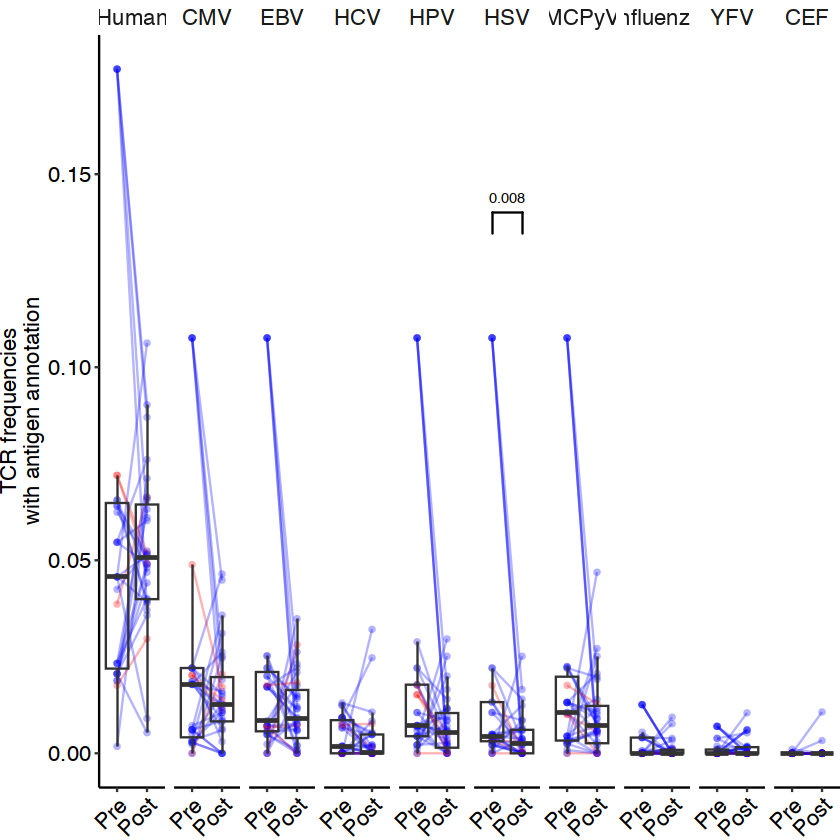

In [118]:
p_sample_cancer

In [43]:
pdf(paste0(plotpath, "antigen_frac_p_leu.pdf"), width = 10, height = 5)
cowplot::plot_grid(p_sample_cancer, labels = "B")
dev.off()


Warning message:
"Removed 432 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


pdf 
  2

Lymphoma

In [44]:
sampletype <- "PBMC"
cancergroup <- "Lymphoma"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [45]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [46]:
myantigens <- colnames(df1_baseline)[1:13]

In [47]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [48]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [49]:
df1_baseline[ grepl("CHP_366", rownames(df1_baseline)),]

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,Influenza_frac,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lymphoma:CHP_366_X01-PBMC,129,41,45,0,95,2569,0,0,0,20,...,0,0.024856096,0.6721612,0,0,0,0.005232862,0,0,0
Lymphoma:CHP_366_X03-PBMC,1393,519,25,0,1307,21558,0,0,0,0,...,0,0.022855644,0.3769870,0,0,0,0.000000000,0,0,0
Lymphoma:CHP_366_X05-PBMC,12904,0,0,0,213,36739,0,0,0,0,...,0,0.002450388,0.4226517,0,0,0,0.000000000,0,0,0
Lymphoma:CHP_366_X01-PBMC1,129,41,45,0,95,2569,0,0,0,20,...,0,0.024856096,0.6721612,0,0,0,0.005232862,0,0,0


In [50]:
  # generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0,]

  for( i in unique(df1_baseline$Patient)){  
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_pre <- nrow(mypt[ mypt$cycle == "X01", ])
    mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    df1_baseline_id <- rbind(df1_baseline_id, mypt)
  }

In [51]:
message("CMV")
tapply(df1_baseline_id$CMV_frac, df1_baseline_id$group, summary)
message("Human")
tapply(df1_baseline_id$HomoSapiens_frac, df1_baseline_id$group, summary)


CMV



$pre
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.03375 0.03421 0.03121 0.04832 0.04832 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.020371 0.007945 0.148450 


Human



$pre
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01807 0.01807 0.02477 0.02393 0.02486 0.03095 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.005173 0.021098 0.015583 0.129787 


In [52]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Lymphoma:CHP_361_X01-PBMC,131,63,0,0,49,1633,0,0,0,0,...,0.018074511,0.6023608,0.00000000,0,0,0,0,0,0,CHP_361_1
Lymphoma:CHP_361_X02-PBMC,5,127,0,0,10,732,28,0,0,0,...,0.005173306,0.3786860,0.01448526,0,0,0,0,0,0,CHP_361_1
Lymphoma:CHP_361_X03-PBMC,0,12,0,0,0,518,0,0,0,0,...,0.000000000,0.2445703,0.00000000,0,0,0,0,0,0,CHP_361_2
Lymphoma:CHP_361_X04-PBMC,0,9,0,0,0,66,0,0,0,0,...,0.000000000,0.2857143,0.00000000,0,0,0,0,0,0,CHP_361_3
Lymphoma:CHP_361_X01-PBMC1,131,63,0,0,49,1633,0,0,0,0,...,0.018074511,0.6023608,0.00000000,0,0,0,0,0,0,CHP_361_2
Lymphoma:CHP_361_X01-PBMC.1,131,63,0,0,49,1633,0,0,0,0,...,0.018074511,0.6023608,0.00000000,0,0,0,0,0,0,CHP_361_3


In [53]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [54]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [55]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DAT

In [56]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [57]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
CMV,CMV,0.2328043,0.4656087
HomoSapiens,HomoSapiens,0.1232049,0.4656087
HPV,HPV,0.1814492,0.4656087
MCPyV,MCPyV,0.5270893,0.7906339
EBV,EBV,0.9441141,1.0000000
HCV,HCV,1.0000000,1.0000000
Influenza,Influenza,NaN,NaN


In [58]:
# sig_wilcox_mat <- wilcox_mat[ wilcox_mat$adjp < 0.15,]
# sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$adjp, function(x) round_and_format(x) )

In [59]:
# sig_wilcox_mat

In [60]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac,
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [61]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [62]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [63]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [64]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,CMV,0.04832165
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,EBV,0.02323866
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,HCV,0.00000000
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,Influenza,0.00000000
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,HomoSapiens,0.01807451
CHP_361_01,CHP_361,X01,Lymphoma,13,0,pre,CHP_361_1,HPV,0.00000000


In [65]:
df1_baseline_long$label <- NA
df1_baseline_long$label[ df1_baseline_long$fraction > 0.1] <- "X"

In [66]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~ factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    geom_text_repel(
        label = ifelse(df1_baseline_long$label == "X", as.character(df1_baseline_long$Patient), ""),
        size = 4, #min.segment.length = 0,
        nudge_y = .006,
        ylim = c(-Inf, Inf),
        arrow = arrow(length = unit(0.1, "npc"))
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


Warning message:
"Removed 124 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


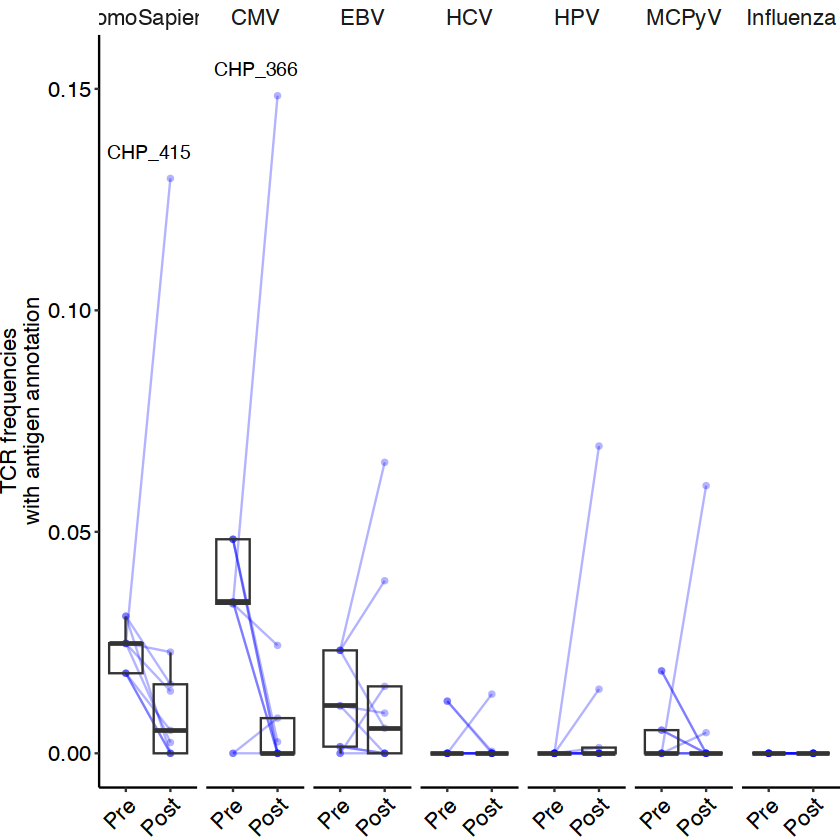

In [67]:
p_sample_cancer

In [68]:
pdf(paste0(plotpath, "antigen_frac_p_lym.pdf"), width = 10, height = 5)
cowplot::plot_grid(p_sample_cancer, labels = "B")
dev.off()

Warning message:
"Removed 124 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


pdf 
  2

Solid

In [52]:
sampletype <- "PBMC"
cancergroup <- "Solidtumors"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [53]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [54]:
myantigens <- colnames(df1_baseline)[1:13]

In [55]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [56]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [57]:
  # generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0,]

  for( i in unique(df1_baseline$Patient)){  
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_pre <- nrow(mypt[ mypt$cycle == "X01", ])
    mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    df1_baseline_id <- rbind(df1_baseline_id, mypt)
  }

In [58]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Solidtumors:CHP_348_X01-PBMC,12,3,3,0,68,501,1,0,0,0,...,0.07142857,0.5262605,0.001050420,0,0,0.000000000,0,0,0,CHP_348_1
Solidtumors:CHP_348_X02-PBMC,0,0,0,0,0,121,0,0,0,0,...,0.00000000,0.4060403,0.000000000,0,0,0.000000000,0,0,0,CHP_348_1
Solidtumors:CHP_350_X01-PBMC,27,0,10,5,52,818,2,0,0,7,...,0.03157256,0.4966606,0.001214329,0,0,0.004250152,0,0,0,CHP_350_1
Solidtumors:CHP_350_X02-PBMC,16,29,47,0,101,1672,0,0,0,22,...,0.03375668,0.5588235,0.000000000,0,0,0.007352941,0,0,0,CHP_350_1
Solidtumors:CHP_350_X03-PBMC,20,12,6,0,35,1120,0,0,0,28,...,0.01640112,0.5248360,0.000000000,0,0,0.013120900,0,0,0,CHP_350_2
Solidtumors:CHP_350_X04-PBMC,6,9,4,0,18,769,0,0,0,0,...,0.01820020,0.7775531,0.000000000,0,0,0.000000000,0,0,0,CHP_350_3


In [59]:
message("CMV")
tapply(df1_baseline_id$CMV_frac, df1_baseline_id$group, summary)
message("Human")
tapply(df1_baseline_id$HomoSapiens_frac, df1_baseline_id$group, summary)


CMV



$pre
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0009416 0.0115546 0.0102599 0.0163934 0.0231716 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.004948 0.005442 0.007203 0.024155 


Human



$pre
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.008662 0.026000 0.026843 0.045422 0.071429 

$post
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.007169 0.018584 0.028949 0.032415 0.236842 


In [76]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [77]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [78]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1

In [79]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [80]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
CMV,CMV,0.05736952,0.1338622
Influenza,Influenza,0.04199965,0.1338622
MCPyV,MCPyV,0.03624171,0.1338622
HCV,HCV,0.32017407,0.4287334
HomoSapiens,HomoSapiens,0.35308667,0.4287334
HPV,HPV,0.36748581,0.4287334
EBV,EBV,0.92238568,0.9223857


In [81]:
sig_wilcox_mat <- wilcox_mat[ which(wilcox_mat$adjp < 0.1),]
sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$p, function(x) round_and_format(x) )

In [82]:
# sig_wilcox_mat

In [83]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [84]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [85]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [86]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [87]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,CMV,0.012605042
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,EBV,0.003151261
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,HCV,0.003151261
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,Influenza,0.000000000
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,HomoSapiens,0.071428571
CHP_348_01,CHP_348,X01,Solidtumors,18,0,pre,CHP_348_1,HPV,0.001050420


In [88]:
df1_baseline_long$label <- NA
df1_baseline_long$label[df1_baseline_long$fraction > 0.04 &
    df1_baseline_long$antigen == "EBV"] <- "X"
df1_baseline_long$label[df1_baseline_long$fraction > 0.15] <- "X"


In [89]:
df1_baseline_long[ df1_baseline_long$Patient == "CHP_414",]

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction,label
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>,<chr>
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,CMV,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,EBV,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,HCV,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,Influenza,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,HomoSapiens,0.0000000000,NA
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,HPV,0.2018166997,X
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,MCPyV,0.0000000000,NA
CHP_414_02,CHP_414,X02,Solidtumors,1,0,post,CHP_414_1,CMV,0.0068557183,NA
CHP_414_02,CHP_414,X02,Solidtumors,1,0,post,CHP_414_1,EBV,0.0058169731,NA


In [90]:
df1_baseline_long[ which(df1_baseline_long$label == "X"),]

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction,label
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>,<chr>
CHP_363_03,CHP_363,X03,Solidtumors,20,0,post,CHP_363_2,HomoSapiens,0.23684211,X
CHP_364_04,CHP_364,X04,Solidtumors,16,1,post,CHP_364_2,EBV,0.04251208,X
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_1,HPV,0.20181670,X
CHP_414_01,CHP_414,X01,Solidtumors,1,0,pre,CHP_414_2,HPV,0.20181670,X
CHP_418_02,CHP_418,X02,Solidtumors,2,1,post,CHP_418_1,EBV,0.05178535,X


In [91]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    # ggsignif::geom_signif(
    #     data = sig_wilcox_mat,
    #     aes(xmin = 1, xmax = 2, annotations = p.val, y_position = 0.07),
    #     textsize = 3, vjust = -0.2, color = "black",
    #     manual = TRUE
    # ) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
        geom_text_repel(
        label = ifelse(df1_baseline_long$label == "X", as.character(df1_baseline_long$Patient), ""),
        size = 4, #min.segment.length = 0,
        nudge_y = .006,
        ylim = c(-Inf, Inf)
        #arrow = arrow(length = unit(0.1, "npc"))
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


Warning message:
"Removed 331 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


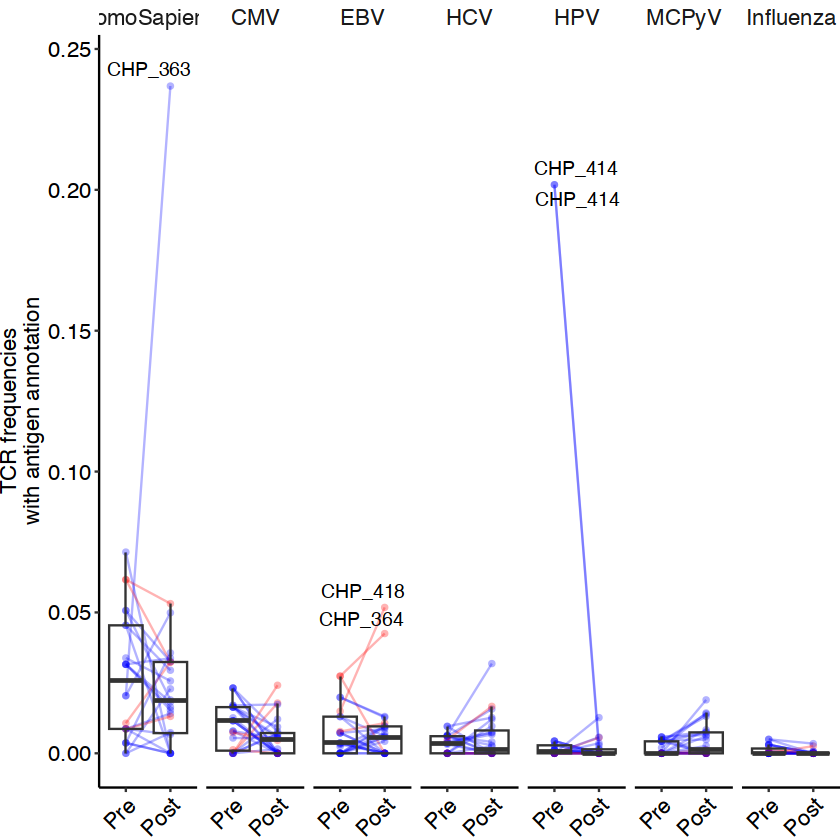

In [92]:
p_sample_cancer

In [93]:
pdf(paste0(plotpath, "antigen_frac_p_solid.pdf"), width = 10, height = 5)
cowplot::plot_grid(p_sample_cancer, labels = "C")
dev.off()

Warning message:
"Removed 331 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


pdf 
  2

# Lookup

In [90]:
head(meta_div[ meta_div$Patient == "CHP_413",])

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,assay,samplename
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
771,CHP_413_01,CHP_413,X01,4.0,0.00,19,AML,4.0,1985,43,...,26.320,26.989,0.543,CHP_413-01_PBMC-DNA,batch12_30Apr2021/mixcr/clones/CLONES_TRBCHP_413-01_PBMC-DNA.txt,PBMC,CHP,1.4449967,Flow cytometry & capTCR-seq,Leukemia:CHP_413_X01-PBMC
772,CHP_413_02,CHP_413,X02,3.2,93.42,19,AML,3.2,2525,312,...,145.798,145.907,0.492,CHP_413-02_PBMC-DNA,remaining_batch_3_4May2021/mixcr/clones/CLONES_TRBCHP_413-02_PBMC-DNA.txt,PBMC,CHP,2.2681378,Flow cytometry & capTCR-seq,Leukemia:CHP_413_X02-PBMC
268,CHP_413_01,CHP_413,X01,4.0,0.00,19,AML,4.0,1985,43,...,3.934,3.940,0.026,CHP_413-01_cfDNA,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_413-01_cfDNA.txt,cfDNA,CHP,0.5999922,capTCR-seq,Leukemia:CHP_413_X01-cfDNA
269,CHP_413_02,CHP_413,X02,3.2,93.42,19,AML,3.2,2525,312,...,2.401,2.402,0.051,CHP_413-02_cfDNA,priority_pool3/mixcr/clones/CLONES_TRBCHP_413-02_cfDNA.txt,cfDNA,CHP,0.4942938,capTCR-seq,Leukemia:CHP_413_X02-cfDNA


In [43]:
gliph_out <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_v5_cleaned.rds"))

In [98]:
head(gliph_out[grepl("MAA", gliph_out$Sample),])

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
4,IWV,0.0e+00,3,97,1.2e-10,1,0.008,0.008,0.190,1.0e-05,motif-IWV,CASWIWVDRRSTDTQYF,TRBV19,TRBJ1-2,NA,HomoSapiens:MAA_NA,1,HomoSapiens
17,S%GLAGGE,1.3e-33,4,29,3.8e-11,1,0.001,0.940,0.001,4.0e-05,global-S%GLAGGE,CASSYGLAGGEQFF,TRBV2,TRBJ2-1,NA,HomoSapiens:MAA_NA,1,HomoSapiens
56,SPG%NE,6.4e-25,5,23,8.5e-11,1,0.001,1.000,0.001,8.5e-05,global-SPG%NE,CASSPGGNEQFF,TRBV5-5,TRBJ2-1,NA,HomoSapiens:MAA_NA,1,HomoSapiens
75,SPGQ%NTE,2.5e-22,5,18,8.5e-11,1,0.001,1.000,0.001,8.6e-05,global-SPGQ%NTE,CASSPGQRNTEAFF,TRBV6-1,TRBJ1-4,NA,HomoSapiens:MAA_NA,1,HomoSapiens
75,SPGQ%NTE,2.5e-22,5,18,8.5e-11,1,0.001,1.000,0.001,8.6e-05,global-SPGQ%NTE,CASSPGQLNTEAFF,TRBV20-1,TRBJ1-6,NA,HomoSapiens:MAA_NA,1,HomoSapiens
277,SPGG%E,1.5e-15,4,18,8.6e-11,1,0.001,1.000,0.001,8.6e-05,global-SPGG%E,CASSPGGNEQFF,TRBV5-5,TRBJ2-1,NA,HomoSapiens:MAA_NA,1,HomoSapiens


In [48]:
mysample <- gliph_out[ grepl("CHP_353", gliph_out$Sample),]

In [49]:
head(mysample)

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
1,SLG%E,0.0e+00,5,50,5.0e-12,1,0.001,0.35,0.001,1.4e-05,global-SLG%E,CASSLGTEAFF,TRBV5-1,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,11,Leukemia
9,S%SGANV,7.5e-41,3,34,3.4e-11,1,0.001,1.00,0.001,3.4e-05,global-S%SGANV,CASSTSGANVLTF,TRBV11-2,TRBJ2-6,NA,Leukemia:CHP_353_X05-PBMC,64,Leukemia
23,SP%GTE,3.8e-32,4,28,4.0e-11,1,0.001,0.99,0.001,4.0e-05,global-SP%GTE,CASSPQGTEAFF,TRBV18,TRBJ1-1,NA,Leukemia:CHP_353_X03-PBMC,14,Leukemia
33,SP%MNTE,1.6e-28,3,22,7.5e-11,1,0.001,1.00,0.001,7.5e-05,global-SP%MNTE,CATSPPMNTEAFF,TRBV28,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,9,Leukemia
47,SPG%TGE,1.2e-25,3,21,6.1e-11,1,0.001,0.64,0.001,9.6e-05,global-SPG%TGE,CAISPGTTGEQYF,TRBV10-3,TRBJ2-7,NA,Leukemia:CHP_353_X04-cfDNA,7,Leukemia
74,S%GSYE,1.5e-22,6,25,2.3e-09,1,0.055,0.80,0.001,5.2e-05,global-S%GSYE,CASSKGSYEQYF,TRBV10-1,TRBJ2-7,NA,Leukemia:CHP_353_X01-PBMC,9,Leukemia


In [50]:
tmp <- gliph_out[gliph_out$pattern %in% mysample$pattern, ] # subset to include patterns in my sample
antigen_gliphs <- tmp[grepl("Homo", tmp$subject),] # get antigen gliphs
mysample[mysample$pattern %in% antigen_gliphs$pattern,]


index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
74,S%GSYE,1.5e-22,6,25,2.3e-09,1,0.055,0.800,0.001,5.2e-05,global-S%GSYE,CASSKGSYEQYF,TRBV10-1,TRBJ2-7,NA,Leukemia:CHP_353_X01-PBMC,9,Leukemia
471,S%TGGTE,1.5e-12,5,14,4.7e-09,1,0.065,0.990,0.001,7.4e-05,global-S%TGGTE,CASSATGGTEAFF,TRBV6-2,TRBJ1-1,NA,Leukemia:CHP_353_X03-PBMC,2,Leukemia
471,S%TGGTE,1.5e-12,5,14,4.7e-09,1,0.065,0.990,0.001,7.4e-05,global-S%TGGTE,CASSITGGTEAFF,TRBV19,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,14,Leukemia
591,SLGG%E,1.4e-11,5,15,1.1e-10,1,0.003,0.400,0.001,9.5e-05,global-SLGG%E,CASSLGGYEQYF,TRBV5-6,TRBJ2-7,NA,Leukemia:CHP_353_X03-PBMC,5,Leukemia
1143,SLG%GQP,7.5e-09,6,8,8.6e-09,1,0.066,0.160,0.001,8.3e-04,global-SLG%GQP,CASSLGVGQPQHF,TRBV12-3,TRBJ1-5,NA,Leukemia:CHP_353_X04-cfDNA,1221,Leukemia
1143,SLG%GQP,7.5e-09,6,8,8.6e-09,1,0.066,0.160,0.001,8.3e-04,global-SLG%GQP,CASSLGVGQPQHF,TRBV12-3,TRBJ1-5,NA,Leukemia:CHP_353_X05-PBMC,2,Leukemia
1220,S%QGTE,1.3e-08,3,10,2.9e-08,1,0.100,0.920,0.001,3.1e-04,global-S%QGTE,CASSPQGTEAFF,TRBV18,TRBJ1-1,NA,Leukemia:CHP_353_X03-PBMC,14,Leukemia
1220,S%QGTE,1.3e-08,3,10,2.9e-08,1,0.100,0.920,0.001,3.1e-04,global-S%QGTE,CASSQQGTEAFF,TRBV3-1,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,25,Leukemia
1509,SPQG%GTE,8.2e-08,3,6,4.5e-07,1,0.380,0.980,0.001,1.2e-03,global-SPQG%GTE,CASSPQGGGTEAFF,TRBV9,TRBJ1-1,NA,Leukemia:CHP_353_X05-PBMC,23,Leukemia


In [51]:
antigen_gliphs$Sample[ antigen_gliphs$pattern %in% mysample$pattern]

[1] "HomoSapiens:NUP214_SVYWSPKGK"                   
 [2] "HomoSapiens:MAA_NA"                             
 [3] "HomoSapiens:MAA_NA"                             
 [4] "HomoSapiens:MAA_NA"                             
 [5] "HomoSapiens:TERT_ILAKFLHWL"                     
 [6] "HomoSapiens:MAA_NA"                             
 [7] "HomoSapiens:TMEM161A_TMEM161A"                  
 [8] "HomoSapiens:MLANA_ELAGIGILTV_AAGIGILTV"         
 [9] "HomoSapiens:MAA_NA"                             
[10] "HomoSapiens:RPS9p.P68S_NeoAg-AARELLTLDEKDSRRLFE"
[11] "HomoSapiens:MLANA27-35_TAA-AAGIGILTV"           
[12] "HomoSapiens:PMEL154-162_TAA-KTWGQYWQV"          
[13] "HomoSapiens:CMKLR1_FLEDLSPLEA"                  
[14] "HomoSapiens:MAA_NA"

In [97]:
antigen_gliphs

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
2,S%GGNTE,0.0e+00,6,41,3.0e-11,1,0.001,0.970,0.001,0.00003,global-S%GGNTE,CASSWGGNTEAFF,NA,NA,NA,HomoSapiens:ZNF219_CLASLHPR,1,HomoSapiens
1143,SLG%GQP,7.5e-09,6,8,8.6e-09,1,0.066,0.160,0.001,0.00083,global-SLG%GQP,CASSLGQGQPQHF,TRBV6-1,TRBJ1-2,NA,HomoSapiens:MAA_NA,1,HomoSapiens
20216,SF%GGGNQP,1.4e-02,2,2,2.2e-09,1,0.001,0.074,0.001,0.02900,global-SF%GGGNQP,CASSFAGGGNQPQHF,NA,NA,NA,HomoSapiens:POLE_TSISTAMR,1,HomoSapiens
24196,SQGP%YE,3.5e-02,2,2,5.3e-09,1,0.001,0.180,0.001,0.02900,global-SQGP%YE,CASSQGPFYEQYF,TRBV3-1,TRBJ2-7,NA,HomoSapiens:MLANA27-35_TAA-AAGIGILTV,1,HomoSapiens


In [ ]:
mysample[ mysample$pattern == "V%TE",]

In [ ]:
gliph_out[ gliph_out$pattern %in% chp413$pattern,]

### cfDNA

Leukemia

In [208]:
sampletype <- "cfDNA"
cancergroup <- "Leukemia"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [209]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [210]:
myantigens <- colnames(df1_baseline)[1:13]

In [211]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [212]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [213]:
# generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0, ]

for (i in unique(df1_baseline$Patient)) {
  mypt <- df1_baseline[df1_baseline$Patient == i, ]
  n_pre <- nrow(mypt[mypt$cycle == "X01", ])
  mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
  mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
  df1_baseline_id <- rbind(df1_baseline_id, mypt)
}


In [214]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Leukemia:CHP_345_X01-cfDNA,385,1511,0,490,258,16874,0,0,0,224,...,0.01325865,0.8671566,0,0,0,0.01151138,0,0,0,CHP_345_1
Leukemia:CHP_345_X02-cfDNA,0,0,0,0,0,535,0,0,0,0,...,0.00000000,0.2123859,0,0,0,0.00000000,0,0,0,CHP_345_1
Leukemia:CHP_345_X04-cfDNA,0,0,0,0,0,13893,0,0,0,0,...,0.00000000,0.3926906,0,0,0,0.00000000,0,0,0,CHP_345_2
Leukemia:CHP_345_X01-cfDNA1,385,1511,0,490,258,16874,0,0,0,224,...,0.01325865,0.8671566,0,0,0,0.01151138,0,0,0,CHP_345_2
Leukemia:CHP_353_X01-cfDNA,0,0,0,0,0,11,0,0,0,0,...,0.00000000,0.1100000,0,0,0,0.00000000,0,0,0,CHP_353_1
Leukemia:CHP_353_X02-cfDNA,208,0,0,0,0,3782,0,0,0,0,...,0.00000000,0.3676128,0,0,0,0.00000000,0,0,0,CHP_353_1


In [215]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [216]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [217]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[

In [218]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [219]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
Influenza,Influenza,0.3457786,0.6051125
HomoSapiens,HomoSapiens,0.1154794,0.6051125
HPV,HPV,0.1967056,0.6051125
MCPyV,MCPyV,0.3457786,0.6051125
CMV,CMV,0.7259636,0.8334840
EBV,EBV,0.8334840,0.8334840
HCV,HCV,0.6085999,0.8334840


In [220]:
# sig_wilcox_mat <- wilcox_mat[ wilcox_mat$adjp < 0.15,]
# sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$adjp, function(x) round_and_format(x) )

In [221]:
# sig_wilcox_mat

In [222]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [223]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [224]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [225]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [226]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,CMV,0.01978519
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,EBV,0.07765044
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,HCV,0.00000000
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,Influenza,0.02518115
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,HomoSapiens,0.01325865
CHP_345_01,CHP_345,X01,Leukemia,1,0,pre,CHP_345_1,HPV,0.00000000


In [227]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


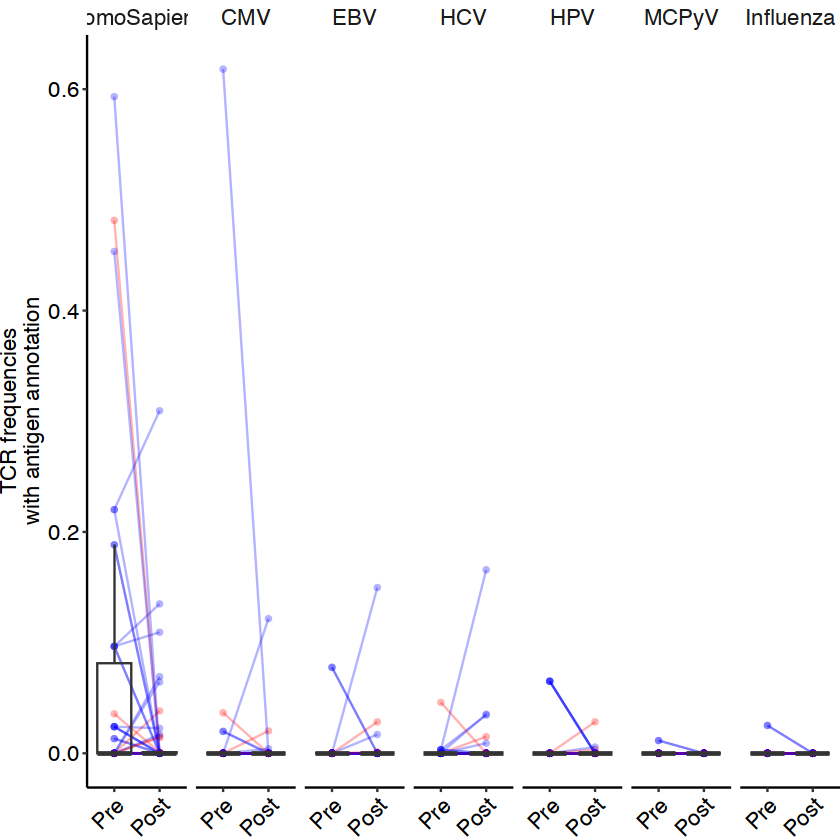

In [228]:
p_sample_cancer

In [229]:
pdf(paste0(plotpath, "antigen_frac_p_leu_cfDNA.pdf"), width = 10, height = 5)
p_sample_cancer
dev.off()

pdf 
  2

Lymphoma

In [230]:
sampletype <- "cfDNA"
cancergroup <- "Lymphoma"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [231]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [232]:
myantigens <- colnames(df1_baseline)[1:13]

In [233]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [234]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [235]:
  # generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0,]

  for( i in unique(df1_baseline$Patient)){  
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_pre <- nrow(mypt[ mypt$cycle == "X01", ])
    mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
    df1_baseline_id <- rbind(df1_baseline_id, mypt)
  }

In [236]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Lymphoma:CHP_344_X01-cfDNA,0,0,0,0,0,335,0,0,0,0,...,0.0000000000,1.80107527,0,0,0,0,0,0,0,CHP_344_1
Lymphoma:CHP_344_X02-cfDNA,0,0,0,0,1,22,0,0,0,0,...,0.0009398496,0.02067669,0,0,0,0,0,0,0,CHP_344_1
Lymphoma:CHP_344_X03-cfDNA,0,0,0,0,0,7610,0,0,0,0,...,0.0000000000,0.91061386,0,0,0,0,0,0,0,CHP_344_2
Lymphoma:CHP_344_X04-cfDNA,0,0,0,0,0,6,0,0,0,0,...,0.0000000000,0.66666667,0,0,0,0,0,0,0,CHP_344_3
Lymphoma:CHP_344_X05-cfDNA,0,0,0,0,0,0,0,0,0,0,...,0.0000000000,0.00000000,0,0,0,0,0,0,0,CHP_344_4
Lymphoma:CHP_344_X01-cfDNA1,0,0,0,0,0,335,0,0,0,0,...,0.0000000000,1.80107527,0,0,0,0,0,0,0,CHP_344_2


In [237]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [238]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [239]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = D

In [240]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [241]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
CMV,CMV,0.02177671,0.08710683
Influenza,Influenza,1.00000000,1.00000000
HomoSapiens,HomoSapiens,0.83348400,1.00000000
HPV,HPV,1.00000000,1.00000000
EBV,EBV,NaN,NaN
HCV,HCV,NaN,NaN
MCPyV,MCPyV,NaN,NaN


In [242]:
sig_wilcox_mat <- wilcox_mat[ which(wilcox_mat$adjp < 0.1),]
sig_wilcox_mat$p.val <- sapply(sig_wilcox_mat$p, function(x) round_and_format(x) )

In [243]:
sig_wilcox_mat

,antigen,p,adjp,p.val
,<chr>,<dbl>,<dbl>,<chr>
CMV,CMV,0.02177671,0.08710683,0.02


In [244]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [245]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [246]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [247]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [248]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,CMV,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,EBV,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,HCV,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,Influenza,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,HomoSapiens,0
CHP_344_01,CHP_344,X01,Lymphoma,6,0,pre,CHP_344_1,HPV,0


In [249]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    ggsignif::geom_signif(
        data = sig_wilcox_mat,
        aes(xmin = 1, xmax = 2, annotations = p.val, y_position = 0.07),
        textsize = 3, vjust = -0.2, color = "black",
        manual = TRUE
    ) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


Warning message in ggsignif::geom_signif(data = sig_wilcox_mat, aes(xmin = 1, xmax = 2, :
"Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position"


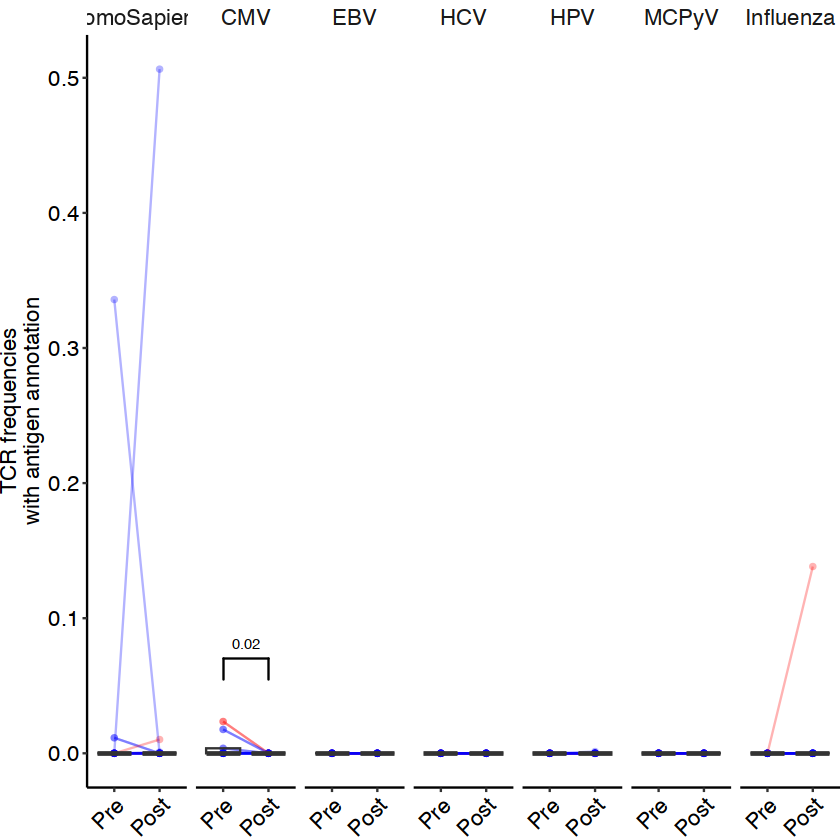

In [250]:
p_sample_cancer

In [251]:
pdf(paste0(plotpath, "antigen_frac_p_lym_cfDNA.pdf"), width = 10, height = 5)
p_sample_cancer
dev.off()

pdf 
  2

Solid

In [252]:
sampletype <- "cfDNA"
cancergroup <- "Solidtumors"

df1 <- samples_tcr_freq[ samples_tcr_freq$sampletype == sampletype,]
df1 <- df1[ df1$cancergroup == cancergroup,]

In [253]:
# get patients with more than one timepoiint and a baseline
mytab <- table(df1$Patient, df1$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ]
baseline_patients <- rownames(mytab)[mytab[, 1] > 0]
df1_baseline <- df1[df1$Patient %in% baseline_patients, ]

In [254]:
myantigens <- colnames(df1_baseline)[1:13]

In [255]:
# generate pre samples for each additional post sample
for( i in unique(df1_baseline$Patient)){
    mypt <- df1_baseline[ df1_baseline$Patient == i, ]
    n_post <- nrow(mypt[ mypt$cycle != "X01", ])
    df1_baseline <- rbind(df1_baseline, mypt[ mypt$cycle == "X01", ][rep(1, n_post-1), ])
}

In [256]:
for (i in 1:length(myantigens)) {
    myvar <- paste0(myantigens[i], "_frac")
    df1_baseline[[myvar]] <- NA
    df1_baseline[[myvar]] <- df1_baseline[,i] / df1_baseline$cdr3_reads
}

In [257]:
# generate an a unique ID between each pairs of pre and post
df1_baseline$ID <- NA
df1_baseline_id <- df1_baseline[0, ]

for (i in unique(df1_baseline$Patient)) {
  mypt <- df1_baseline[df1_baseline$Patient == i, ]
  n_pre <- nrow(mypt[mypt$cycle == "X01", ])
  mypt$ID[mypt$group == "pre"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
  mypt$ID[mypt$group == "post"] <- paste0(mypt$Patient[mypt$group == "pre"], "_", rep(1:n_pre))
  df1_baseline_id <- rbind(df1_baseline_id, mypt)
}


In [258]:
head(df1_baseline_id)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,HomoSapiens_frac,MDavis_frac,HPV_frac,CEF_frac,TB_frac,MCPyV_frac,SP_frac,HTLV1_frac,DENV_frac,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Solidtumors:CHP_343_X01-cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0.0000000,0,0,0,0,0,0,0,CHP_343_1
Solidtumors:CHP_343_X02-cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0.0000000,0,0,0,0,0,0,0,CHP_343_1
Solidtumors:CHP_343_X05-cfDNA,0,0,0,0,0,4,0,0,0,0,...,0,0.6666667,0,0,0,0,0,0,0,CHP_343_2
Solidtumors:CHP_343_X01-cfDNA1,0,0,0,0,0,0,0,0,0,0,...,0,0.0000000,0,0,0,0,0,0,0,CHP_343_2
Solidtumors:CHP_348_X01-cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0.0000000,0,0,0,0,0,0,0,CHP_348_1
Solidtumors:CHP_348_X02-cfDNA,0,0,0,0,0,2667,0,0,0,0,...,0,0.5584171,0,0,0,0,0,0,0,CHP_348_1


In [259]:
myantigens <- c('CMV','EBV','HCV','Influenza','HomoSapiens','HPV','MCPyV')

In [260]:
wilcox_mat <- matrix(NA, nrow = length(myantigens), ncol = 2, dimnames = list(myantigens, c("antigen", "p")))

In [261]:
for(i in 1:length(myantigens)){
    mycol <- paste0(myantigens[i], "_frac")
    mytest <- wilcox.test( eval(as.name(mycol)) ~ group,data = df1_baseline_id, paired = T)
    wilcox_mat[i, "antigen"] <- myantigens[i]
    wilcox_mat[i, "p"] <- mytest$p.value
}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = D

In [262]:
wilcox_mat <- as.data.frame(wilcox_mat)
wilcox_mat$p <- as.numeric(wilcox_mat$p)
wilcox_mat$adjp <- p.adjust(wilcox_mat$p, method = "fdr")

In [263]:
wilcox_mat[order(wilcox_mat$adjp),]

,antigen,p,adjp
,<chr>,<dbl>,<dbl>
Influenza,Influenza,0.1489147,0.4233815
HomoSapiens,HomoSapiens,0.1414821,0.4233815
MCPyV,MCPyV,0.1814492,0.4233815
CMV,CMV,1.0000000,1.0000000
EBV,EBV,0.7835305,1.0000000
HCV,HCV,1.0000000,1.0000000
HPV,HPV,1.0000000,1.0000000


In [264]:
# pivot_longer
# exclude MDavis, CEF, HTLV, DENV
df1_baseline_long <- df1_baseline_id %>%
    dplyr::select(
        sample_id, Patient, cycle, cancergroup, Age, Relapse, group, ID,
        CMV_frac, EBV_frac, HCV_frac, Influenza_frac, HomoSapiens_frac, HPV_frac, MCPyV_frac
    ) %>%
    tidyr::pivot_longer(cols = ends_with("_frac"), names_to = "antigen", values_to = "fraction")


In [265]:
df1_baseline_long <- df1_baseline_long[ !is.na(df1_baseline_long$fraction),]

In [266]:
df1_baseline_long$antigen <- gsub("_frac", "", df1_baseline_long$antigen)

In [267]:
df1_baseline_long$antigen <- factor(df1_baseline_long$antigen, levels = c("HomoSapiens", 'CMV','EBV','HCV','HPV','MCPyV','Influenza'))

In [268]:
head(df1_baseline_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,group,ID,antigen,fraction
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<dbl>
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,CMV,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,EBV,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,HCV,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,Influenza,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,HomoSapiens,0
CHP_343_01,CHP_343,X01,Solidtumors,8,0,pre,CHP_343_1,HPV,0


In [269]:
p_sample_cancer <- ggplot(df1_baseline_long, aes(x = group, y = fraction)) +
    geom_point(aes(color = factor(Relapse)), alpha = 0.3, shape = 16) +
    geom_line(aes(group = ID, color = factor(Relapse)), alpha = 0.3) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    geom_boxplot(fill = "transparent", outlier.shape = NA) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~factor(antigen, levels(df1_baseline_long$antigen)), nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("TCR frequencies\nwith antigen annotation") +
    scale_x_discrete(ggpubr::get_breaks("group"),
        labels = c("Pre", "Post")
    )


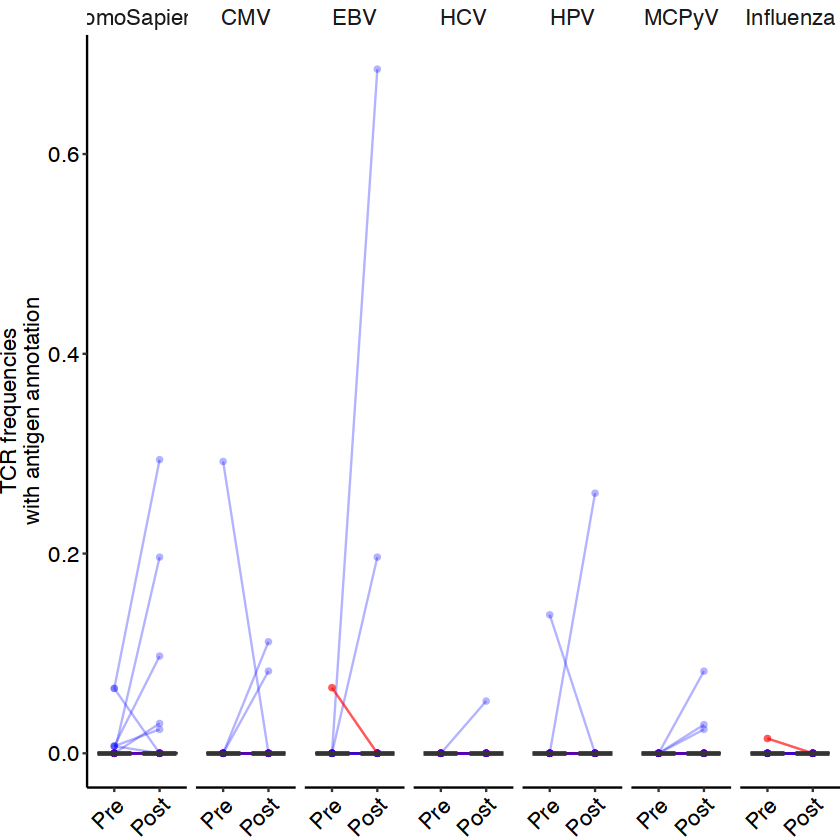

In [270]:
p_sample_cancer

In [271]:
pdf(paste0(plotpath, "antigen_frac_p_solid_cfDNA.pdf"), width = 10, height = 5)
p_sample_cancer
dev.off()

pdf 
  2

# 5- PCA gliph and save

In [ ]:
head(tmp)

In [ ]:
chp_gliph <- tmp[ grepl("CHP", tmp$Sample), ]

In [ ]:
chp_gliph <- chp_gliph[!grepl("Normal", chp_gliph$Sample), ]

In [ ]:
chp_gliph_sum <- chp_gliph %>% 
  group_by(Sample, pattern) %>% 
  summarise(SumFreq = sum(Freq), .groups = 'drop') %>%
  ungroup()

In [ ]:
head(chp_gliph_sum)

In [ ]:
chp_gliph_wide <- tidyr::pivot_wider(chp_gliph_sum[, c("Sample", "pattern", "SumFreq")], names_from = "pattern", values_from = "SumFreq")

In [ ]:
head(chp_gliph_wide)

In [ ]:
chp_gliph_wide <- as.data.frame(chp_gliph_wide)
rownames(chp_gliph_wide) <- chp_gliph_wide$Sample
chp_gliph_wide$Sample <- NULL

In [ ]:
chp_gliph_wide <- as.matrix(chp_gliph_wide)

In [ ]:
head(chp_gliph_wide)

In [ ]:
chp_gliph_wide[is.na(chp_gliph_wide)] <- 0

In [ ]:
head(chp_gliph_wide)

In [ ]:
# pbmc <- chp_gliph_wide[grepl("PBMC", rownames(chp_gliph_wide)),]
chp_gliph_wide <- chp_gliph_wide[, colSums(chp_gliph_wide > 0) > 0]

In [ ]:
mypca <- prcomp(chp_gliph_wide, center = TRUE, scale. = TRUE)

In [ ]:
# plot PCA with factoextra
viz_pca <- fviz_pca_ind(mypca,
    col.ind = as.vector(gsub(":.*", "", rownames(chp_gliph_wide))),
    # gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
    # remove labels
    label = "none",
    repel = TRUE, addEllipses = FALSE
)

In [ ]:
# scree plot
fviz_eig(mypca)

In [ ]:
viz_pca #+ coord_cartesian(xlim=c(-2, 10), ylim=c(-2, 10) )

In [ ]:
mypca$x[ mypca$x[,1] > 400 ,, drop = FALSE]

In [ ]:
chp_gliph_wide["Leukemia:CHP_359_X03-PBMC", , drop = FALSE]

In [ ]:
readr::write_rds(mypca, file = paste0(datapath, "GLIPH/gliph_PCA.rds"))